In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install openpyxl
# !pip install scikit-learn
# !pip install seaborn
# !pip install statsmodels
# !pip install xgboost

In [2]:
# Initialization of packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import sklearn
import seaborn as sns
import statsmodels.api as sm
import glob
import os


from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from ModelingFunctions.GEMpythonlib.GEMpythonfunctions import * 

In [3]:
# Define the columns and the prefixes you want to use
columns_to_compare = [
    ('Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 'freq_lab'),
    ('Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'freq_clinique'),
    ('Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 'volt_lab'),
    ('Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'volt_clinique')
]

# Array or dataframe initialization
data = []

# Constant initialization
minutes_interval = 2

# Constants
NOx_lb_hp_hr = 0.024
CO_lb_hp_hr = 0.0055
SOx_lb_hp_hr = 0.00809
CO2_lb_hp_hr = 1.16
PM_lb_hp_hr = 0.0007

# unit changes
kwh_to_hp_hr = 1.341
lb_to_gr = 453.592


# List of emissions
emissions = ['NOx', 'CO', 'SOx', 'CO2', 'PM']

In [4]:
'''
# Functions
def check_time_intervals(data, time_column='Time', interval_minutes=2):
    """
    Checks if all rows in the DataFrame are separated by a specified time interval.

    Parameters:
    - data: The DataFrame containing the time data.
    - time_column: The column name that contains the time data (default is 'Time').
    - interval_minutes: The time interval in minutes to check for (default is 2 minutes).

    Returns:
    - True if all rows are separated by the specified interval, False otherwise.
    - A DataFrame showing rows that do not follow the interval.
    """
    
    # Ensure the time column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column])

    # Sort the data by time in case it's not already sorted
    data = data.sort_values(by=time_column)

    # Calculate the time difference between consecutive rows
    data['time_diff'] = data[time_column].diff()

    # Define the expected time difference
    expected_diff = pd.Timedelta(minutes=interval_minutes)

    # Identify rows where the time difference is not equal to the expected difference
    invalid_rows = data[data['time_diff'] != expected_diff]

    if invalid_rows.empty:
        print("All rows are separated by exactly {} minutes.".format(interval_minutes))
        return True, None
    else:
        print("Some rows are not separated by exactly {} minutes.".format(interval_minutes))
        return False, invalid_rows

# Usage
# is_valid, invalid_data = check_time_intervals(data)

# If there are invalid rows, display them
#if not is_valid:
#    print("Invalid rows:")
#    display(invalid_data)


#####################################################################################################


def calculate_delta(df, column_name, new_col_name):
    """
    Calculate the delta (difference) between the current and previous values of a column,
    and store the result in a new column.

    Parameters:
    - df: The DataFrame.
    - column_name: The column for which the delta is calculated.
    - new_col_name: The name of the new column where the delta will be stored.
    
    Returns:
    - The DataFrame with the new delta column.
    """
    df.loc[:, new_col_name] = df[column_name] - df[column_name].shift(1)
    return df

# Example usage:
#train_data = calculate_delta(train_data, 'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 'Freq_delta_lab')
#train_data = calculate_delta(train_data, 'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'Freq_delta_clinique')


#####################################################################################################


def evaluate_model_performance(df, actual_column='Generator_ON', prediction_column='prediction'):
    """
    Function to evaluate model performance using accuracy, confusion matrix, precision, and recall.
    
    Parameters:
    df (DataFrame): The DataFrame containing the actual and predicted values.
    actual_column (str): The column name for the actual values. Default is 'Generator_ON'.
    prediction_column (str): The column name for the predicted values. Default is 'prediction'.
    
    Returns:
    dict: A dictionary containing the accuracy, confusion matrix, precision, and recall.
    """
    
    # Extract the actual and predicted values
    y_true = df[actual_column]
    y_pred = df[prediction_column]
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred, zero_division=0)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    # Create a dictionary to store all the metrics
    performance_metrics = {
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall
    }
    
    # Print the metrics
    print(f'Accuracy of model: {performance_metrics["Accuracy"]}')
    print(f'Confusion Matrix:\n{performance_metrics["Confusion Matrix"]}')
    print(f'Precision of model: {performance_metrics["Precision"]}')
    print(f'Recall of model: {performance_metrics["Recall"]}')
    
    return performance_metrics

# Example usage:
# metrics = evaluate_model_performance(train_data_base)


#############################################################################


def evaluate_model_performance_rf(y_true, y_pred):
    """
    Function to evaluate model performance using accuracy, confusion matrix, precision, and recall.
    """
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    
    
##############################################################################


def plot_predictions_vs_actuals(data, model_name, time_column='Time', actual_column='Generator_ON', 
                                prediction_column='prediction', freq_lab_column='Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
                                freq_clinique_column='Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
                                volt_lab_column='Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
                                volt_clinique_column='Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
                                include_voltage=True, include_frequency=True):
    """
    Function to plot actual vs predicted Generator_ON with optional frequency and voltage data.
    
    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - model_name (str): The name of the model (for the plot title).
    - time_column (str): The name of the time column.
    - actual_column (str): The name of the actual Generator_ON column.
    - prediction_column (str): The name of the predicted Generator_ON column.
    - freq_lab_column (str): The column name for lab frequency.
    - freq_clinique_column (str): The column name for clinic frequency.
    - volt_lab_column (str): The column name for lab voltage.
    - volt_clinique_column (str): The column name for clinic voltage.
    - include_voltage (bool): Whether to include voltage data in the plot.
    - include_frequency (bool): Whether to include frequency data in the plot.
    """
    
    # Step 1: Ensure the 'Time' column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')

    # Step 2: Sort the data by 'Time' to ensure the time series is ordered correctly
    data = data.sort_values(by=time_column)

    # Create the figure and axis for Generator_ON
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Scatter plot for correct and incorrect predictions
    correct_predictions = data[data[actual_column] == data[prediction_column]]
    incorrect_predictions = data[data[actual_column] != data[prediction_column]]

    # Scatter plot for correctly predicted points
    ax1.scatter(correct_predictions[time_column], correct_predictions[actual_column], label='Correct Prediction', color='green', marker='o')

    # Scatter plot for incorrectly predicted points
    ax1.scatter(incorrect_predictions[time_column], incorrect_predictions[actual_column], label='Incorrect Prediction', color='red', marker='x')

    # Set labels for the first axis (Generator_ON)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Generator_ON', color='black')
    ax1.set_title(f'Actual vs Predicted Generator_ON with Frequency and Voltage ({model_name})')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.xticks(rotation=45)

    # Plot for Frequency and Voltage using a secondary y-axis if specified
    if include_voltage or include_frequency:
        ax2 = ax1.twinx()  # Create a second y-axis

        # Plot frequency if specified
        if include_frequency:
            ax2.plot(data[time_column], data[freq_lab_column], label='Frequency Lab', color='blue', linestyle='--')
            ax2.plot(data[time_column], data[freq_clinique_column], label='Frequency Clinique', color='purple', linestyle='--')

        # Plot voltage if specified
        if include_voltage:
            ax2.plot(data[time_column], data[volt_lab_column], label='Voltage Lab', color='orange', linestyle='--')
            ax2.plot(data[time_column], data[volt_clinique_column], label='Voltage Clinique', color='brown', linestyle='--')

        # Set the y-axis limits for frequency and voltage if either is plotted
        ax2.set_ylim(0, 270)  # Voltage and frequency common limit (0-250)
        ax2.set_yticks(range(0, 271, 50))  # Set ticks for every 50 units

        # Set the label for the secondary axis (Frequency and Voltage)
        ax2.set_ylabel('Frequency (Hz) / Voltage (V)', color='black')
        ax2.tick_params(axis='y', labelcolor='black')

        # Combine legends from both axes
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage for different models:

# For Random Forest Model with both voltage and frequency
#lot_predictions_vs_actuals(train_data_rf, model_name="Random Forest (Train Set)", include_voltage=True, include_frequency=True)

# For Baseline Model without voltage
# plot_predictions_vs_actuals(baseline_data, model_name="Baseline Model", include_voltage=False, include_frequency=True)

# For Mean Model without frequency
# plot_predictions_vs_actuals(mean_model_data, model_name="Mean Model", include_voltage=True, include_frequency=False)


##############################################################################


def one_hot_encode_hour(df, time_column):
    """
    Function to one-hot encode the hour of the day from a time column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time column.
    time_column (str): The name of the time column (in datetime format).

    Returns:
    pd.DataFrame: The DataFrame with one-hot encoded hours added.
    """
    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])

    # Extract the hour from the time column
    df['Hour'] = df[time_column].dt.hour

    # Perform one-hot encoding for the 'Hour' column
    hour_dummies = pd.get_dummies(df['Hour'], prefix='Hour')

    # Concatenate the original dataframe with the one-hot encoded hour data
    df = pd.concat([df, hour_dummies], axis=1)

    # Drop the 'Hour' column if not needed
    df.drop('Hour', axis=1, inplace=True)

    return df

# Example usage
#train_data = one_hot_encode_hour(train_data, 'Time')


##############################################################################


def calculate_mean_flags(train_data, test_data, base_data, columns):
    """
    Function to calculate the mean for specified columns and flag values as higher than the mean in train and test data.

    Parameters:
    train_data (pd.DataFrame): Training data.
    test_data (pd.DataFrame): Testing data.
    base_data (pd.DataFrame): The dataset to calculate the means from.
    columns (list of tuples): List of tuples where each tuple has two values: 
                              (original column name, new column prefix for flag).

    Returns:
    pd.DataFrame: Updated training and testing data with flags.
    """
    means = {}
    
    # Calculate means for each column in the base_data
    for col, prefix in columns:
        mean_value = base_data[col].mean()
        means[prefix] = mean_value
        
        # print(f'{prefix} mean: {mean_value}')
        
        # Add columns to flag values in train_data as higher or lower than the mean
        train_data[f'higher_{prefix}'] = train_data[col] > mean_value
        
        # Add columns to flag values in test_data as higher or lower than the mean
        test_data[f'higher_{prefix}'] = test_data[col] > mean_value

    return train_data, test_data


##############################################################################


def process_time_series_data(train_df, test_df, high_freq_threshold, low_freq_threshold, high_volt_threshold, low_volt_threshold, time_column='Time'):
    """
    Process time series data for both train and test DataFrames by calculating deltas, flagging delta changes, 
    checking ranges, and memorizing previous high deltas.
    
    Parameters:
    train_df (pd.DataFrame): Training time series DataFrame.
    test_df (pd.DataFrame): Testing time series DataFrame.
    high_freq_threshold (float): High threshold for frequency.
    low_freq_threshold (float): Low threshold for frequency.
    high_volt_threshold (float): High threshold for voltage.
    low_volt_threshold (float): Low threshold for voltage.
    time_column (str): Name of the time column for one-hot encoding.
    
    Returns:
    tuple: Processed training and testing DataFrames.
    """

    def process_single_df(df):
        # Calculate delta for frequency and voltage
        df = calculate_delta(df, 'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 'Freq_delta_lab')
        df = calculate_delta(df, 'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'Freq_delta_clinique')
        df = calculate_delta(df, 'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 'Volt_delta_lab')
        df = calculate_delta(df, 'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'Volt_delta_clinique')

        # Flagging if the delta of change is negative or positive
        df['freq_delta_negative_lab'] = df['Freq_delta_lab'] < 0
        df['freq_delta_negative_clinique'] = df['Freq_delta_clinique'] < 0
        df['volt_delta_positive_lab'] = df['Volt_delta_lab'] >= 0
        df['volt_delta_positive_clinique'] = df['Volt_delta_clinique'] >= 0

        # Checking whether the frequency and voltage are within the reasonable range
        df['freq_in_range_lab'] = (
            (df['Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'] <= high_freq_threshold) &
            (df['Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'] >= low_freq_threshold)
        )
        df['volt_in_range_lab'] = (
            (df['Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'] <= high_volt_threshold) &
            (df['Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'] >= low_volt_threshold)
        )
        df['freq_in_range_clinique'] = (
            (df['Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'] <= high_freq_threshold) &
            (df['Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'] >= low_freq_threshold)
        )
        df['volt_in_range_clinique'] = (
            (df['Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'] <= high_volt_threshold) &
            (df['Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'] >= low_volt_threshold)
        )

        # One-hot encoding for hours of the day
        df = one_hot_encode_hour(df, time_column)

        # Checking the delta of the current
        df['High_delta_freq_lab'] = abs(df['Freq_delta_lab']) > 3
        df['High_delta_freq_clinique'] = abs(df['Freq_delta_clinique']) > 3
        df['High_delta_volt_lab'] = abs(df['Volt_delta_lab']) > 10
        df['High_delta_volt_clinique'] = abs(df['Volt_delta_clinique']) > 10

        # Memorize the previous high delta
        df['Prev_High_delta_freq_lab'] = df['High_delta_freq_lab'].shift(1)
        df['Prev_High_delta_freq_clinique'] = df['High_delta_freq_clinique'].shift(1)
        df['Prev_High_delta_volt_lab'] = df['High_delta_volt_lab'].shift(1)
        df['Prev_High_delta_volt_clinique'] = df['High_delta_volt_clinique'].shift(1)

        return df

    # Process train and test DataFrames
    train_df_processed = process_single_df(train_df)
    test_df_processed = process_single_df(test_df)

    return train_df_processed, test_df_processed

# Example usage:
# Assuming train_data_ts and test_data_ts are your DataFrames
#train_data_ts, test_data_ts = process_time_series_data(train_data_ts, test_data_ts, high_freq_threshold, low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display the processed data
#display(train_data_ts)
#display(test_data_ts)


##############################################################################


def display_generator_statistics(train_data_ts_rf):
    # Ensure columns are boolean (if not already)
    actual_minutes = train_data_ts_rf['Generator_ON'].astype(bool).sum()
    predicted_minutes = train_data_ts_rf['prediction'].astype(bool).sum()
    
    # Total duration in hours (assuming each row represents 1 minute)
    total_hours = len(train_data_ts_rf) / 60
    
    # Display actual and predicted minutes with equivalent hours
    print(f'Actual Minutes: {actual_minutes} minutes, or {actual_minutes / 60:.2f} hours within {total_hours:.2f} hours')
    print(f'Predicted Minutes: {predicted_minutes} minutes, or {predicted_minutes / 60:.2f} hours within {total_hours:.2f} hours')
    
    
##############################################################################


def plot_predictions(data, model_name, time_column='Time', prediction_column='prediction', 
                     freq_lab_column='Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
                     freq_clinique_column='Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
                     volt_lab_column='Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
                     volt_clinique_column='Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
                     include_voltage=True, include_frequency=True):
    """
    Function to plot predicted Generator_ON with optional frequency and voltage data.
    
    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - model_name (str): The name of the model (for the plot title).
    - time_column (str): The name of the time column.
    - prediction_column (str): The name of the predicted Generator_ON column.
    - freq_lab_column (str): The column name for lab frequency.
    - freq_clinique_column (str): The column name for clinic frequency.
    - volt_lab_column (str): The column name for lab voltage.
    - volt_clinique_column (str): The column name for clinic voltage.
    - include_voltage (bool): Whether to include voltage data in the plot.
    - include_frequency (bool): Whether to include frequency data in the plot.
    """
    
    # Step 1: Ensure the 'Time' column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')

    # Step 2: Sort the data by 'Time' to ensure the time series is ordered correctly
    data = data.sort_values(by=time_column)

    # Create the figure and axis for predictions
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot predictions
    ax1.scatter(data[time_column], data[prediction_column], label='Prediction', color='blue', marker='o')

    # Set labels for the first axis (Prediction)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Prediction (Generator_ON)', color='black')
    ax1.set_title(f'Predicted Generator_ON with Frequency and Voltage ({model_name})')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.xticks(rotation=45)

    # Plot for Frequency and Voltage using a secondary y-axis if specified
    if include_voltage or include_frequency:
        ax2 = ax1.twinx()  # Create a second y-axis

        # Plot frequency if specified
        if include_frequency:
            ax2.plot(data[time_column], data[freq_lab_column], label='Frequency Lab', color='green', linestyle='--')
            ax2.plot(data[time_column], data[freq_clinique_column], label='Frequency Clinique', color='purple', linestyle='--')

        # Plot voltage if specified
        if include_voltage:
            ax2.plot(data[time_column], data[volt_lab_column], label='Voltage Lab', color='orange', linestyle='--')
            ax2.plot(data[time_column], data[volt_clinique_column], label='Voltage Clinique', color='brown', linestyle='--')

        # Set the y-axis limits for frequency and voltage if either is plotted
        ax2.set_ylim(0, 270)  # Voltage and frequency common limit (0-250)
        ax2.set_yticks(range(0, 271, 50))  # Set ticks for every 50 units

        # Set the label for the secondary axis (Frequency and Voltage)
        ax2.set_ylabel('Frequency (Hz) / Voltage (V)', color='black')
        ax2.tick_params(axis='y', labelcolor='black')

        # Combine legends from both axes
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show the plot
    plt.tight_layout()
    plt.show()


##############################################################################


def plot_true_predictions_histogram(data, time_column='Time', prediction_column='prediction', minutes_interval=2):
    """
    Plots a histogram of the count of True values in the 'prediction' column per day.

    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - time_column (str): The name of the time column.
    - prediction_column (str): The name of the predicted Generator_ON column.
    - minutes_interval (int): Interval in minutes to multiply by count to get total active time in minutes.
    """
    
    # Step 1: Ensure the 'Time' column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')
    
    # Step 2: Filter the DataFrame to include only rows where predictions are True
    true_predictions = data[data[prediction_column] == True].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    # Step 3: Extract the date from the 'Time' column
    true_predictions.loc[:, 'Date'] = true_predictions[time_column].dt.date
    
    # Step 4: Count occurrences per day, multiply by minutes_interval, and calculate hours
    daily_counts = true_predictions.groupby('Date').size().reset_index(name='Count')
    daily_counts['Minutes'] = daily_counts['Count'] * minutes_interval
    daily_counts['Hours'] = daily_counts['Minutes'] / 60
    
    # Step 5: Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(daily_counts['Date'], daily_counts['Minutes'], color='skyblue')
    plt.xlabel('Date')
    plt.ylabel('Minutes')
    plt.title('Daily Minutes of Generator Usage Predictions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return daily_counts


##############################################################################


# Function to calculate mean of last and future 5 rows for multiple columns, ignoring NaNs
def calculate_custom_mean(df, columns, window_size=5):
    for column in columns:
        means = []
        for i in range(len(df)):
            # Get the range of indices for last 5 and next 5 rows around the current index
            start = max(0, i - window_size)
            end = min(len(df), i + window_size + 1)
            
            # Calculate mean excluding NaNs
            window_data = df[column][start:end]
            mean_value = window_data.sum() / window_data.count() if window_data.count() > 0 else np.nan
            means.append(mean_value)
        
        # Add the result as a new column for each specified column
        df[f'{column}_windows_mean_{window_size}'] = means
    return df

# Apply the function to calculate the custom mean for multiple columns
# df = calculate_custom_mean(df, ['measurement1', 'measurement2', 'measurement3', 'measurement4'])

# Display the DataFrame with the new columns
# print(df)


##############################################################################


def check_outage_series_data(df, column, threshold=10, window_size=30):
    """
    Creates a column that counts the number of outages in the last `window_size` rows,
    where an outage is defined as a value in `column` being less than `threshold`.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    column (str): Column name to check for outages.
    threshold (float): Threshold below which a value is considered an outage.
    window_size (int): Number of previous rows to consider for counting outages.
    
    Returns:
    pd.DataFrame: DataFrame with an additional column indicating the count of outages.
    """
    outage_counts = []
    for i in range(len(df)):
        # Define the window range for the last `window_size` rows up to the current row
        start = max(0, i - window_size + 1)
        window_data = df[column][start:i+1]
        
        # Count the number of outages in this window (values < threshold)
        outage_count = (window_data < threshold).sum()
        outage_counts.append(outage_count)
    
    # Add the outage count as a new column
    df[f'{column}_outage_count'] = outage_counts
    return df

# Apply the function to the DataFrame
# df = check_outage_series_data(df, 'measurement', threshold=10, window_size=30)
# Display the DataFrame with the new column
# print(df)


##############################################################################


# Function to calculate emissions
def calculate_emissions(df):
    df['NOx Emission (g)'] = df['power (kW)'] * NOx_lb_hp_hr * kwh_to_hp_hr * lb_to_gr
    df['CO Emission (g)'] = df['power (kW)'] * CO_lb_hp_hr * kwh_to_hp_hr * lb_to_gr
    df['SOx Emission (g)'] = df['power (kW)'] * SOx_lb_hp_hr * kwh_to_hp_hr * lb_to_gr
    df['CO2 Emission (g)'] = df['power (kW)'] * CO2_lb_hp_hr * kwh_to_hp_hr * lb_to_gr
    df['PM Emission (g)'] = df['power (kW)'] * PM_lb_hp_hr * kwh_to_hp_hr * lb_to_gr
    return df

# Usage:
# test_data_2022 = calculate_emissions(test_data_2022)


##############################################################################


def generator_usage_summary(data):
    # Aggregating data
    data['Date'] = data['Time'].dt.date
    data['Month'] = data['Time'].dt.month

    # Yearly Summary
    total_minutes_year = data['prediction'].sum() * 2
    # total_hours_year = total_minutes_year / 30  # Not used but can be added if needed

    daily_usage = data.groupby('Date')['prediction'].sum() * 2
    average_daily_usage = daily_usage.mean()
    median_daily_usage = daily_usage.median()

    monthly_usage = data.groupby('Month')['prediction'].sum() * 2
    highest_month = monthly_usage.idxmax()
    highest_month_value = monthly_usage.max()
    lowest_month = monthly_usage.idxmin()
    lowest_month_value = monthly_usage.min()

    # Creating year summary DataFrame
    year_summary = pd.DataFrame({
        'Metric': [
            'Total Minutes Used (min)',
            'Average Daily Usage (min)',
            'Median Daily Usage (min)',
            'Highest Month (Total)',
            'Lowest Month (Total)'
        ],
        'Value': [
            total_minutes_year,
            average_daily_usage,
            median_daily_usage,
            f'Month {highest_month} ({highest_month_value} mins)',
            f'Month {lowest_month} ({lowest_month_value} mins)'
        ]
    })

    # Monthly Summary
    monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['prediction'].sum().mean())
    max_daily_usage_per_month = data.groupby('Month').apply(
        lambda x: x.groupby('Date')['prediction'].sum().max()
    )
    max_daily_usage_date_per_month = data.groupby('Month').apply(
        lambda x: x.groupby('Date')['prediction'].sum().idxmax()
    )

    monthly_summary = pd.DataFrame({
        'Month': monthly_usage.index,
        'Total Usage (min)': monthly_usage.values,
        'Average Daily Usage (min)': monthly_daily_avg.values,
        'Max Daily Usage (min)': max_daily_usage_per_month.values,
        'Max Daily Usage (Date)': max_daily_usage_date_per_month.values
    })

    return year_summary, monthly_summary

# Usage:
# year_summary, monthly_summary = power_usage_summary(data)
# display("Yearly Summary:")
# display(year_summary)
# display("\nMonthly Summary:")
# display(monthly_summary)


##############################################################################


def power_usage_summary(data):
    # Aggregating data
    data['Date'] = data['Time'].dt.date
    data['Month'] = data['Time'].dt.month

    # Yearly Summary
    total_power_year = data['power (kW)'].sum()

    daily_usage = data.groupby('Date')['power (kW)'].sum()
    average_daily_usage = daily_usage.mean()
    median_daily_usage = daily_usage.median()

    monthly_usage = data.groupby('Month')['power (kW)'].sum()
    highest_month = monthly_usage.idxmax()
    highest_month_value = monthly_usage.max()
    lowest_month = monthly_usage.idxmin()
    lowest_month_value = monthly_usage.min()

    # Creating year summary DataFrame
    year_summary = pd.DataFrame({
        'Metric': [
            'Total Power Used (kW)',
            'Average Daily Usage (kW)',
            'Median Daily Usage (kW)',
            'Highest Month (Total)',
            'Lowest Month (Total)'
        ],
        'Value': [
            total_power_year.round(2),
            average_daily_usage.round(2),
            median_daily_usage.round(2),
            f'Month {highest_month} ({highest_month_value.round(2)} kW)',
            f'Month {lowest_month} ({lowest_month_value.round(2)} kW)'
        ]
    })

    # Monthly Summary
    monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['power (kW)'].sum().mean())
    max_daily_usage_per_month = data.groupby('Month').apply(
        lambda x: x.groupby('Date')['power (kW)'].sum().max()
    )
    max_daily_usage_date_per_month = data.groupby('Month').apply(
        lambda x: x.groupby('Date')['power (kW)'].sum().idxmax()
    )

    monthly_summary = pd.DataFrame({
        'Month': monthly_usage.index,
        'Total Usage (kW)': monthly_usage.values.round(2),
        'Average Daily Usage (kW)': monthly_daily_avg.values.round(2),
        'Max Daily Usage (kW)': max_daily_usage_per_month.values.round(2),
        'Max Daily Usage (Date)': max_daily_usage_date_per_month.values
    })

    return year_summary, monthly_summary

# Usage:
# year_summary, monthly_summary = power_usage_summary(data)
# display("Yearly Summary:")
# display(year_summary)
# display("\nMonthly Summary:")
# display(monthly_summary)


##############################################################################


def generator_emission_summary(data):
    # Aggregating data
    data['Date'] = data['Time'].dt.date
    data['Month'] = data['Time'].dt.month

    for emission in emissions:

        # Power Usage Summary
        total_emission_year = data[f'{emission} Emission (g)'].sum()
        daily_emission = data.groupby('Date')[f'{emission} Emission (g)'].sum()
        average_daily_emission = daily_emission.mean()
        median_daily_emission = daily_emission.median()

        monthly_emission = data.groupby('Month')[f'{emission} Emission (g)'].sum()
        highest_month = monthly_emission.idxmax()
        highest_month_value = monthly_emission.max()
        lowest_month = monthly_emission.idxmin()
        lowest_month_value = monthly_emission.min()

        # Creating year summary DataFrame with emissions and power usage
        year_summary = pd.DataFrame({
            'Metric': [
                f'Total year {emission} Emission (g)',
                f'Average Daily {emission} Emission (g)',
                f'Median Daily {emission} Emission (g)',
                f'Highest Month {emission} Emission (Total)',
                f'Lowest Month {emission} Emission (Total)',
            ],
            'Value': [
                total_emission_year.round(2),
                average_daily_emission.round(2),
                median_daily_emission.round(2),
                f'Month {highest_month} ({highest_month_value.round(2)} g)',
                f'Month {lowest_month} ({lowest_month_value.round(2)} g)',
            ]
        })

        # Monthly Summary for emission
        monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
        max_daily_emission_per_month = data.groupby('Month').apply(
            lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().max()
        )
        max_daily_emission_date_per_month = data.groupby('Month').apply(
            lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().idxmax()
        )

        monthly_summary = pd.DataFrame({
            f'Month': monthly_emission.index,
            f'Total {emission} Emission (g)': monthly_emission.values.round(2),
            f'Average Daily {emission} Emission (g)': monthly_daily_avg.values.round(2),
            f'Max Daily {emission} Emission (g)': max_daily_emission_per_month.values.round(2),
            f'Max Daily {emission} Emission (Date)': max_daily_emission_date_per_month.values
        })

        display(f"Yearly Summary {emission} emission:")
        display(year_summary)
        display(f"Monthly Summary  {emission} emission:")
        display(monthly_summary)

    #return year_summary, monthly_summary

'''

'\n# Functions\ndef check_time_intervals(data, time_column=\'Time\', interval_minutes=2):\n    """\n    Checks if all rows in the DataFrame are separated by a specified time interval.\n\n    Parameters:\n    - data: The DataFrame containing the time data.\n    - time_column: The column name that contains the time data (default is \'Time\').\n    - interval_minutes: The time interval in minutes to check for (default is 2 minutes).\n\n    Returns:\n    - True if all rows are separated by the specified interval, False otherwise.\n    - A DataFrame showing rows that do not follow the interval.\n    """\n    \n    # Ensure the time column is in datetime format\n    data[time_column] = pd.to_datetime(data[time_column])\n\n    # Sort the data by time in case it\'s not already sorted\n    data = data.sort_values(by=time_column)\n\n    # Calculate the time difference between consecutive rows\n    data[\'time_diff\'] = data[time_column].diff()\n\n    # Define the expected time difference\n    ex

# 1. Loading the Data

In [5]:
# Opening files
file_list = ['Voltage Time Series-data-2024-09-15 15_04_52.csv',  
             'Voltage Time Series-data-2024-09-15 15_05_24.csv', 
             'Voltage Time Series-data-2024-09-15 15_06_06.csv',
             'Voltage Time Series-data-2024-09-15 15_06_22.csv',
             'Voltage Time Series-data-2024-09-15 15_05_49.csv',
             'Voltage Time Series-data-2024-10-28 21_01_48.csv',
             'Voltage Time Series-data-2024-10-28 21_02_00.csv',
             'Voltage Time Series-data-2024-10-28 21_02_17.csv',
             'Voltage Time Series-data-2024-10-28 21_02_43.csv']

file_path = 'data/'

# Initialize an empty list to collect DataFrames
data_frames = []

for file in file_list:
    # Read each file into a DataFrame and append to the list
    monthly_data = pd.read_csv(file_path + file)
    data_frames.append(monthly_data)

# Concatenate all DataFrames in the list at once
data = pd.concat(data_frames, ignore_index=True)

# Display the final concatenated DataFrame
display(data)

Time  \
0        9/9/24 0:00   
1        9/9/24 0:02   
2        9/9/24 0:04   
3        9/9/24 0:06   
4        9/9/24 0:08   
...              ...   
45355  2/28/23 23:50   
45356  2/28/23 23:52   
45357  2/28/23 23:54   
45358  2/28/23 23:56   
45359  2/28/23 23:58   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   51.7            
1                                                   51.9            
2                                                   51.8            
3                                                   52.0            
4                                                   52.1            
...                                                  ...            
45355                                               50.2            
45356                                               50.4            
45357                                               50.4            
45358                                               50.4            
45359                                               50.5            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   51.6         
1                                                   52.0         
2                                                   52.1         
3                                                   52.0         
4                                                   52.0         
...                                                  ...         
45355                                               50.2         
45356                                               50.3         
45357                                               50.3         
45358                                               50.4         
45359                                               50.5         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  226.0          
1                                                  227.0          
2                                                  226.0          
3                                                  225.0          
4                                                  225.0          
...                                                  ...          
45355                                              216.0          
45356                                              220.0          
45357                                              220.0          
45358                                              219.0          
45359                                              220.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  
0                                                  242.0              True  
1                                                  243.0              True  
2                                                  241.0              True  
3                                                  241.0              True  
4                                                  241.0              True  
...                                                  ...               ...  
45355                                              219.0             False  
45356                                              222.0             False  
45357                                              221.0             False  
45358                                              221.0             False  
45359                                              222.0             False  

[45360 rows x 6 columns]

In [6]:

# Sort values by 'Time' in ascending order
data.sort_values('Time', ascending=True, inplace=True)

# Now you can proceed to drop the duplicates as before
data.drop_duplicates(subset='Time', inplace=True)

# Reset the index after dropping duplicates
data.reset_index(drop=True, inplace=True)

# Display the cleaned data
display(data)

Time  \
0      2/1/23 0:00   
1      2/1/23 0:02   
2      2/1/23 0:04   
3      2/1/23 0:06   
4      2/1/23 0:08   
...            ...   
45355  9/9/24 9:50   
45356  9/9/24 9:52   
45357  9/9/24 9:54   
45358  9/9/24 9:56   
45359  9/9/24 9:58   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.5            
1                                                   50.6            
2                                                   50.6            
3                                                   50.6            
4                                                   50.5            
...                                                  ...            
45355                                               49.6            
45356                                               49.5            
45357                                               49.7            
45358                                               49.3            
45359                                               49.5            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.4         
1                                                   50.5         
2                                                   50.6         
3                                                   50.5         
4                                                   50.6         
...                                                  ...         
45355                                               49.5         
45356                                               49.5         
45357                                               49.6         
45358                                               49.3         
45359                                               49.5         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  223.0          
1                                                  223.0          
2                                                  223.0          
3                                                  224.0          
4                                                  222.0          
...                                                  ...          
45355                                              194.0          
45356                                              197.0          
45357                                              196.0          
45358                                              196.0          
45359                                              199.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  
0                                                  223.0             False  
1                                                  224.0             False  
2                                                  224.0             False  
3                                                  225.0             False  
4                                                  224.0             False  
...                                                  ...               ...  
45355                                              196.0             False  
45356                                              197.0             False  
45357                                              195.0             False  
45358                                              193.0             False  
45359                                              199.0             False  

[45360 rows x 6 columns]

In [7]:
# Checking if all rows have the same date time format:

data['Time'] = pd.to_datetime(data['Time'], format="%m/%d/%y %H:%M")

In [8]:
# Check interval of data:

is_valid, invalid_data = check_time_intervals(data)

# If there are invalid rows, display them
if not is_valid:
    print("Invalid rows:")
    display(invalid_data)
    
#display(data.iloc[10078:10082])

Some rows are not separated by exactly 2 minutes.
Invalid rows:


Time  Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0     2023-02-01                                               50.5            
20160 2024-08-12                                               50.2            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.4         
20160                                               50.2         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  223.0          
20160                                              208.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  \
0                                                  223.0             False   
20160                                              224.0             False   

              time_diff  
0                   NaT  
20160 530 days 00:02:00

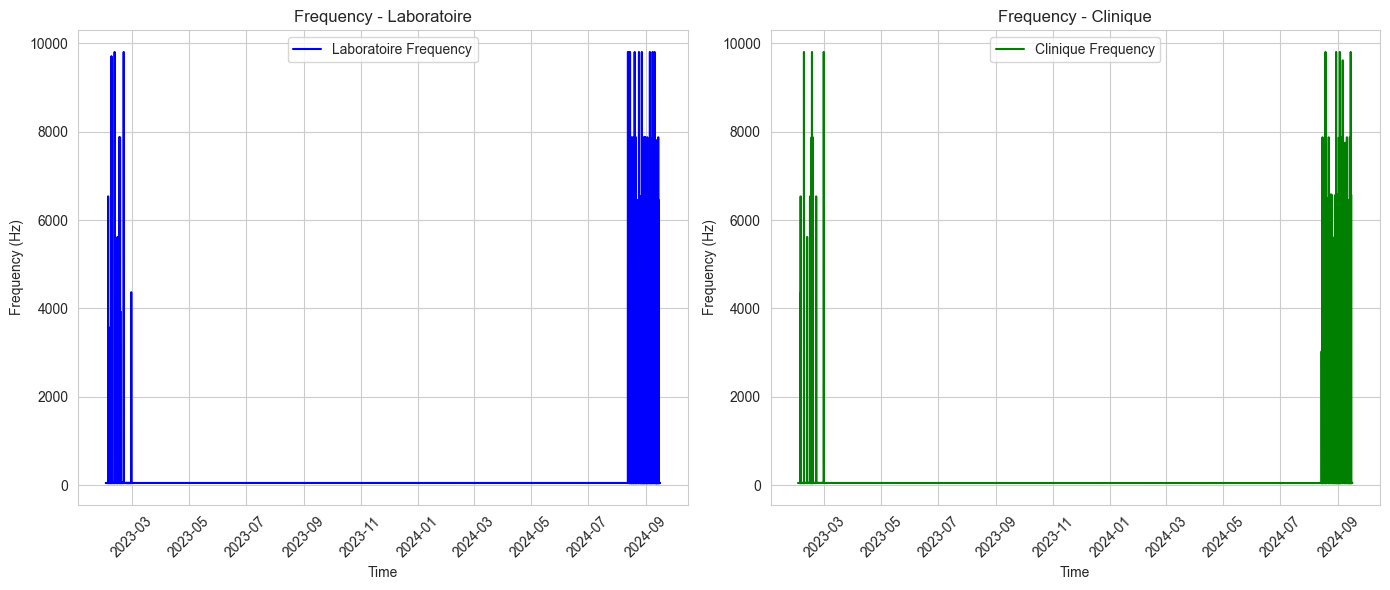

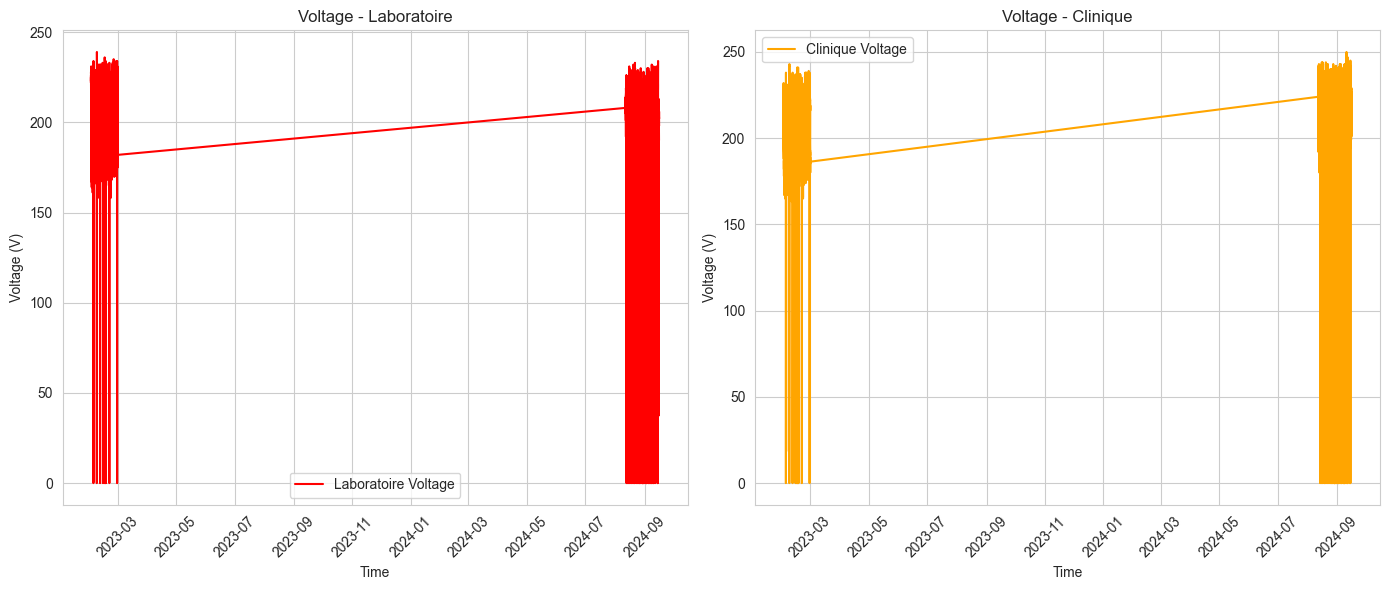

In [9]:
# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Plot Frequency for both facilities
plt.figure(figsize=(14, 6))

# Plot Frequency for Laboratoire
plt.subplot(1, 2, 1)
plt.plot(data['Time'], data['Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'], label='Laboratoire Frequency', color='blue')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency - Laboratoire')
plt.xticks(rotation=45)
plt.legend()

# Plot Frequency for Clinique
plt.subplot(1, 2, 2)
plt.plot(data['Time'], data['Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'], label='Clinique Frequency', color='green')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency - Clinique')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Plot Voltage for both facilities
plt.figure(figsize=(14, 6))

# Plot Voltage for Laboratoire
plt.subplot(1, 2, 1)
plt.plot(data['Time'], data['Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)'], label='Laboratoire Voltage', color='red')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Voltage - Laboratoire')
plt.xticks(rotation=45)
plt.legend()

# Plot Voltage for Clinique
plt.subplot(1, 2, 2)
plt.plot(data['Time'], data['Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'], label='Clinique Voltage', color='orange')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Voltage - Clinique')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# List of columns to calculate statistics
columns_of_interest = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'
]

# Calculate the statistics for each column, including mean, median, percentiles, and null counts
stats = data[columns_of_interest].agg([
    'mean',
    'median',
    lambda x: x.quantile(0.01),  # 1st percentile
    lambda x: x.quantile(0.99),  # 99th percentile
    lambda x: x.isnull().sum()/x.sum()*100  # Null counts
])

# Renaming the lambda output columns
stats.columns = columns_of_interest
stats.index = ['Mean', 'Median', '1st Percentile', '99th Percentile', 'Null Count (%)']

# Display the statistics
print(stats)

                 Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
Mean                                                     72.947477            
Median                                                   50.100000            
1st Percentile                                           49.000000            
99th Percentile                                          52.100000            
Null Count (%)                                            0.000091            

                 Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
Mean                                                     80.850821         
Median                                                   50.100000         
1st Percentile                                           49.000000         
99th Percentile                                          52.400000         
Null Count (%)                                            0.000027         

                 Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laborat

# 2. Training and Test Data Separation

In [11]:
# Determine the split index (60% for training)
split_index = int(len(data) * 0.6)

# Split the data into training and testing sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Display the sizes of the train and test sets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Optionally, display the first few rows of each
print("Training Data Sample:")
display(train_data)

print("Test Data Sample:")
display(test_data)

Training data size: 27216
Test data size: 18144
Training Data Sample:


Time  \
0     2023-02-01 00:00:00   
1     2023-02-01 00:02:00   
2     2023-02-01 00:04:00   
3     2023-02-01 00:06:00   
4     2023-02-01 00:08:00   
...                   ...   
27211 2024-08-21 05:02:00   
27212 2024-08-21 05:04:00   
27213 2024-08-21 05:06:00   
27214 2024-08-21 05:08:00   
27215 2024-08-21 05:10:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.5            
1                                                   50.6            
2                                                   50.6            
3                                                   50.6            
4                                                   50.5            
...                                                  ...            
27211                                               49.8            
27212                                               49.9            
27213                                               49.8            
27214                                               49.7            
27215                                               49.7            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.4         
1                                                   50.5         
2                                                   50.6         
3                                                   50.5         
4                                                   50.6         
...                                                  ...         
27211                                               49.9         
27212                                               50.0         
27213                                               49.8         
27214                                               49.7         
27215                                               49.8         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  223.0          
1                                                  223.0          
2                                                  223.0          
3                                                  224.0          
4                                                  222.0          
...                                                  ...          
27211                                              213.0          
27212                                              211.0          
27213                                              214.0          
27214                                              211.0          
27215                                              210.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  
0                                                  223.0             False  
1                                                  224.0             False  
2                                                  224.0             False  
3                                                  225.0             False  
4                                                  224.0             False  
...                                                  ...               ...  
27211                                              233.0             False  
27212                                              233.0             False  
27213                                              233.0             False  
27214                                              232.0             False  
27215                                              232.0             False  

[27216 rows x 6 columns]

Test Data Sample:


Time  \
27216 2024-08-21 05:12:00   
27217 2024-08-21 05:14:00   
27218 2024-08-21 05:16:00   
27219 2024-08-21 05:18:00   
27220 2024-08-21 05:20:00   
...                   ...   
45355 2024-09-09 09:50:00   
45356 2024-09-09 09:52:00   
45357 2024-09-09 09:54:00   
45358 2024-09-09 09:56:00   
45359 2024-09-09 09:58:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                               50.3            
27217                                               50.1            
27218                                               50.1            
27219                                               50.0            
27220                                               49.6            
...                                                  ...            
45355                                               49.6            
45356                                               49.5            
45357                                               49.7            
45358                                               49.3            
45359                                               49.5            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
27216                                               50.2         
27217                                               50.0         
27218                                               50.0         
27219                                               50.1         
27220                                               49.6         
...                                                  ...         
45355                                               49.5         
45356                                               49.5         
45357                                               49.6         
45358                                               49.3         
45359                                               49.5         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                              213.0          
27217                                              213.0          
27218                                              210.0          
27219                                              213.0          
27220                                              212.0          
...                                                  ...          
45355                                              194.0          
45356                                              197.0          
45357                                              196.0          
45358                                              196.0          
45359                                              199.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  
27216                                              233.0             False  
27217                                              233.0             False  
27218                                              224.0             False  
27219                                              225.0             False  
27220                                              231.0             False  
...                                                  ...               ...  
45355                                              196.0             False  
45356                                              197.0             False  
45357                                              195.0             False  
45358                                              193.0             False  
45359                                              199.0             False  

[18144 rows x 6 columns]

# 3. Voltage and Frequency Only 

#### *3.1. Baseline Model on the Voltage and Frequency only*

-> Choosing only the most from the train set

In [12]:
train_data_base = train_data.copy()
test_data_base = test_data.copy()

In [13]:
train_data_base['prediction'] = (train_data_base['Generator_ON'].mean()) > 0.5
test_data_base['prediction'] = (train_data_base['Generator_ON'].mean()) > 0.5

display('Train data for baseline:')
display(train_data_base['prediction'])

display('Test data for baseline:')
display(test_data_base['prediction'])

'Train data for baseline:'

0        False
1        False
2        False
3        False
4        False
         ...  
27211    False
27212    False
27213    False
27214    False
27215    False
Name: prediction, Length: 27216, dtype: bool

'Test data for baseline:'

27216    False
27217    False
27218    False
27219    False
27220    False
         ...  
45355    False
45356    False
45357    False
45358    False
45359    False
Name: prediction, Length: 18144, dtype: bool

Assessing the model:

In [14]:
# TRAIN DATA EVALUATION
metrics = evaluate_model_performance(train_data_base)

Accuracy of model: 0.8528439153439153
Confusion Matrix:
[[23211     0]
 [ 4005     0]]
Precision of model: 0.0
Recall of model: 0.0


In [15]:
# TEST DATA EVALUATION
metrics = evaluate_model_performance(test_data_base)

Accuracy of model: 0.8166887125220459
Confusion Matrix:
[[14818     0]
 [ 3326     0]]
Precision of model: 0.0
Recall of model: 0.0


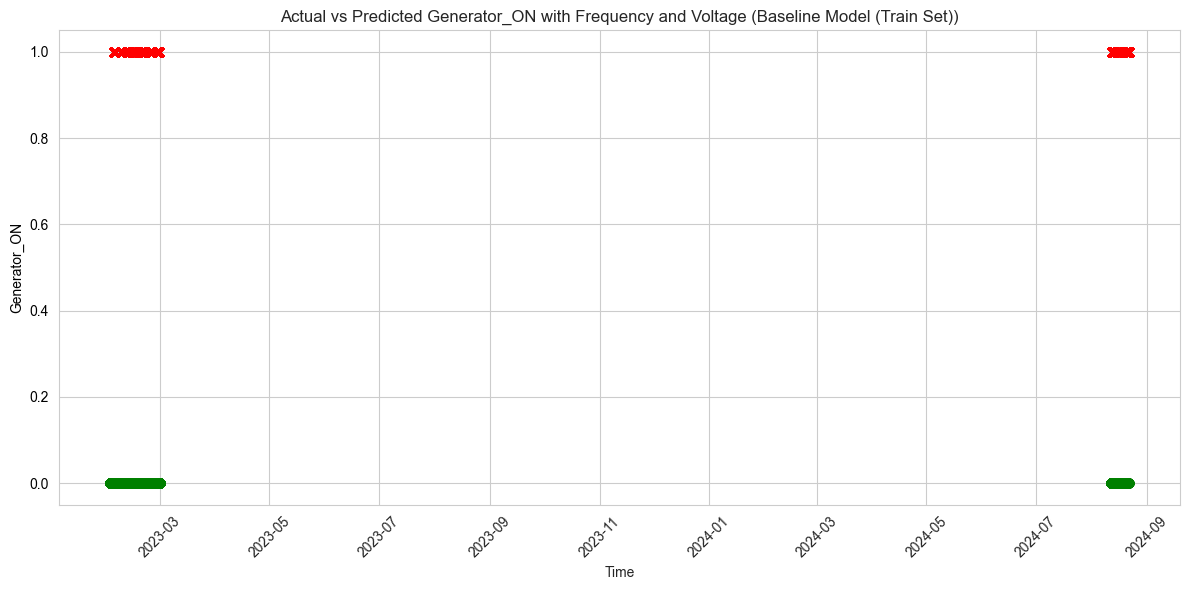

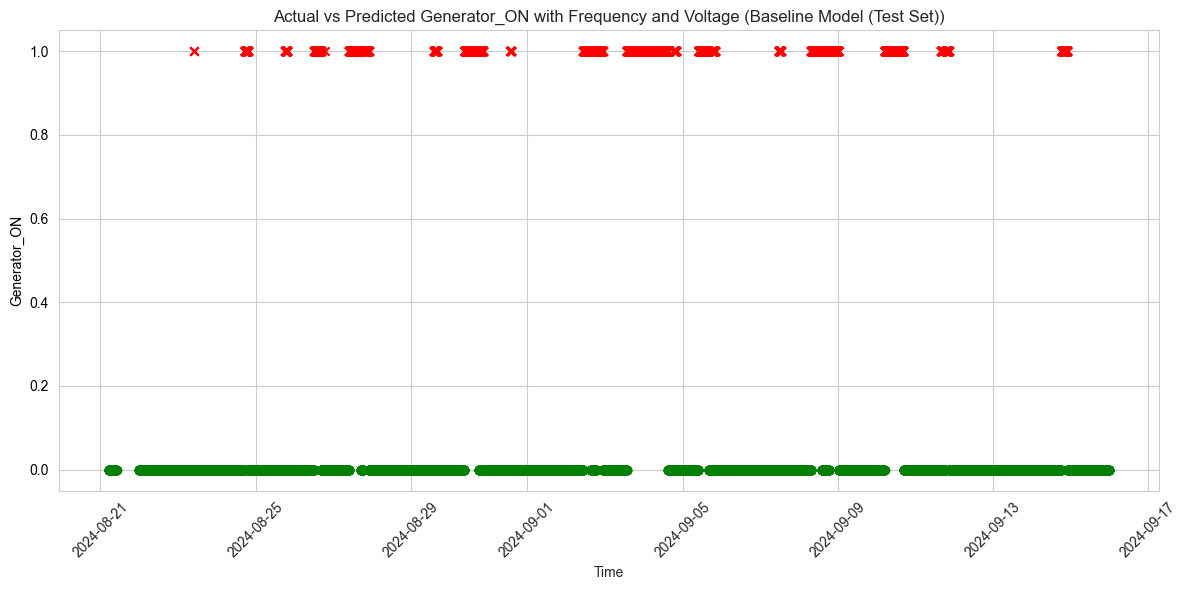

In [16]:
# For Baseline Model without voltage
plot_predictions_vs_actuals(train_data_base, model_name="Baseline Model (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_base, model_name="Baseline Model (Test Set)", include_voltage=False, include_frequency=False)

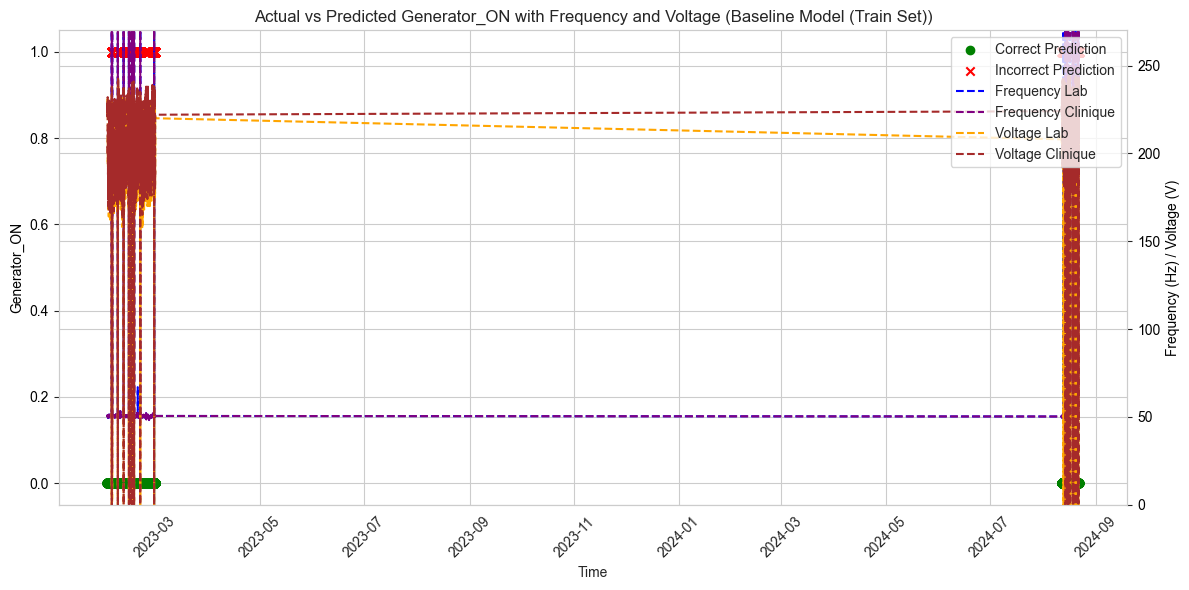

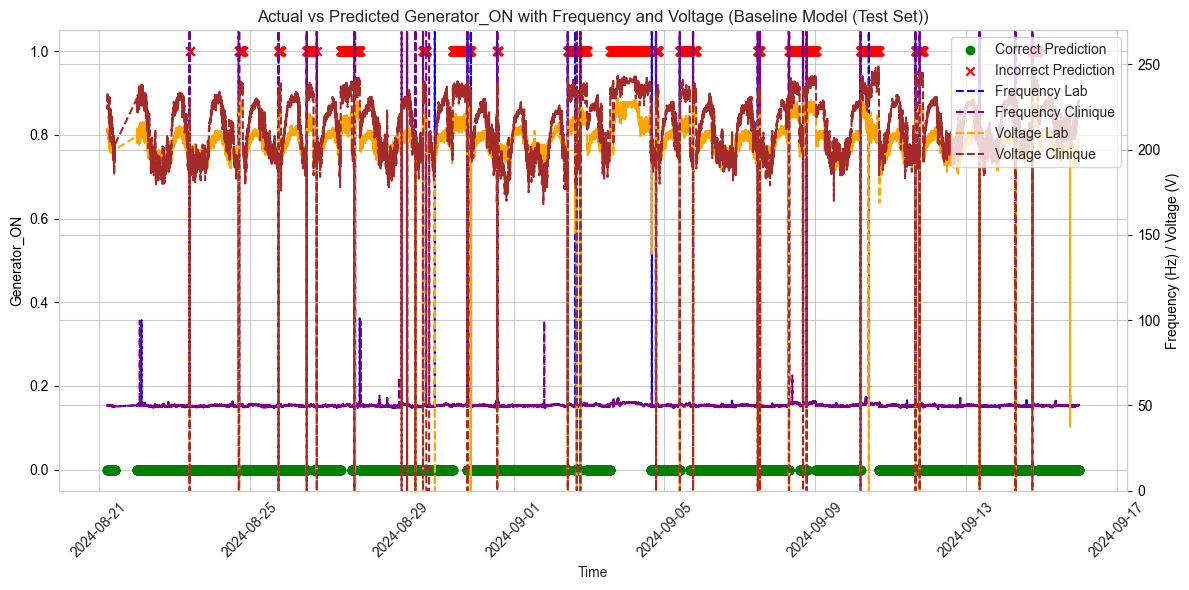

In [17]:
# For Baseline Model without voltage
plot_predictions_vs_actuals(train_data_base, model_name="Baseline Model (Train Set)", include_voltage=True, include_frequency=True)
plot_predictions_vs_actuals(test_data_base, model_name="Baseline Model (Test Set)", include_voltage=True, include_frequency=True)

#### *3.2. Logistic Regression on the Voltage and Frequency only*

In [18]:
# Step 1: Create copies of the original data
train_data_mean_lg = train_data.copy()
test_data_mean_lg = test_data.copy()

# Calculate the mean flags (assuming the function 'calculate_mean_flags' is defined)
train_data_mean_lg, test_data_mean_lg = calculate_mean_flags(train_data_mean_lg, test_data_mean_lg, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_mean_lg[feature_columns]
y_train = train_data_mean_lg['Generator_ON']

X_test = test_data_mean_lg[feature_columns]
y_test = test_data_mean_lg['Generator_ON']

# Fill NaN values in training and testing data with the mean of each column
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use training mean to avoid data leakage

# Step 2: Train a Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_mean_lg['prediction_value'] = reg.predict(X_train)
test_data_mean_lg['prediction_value'] = reg.predict(X_test)

# Optional: Convert predictions to binary form for classification (e.g., threshold at 0.5)
train_data_mean_lg['prediction'] = (train_data_mean_lg['prediction_value'] >= 0.5).astype(int)
test_data_mean_lg['prediction'] = (test_data_mean_lg['prediction_value'] >= 0.5).astype(int)

# Print accuracy for classification interpretation
train_accuracy = accuracy_score(y_train, train_data_mean_lg['prediction'])
test_accuracy = accuracy_score(y_test, test_data_mean_lg['prediction'])

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 0.85
Test Accuracy: 0.82


Evaluating the train set - Baseline Logistic Regression:

In [19]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_mean_lg['prediction'])

print("Train data prediction distribution:")
print(train_data_mean_lg['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 0.8515579071134627
Confusion Matrix:
[[23172    39]
 [ 4001     4]]
Precision: 0.09302325581395349
Recall: 0.0009987515605493133
Train data prediction distribution:
prediction
0    27173
1       43
Name: count, dtype: int64


Evaluating the test set - Baseline Logistic Regression:

In [20]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_mean_lg['prediction'])

print("Test data prediction distribution:")
print(test_data_mean_lg['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.8212632275132276
Confusion Matrix:
[[14788    30]
 [ 3213   113]]
Precision: 0.7902097902097902
Recall: 0.03397474443776308
Test data prediction distribution:
prediction
0    18001
1      143
Name: count, dtype: int64


#### *3.3. Random Forrest on the Voltage and Frequency only*

In [21]:
# Step 1: Create copies of the original data
train_data_rf = train_data.copy()
test_data_rf = test_data.copy()

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_rf[feature_columns]
y_train = train_data_rf['Generator_ON']

X_test = test_data_rf[feature_columns]
y_test = test_data_rf['Generator_ON']

# Step 2: Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_rf['prediction'] = clf.predict(X_train)
test_data_rf['prediction'] = clf.predict(X_test)

Evaluating the train set (Random Forrest): 

In [22]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_rf['prediction'])

print("Train data prediction distribution:")
print(train_data_rf['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 0.9971340388007055
Confusion Matrix:
[[23186    25]
 [   53  3952]]
Precision: 0.9937138546643198
Recall: 0.9867665418227216
Train data prediction distribution:
prediction
False    23239
True      3977
Name: count, dtype: int64


Evaluating the test set (Random Forrest): 

In [23]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_rf['prediction'])

print("Test data prediction distribution:")
print(test_data_rf['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.9637345679012346
Confusion Matrix:
[[14668   150]
 [  508  2818]]
Precision: 0.9494609164420486
Recall: 0.8472639807576668
Test data prediction distribution:
prediction
False    15176
True      2968
Name: count, dtype: int64


#### *3.4. XG-Boost on the Voltage and Frequency only*

/Users/danielsitompul/Documents/GitHub/Generator_ML_Emission_Modeling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Top 20 features sorted by importance (XGBoost):


Feature  Importance
3  Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - cl...    0.800289
0  Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - ...    0.103421
2  Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - la...    0.057544
1  Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - ...    0.038746

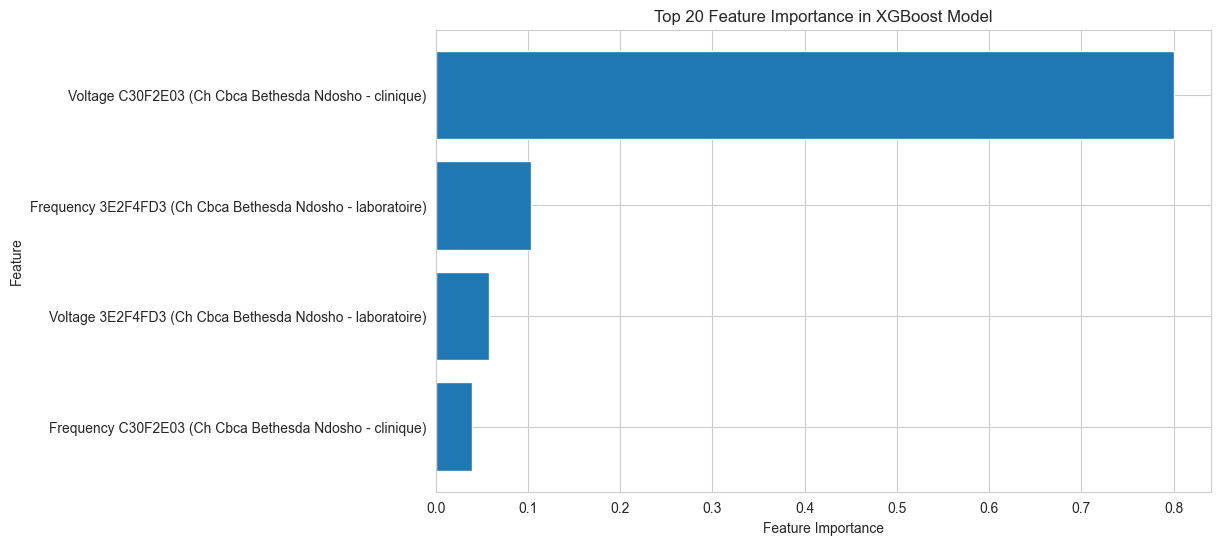

In [24]:
# Step 0: Copy rf data
train_data_boost = train_data.copy()
test_data_boost = test_data.copy()

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)'
]


# Step 1: Use the same data and feature columns
X_train = train_data_boost[feature_columns]
y_train = train_data_boost['Generator_ON']

X_test = test_data_boost[feature_columns]
y_test = test_data_boost['Generator_ON']


# Step 2: Train an XGBoost Classifier
xgb_clf = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # Evaluation metric for binary classification
    use_label_encoder=False  # Avoid unnecessary warnings
)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_boost['prediction'] = xgb_clf.predict(X_train)
test_data_boost['prediction'] = xgb_clf.predict(X_test)

# Step 4: Evaluate Feature Importances
importances = xgb_clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the features by importance and keep only the top 20
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top 20 most important features
print("Top 20 features sorted by importance (XGBoost):")
display(top_20_features)

# Visualize the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()

In [25]:
# Step 5: Evaluate Model Performance
# Evaluate on the train set
print("Train Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_train, train_data_boost['prediction'])

print("Train data prediction distribution (XGBoost):")
print(train_data_boost['prediction'].value_counts())

Train Set Evaluation (XGBoost):
Accuracy: 0.9930922986478542
Confusion Matrix:
[[23142    69]
 [  119  3886]]
Precision: 0.9825537294563843
Recall: 0.9702871410736579
Train data prediction distribution (XGBoost):
prediction
0    23261
1     3955
Name: count, dtype: int64


In [26]:
# Step 5: Evaluate Model Performance
# Evaluate on the train set
print("Test Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_test, test_data_boost['prediction'])

print("Test data prediction distribution (XGBoost):")
print(train_data_boost['prediction'].value_counts())

Test Set Evaluation (XGBoost):
Accuracy: 0.9653880070546738
Confusion Matrix:
[[14680   138]
 [  490  2836]]
Precision: 0.9535978480161399
Recall: 0.8526758869512928
Test data prediction distribution (XGBoost):
prediction
0    23261
1     3955
Name: count, dtype: int64


# 4. Feature Generation

### 4.1. Using Mean as a Threshold

In [27]:
train_data_mean = train_data.copy()
test_data_mean = test_data.copy()

In [28]:
# Taking the mean of the dataframe
train_data_mean, test_data_mean = calculate_mean_flags(train_data_mean, test_data_mean, train_data_base, columns_to_compare)

# Display the updated data
display(train_data_mean)
display(test_data_mean)

Time  \
0     2023-02-01 00:00:00   
1     2023-02-01 00:02:00   
2     2023-02-01 00:04:00   
3     2023-02-01 00:06:00   
4     2023-02-01 00:08:00   
...                   ...   
27211 2024-08-21 05:02:00   
27212 2024-08-21 05:04:00   
27213 2024-08-21 05:06:00   
27214 2024-08-21 05:08:00   
27215 2024-08-21 05:10:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.5            
1                                                   50.6            
2                                                   50.6            
3                                                   50.6            
4                                                   50.5            
...                                                  ...            
27211                                               49.8            
27212                                               49.9            
27213                                               49.8            
27214                                               49.7            
27215                                               49.7            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.4         
1                                                   50.5         
2                                                   50.6         
3                                                   50.5         
4                                                   50.6         
...                                                  ...         
27211                                               49.9         
27212                                               50.0         
27213                                               49.8         
27214                                               49.7         
27215                                               49.8         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  223.0          
1                                                  223.0          
2                                                  223.0          
3                                                  224.0          
4                                                  222.0          
...                                                  ...          
27211                                              213.0          
27212                                              211.0          
27213                                              214.0          
27214                                              211.0          
27215                                              210.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  \
0                                                  223.0             False   
1                                                  224.0             False   
2                                                  224.0             False   
3                                                  225.0             False   
4                                                  224.0             False   
...                                                  ...               ...   
27211                                              233.0             False   
27212                                              233.0             False   
27213                                              233.0             False   
27214                                              232.0             False   
27215                                              232.0             False   

       higher_freq_lab  higher_freq_clinique  higher_volt_lab  \
0                False                 False             True   
1                False                 False             True   
2                False                 False             True   
3                False                 False    

Time  \
27216 2024-08-21 05:12:00   
27217 2024-08-21 05:14:00   
27218 2024-08-21 05:16:00   
27219 2024-08-21 05:18:00   
27220 2024-08-21 05:20:00   
...                   ...   
45355 2024-09-09 09:50:00   
45356 2024-09-09 09:52:00   
45357 2024-09-09 09:54:00   
45358 2024-09-09 09:56:00   
45359 2024-09-09 09:58:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                               50.3            
27217                                               50.1            
27218                                               50.1            
27219                                               50.0            
27220                                               49.6            
...                                                  ...            
45355                                               49.6            
45356                                               49.5            
45357                                               49.7            
45358                                               49.3            
45359                                               49.5            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
27216                                               50.2         
27217                                               50.0         
27218                                               50.0         
27219                                               50.1         
27220                                               49.6         
...                                                  ...         
45355                                               49.5         
45356                                               49.5         
45357                                               49.6         
45358                                               49.3         
45359                                               49.5         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                              213.0          
27217                                              213.0          
27218                                              210.0          
27219                                              213.0          
27220                                              212.0          
...                                                  ...          
45355                                              194.0          
45356                                              197.0          
45357                                              196.0          
45358                                              196.0          
45359                                              199.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  \
27216                                              233.0             False   
27217                                              233.0             False   
27218                                              224.0             False   
27219                                              225.0             False   
27220                                              231.0             False   
...                                                  ...               ...   
45355                                              196.0             False   
45356                                              197.0             False   
45357                                              195.0             False   
45358                                              193.0             False   
45359                                              199.0             False   

       higher_freq_lab  higher_freq_clinique  higher_volt_lab  \
27216            False                 False             True   
27217            False                 False             True   
27218            False                 False             True   
27219            False                 False    

#### 4.1.1. Using Mean as a Threshold - Custom Prediction

In [29]:
# Define custom prediction logic
def custom_prediction(row):
    # Example: Set prediction to True if either clinic or lab has higher frequency and voltage
    if (row['higher_freq_lab'] or row['higher_volt_lab']) and (row['higher_freq_clinique'] or row['higher_volt_clinique']):
        return True
    else:
        return False

# Apply custom prediction logic
train_data_mean['prediction'] = train_data_mean.apply(custom_prediction, axis=1)
test_data_mean['prediction'] = test_data_mean.apply(custom_prediction, axis=1)

# Show prediction:
display('Train data for baseline:')
display(train_data_mean['prediction'].value_counts())

display('Test data for baseline:')
display(test_data_mean['prediction'].value_counts())

'Train data for baseline:'

prediction
False    13723
True     13493
Name: count, dtype: int64

'Test data for baseline:'

prediction
False    9536
True     8608
Name: count, dtype: int64

Assessing the mean model: 

In [30]:
metrics = evaluate_model_performance(train_data_mean)

Accuracy of model: 0.6511610817166372
Confusion Matrix:
[[13720  9491]
 [    3  4002]]
Precision of model: 0.29659823612243386
Recall of model: 0.9992509363295881


In [31]:
metrics = evaluate_model_performance(test_data_mean)

Accuracy of model: 0.7084435626102292
Confusion Matrix:
[[9532 5286]
 [   4 3322]]
Precision of model: 0.38592007434944237
Recall of model: 0.9987973541791942


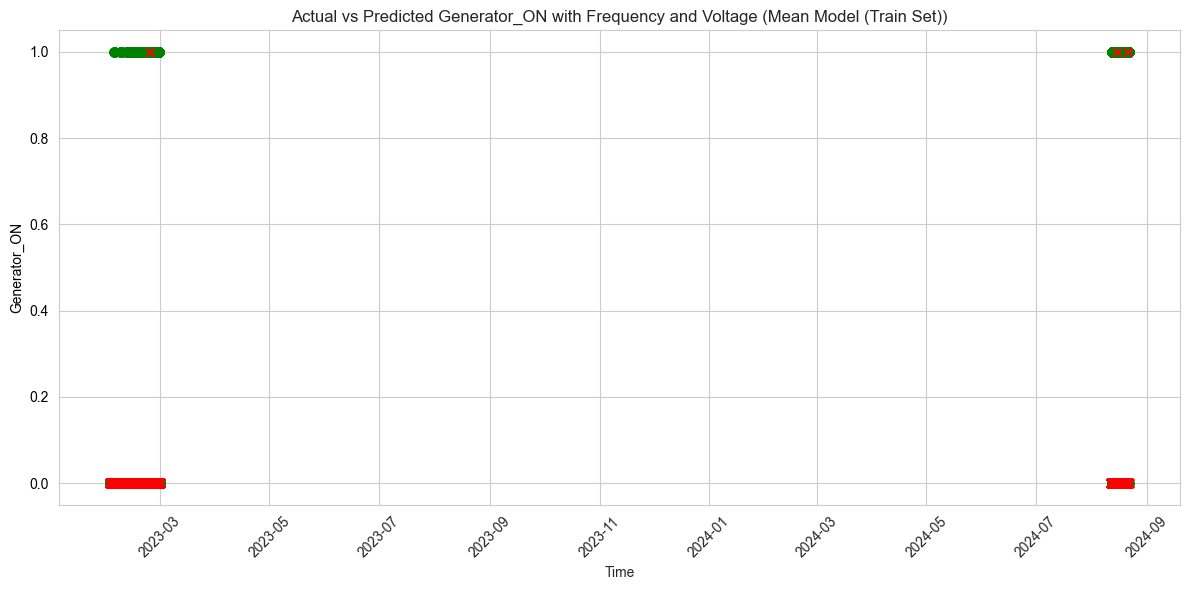

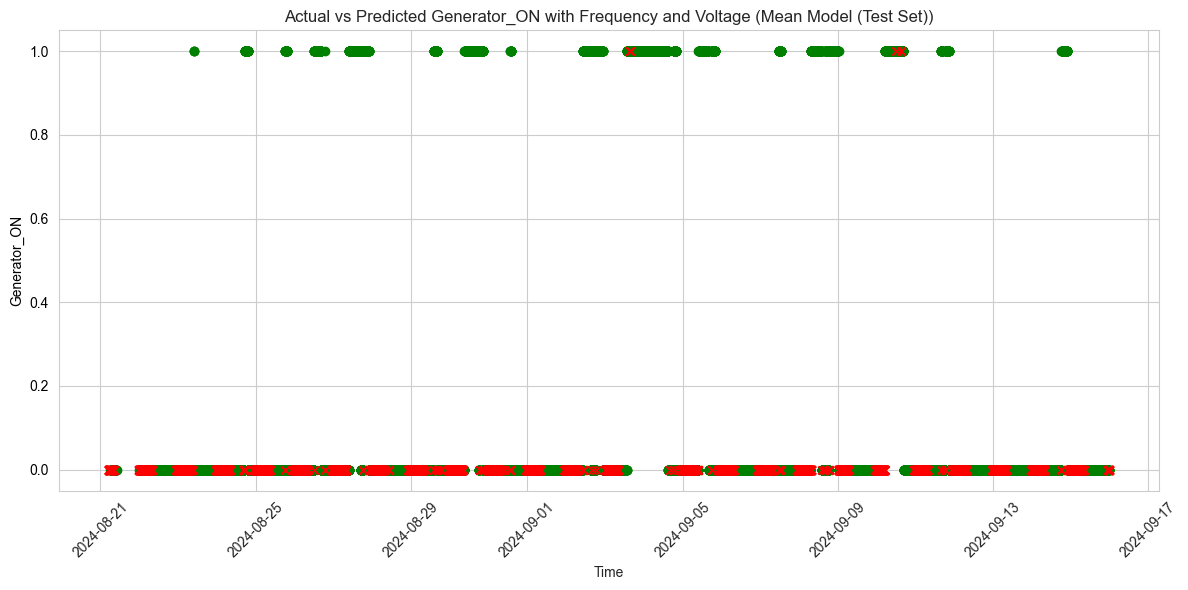

In [32]:
# For Mean Model without frequency
plot_predictions_vs_actuals(train_data_mean, model_name="Mean Model (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_mean, model_name="Mean Model (Test Set)", include_voltage=False, include_frequency=False)

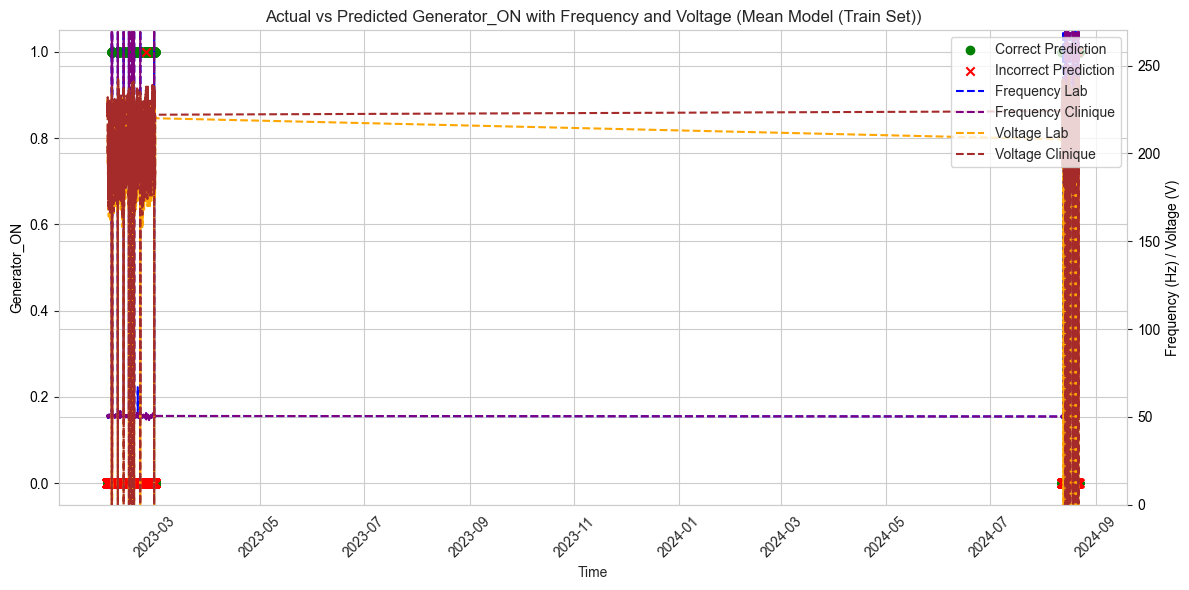

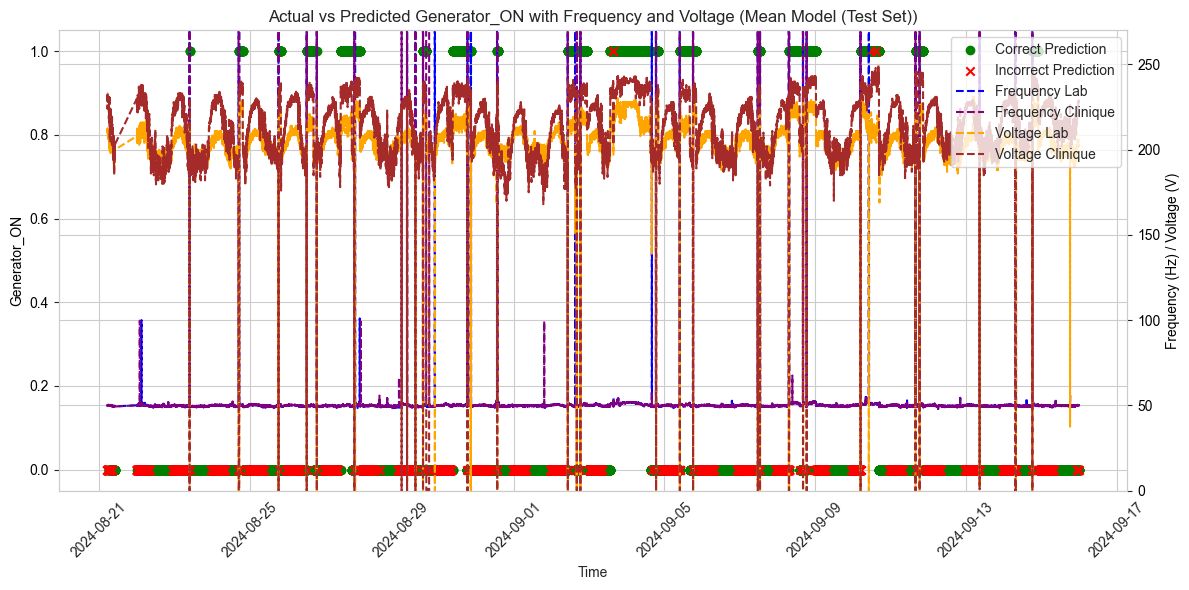

In [33]:
# For Mean Model without frequency
plot_predictions_vs_actuals(train_data_mean, model_name="Mean Model (Train Set)", include_voltage=True, include_frequency=True)
plot_predictions_vs_actuals(test_data_mean, model_name="Mean Model (Test Set)", include_voltage=True, include_frequency=True)

#### 4.1.2. Using Mean as a Threshold - Logistic Regression

In [34]:
# Step 1: Create copies of the original data
train_data_mean_lg = train_data.copy()
test_data_mean_lg = test_data.copy()

# Calculate the mean flags (assuming the function 'calculate_mean_flags' is defined)
train_data_mean_lg, test_data_mean_lg = calculate_mean_flags(train_data_mean_lg, test_data_mean_lg, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_mean_lg[feature_columns]
y_train = train_data_mean_lg['Generator_ON']

X_test = test_data_mean_lg[feature_columns]
y_test = test_data_mean_lg['Generator_ON']

# Fill NaN values in training and testing data with the mean of each column
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use training mean to avoid data leakage

# Step 2: Train a Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_mean_lg['prediction_value'] = reg.predict(X_train)
test_data_mean_lg['prediction_value'] = reg.predict(X_test)

# Optional: Convert predictions to binary form for classification (e.g., threshold at 0.5)
train_data_mean_lg['prediction'] = (train_data_mean_lg['prediction_value'] >= 0.5).astype(int)
test_data_mean_lg['prediction'] = (test_data_mean_lg['prediction_value'] >= 0.5).astype(int)

# Print accuracy for classification interpretation
train_accuracy = accuracy_score(y_train, train_data_mean_lg['prediction'])
test_accuracy = accuracy_score(y_test, test_data_mean_lg['prediction'])

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 0.89
Test Accuracy: 0.91


Evaluating the train set (Logistic Regression): 

In [35]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_mean_lg['prediction'])

print("Train data prediction distribution:")
print(train_data_mean_lg['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 0.8907260435038212
Confusion Matrix:
[[23130    81]
 [ 2893  1112]]
Precision: 0.9321039396479464
Recall: 0.2776529338327091
Train data prediction distribution:
prediction
0    26023
1     1193
Name: count, dtype: int64


Evaluating the test set (Logistic Regression): 

In [36]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_mean_lg['prediction'])

print("Test data prediction distribution:")
print(test_data_mean_lg['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.9118165784832452
Confusion Matrix:
[[14721    97]
 [ 1503  1823]]
Precision: 0.9494791666666667
Recall: 0.5481058328322309
Test data prediction distribution:
prediction
0    16224
1     1920
Name: count, dtype: int64


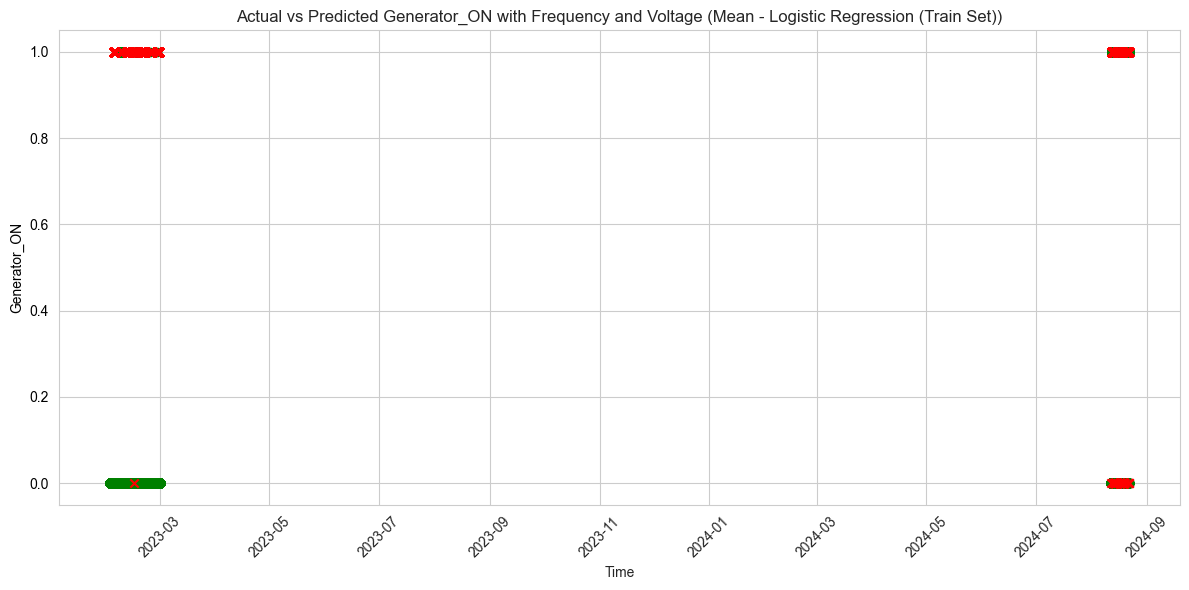

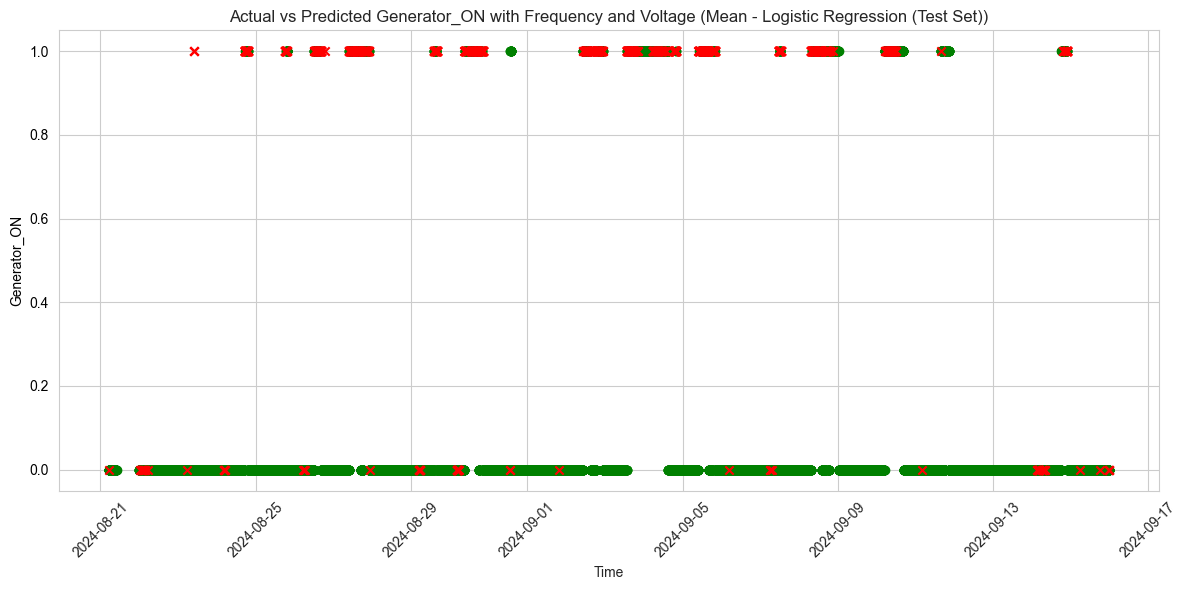

In [37]:
# For Logistic Regression Model with both voltage and frequency
plot_predictions_vs_actuals(train_data_mean_lg, model_name="Mean - Logistic Regression (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_mean_lg, model_name="Mean - Logistic Regression (Test Set)", include_voltage=False, include_frequency=False)

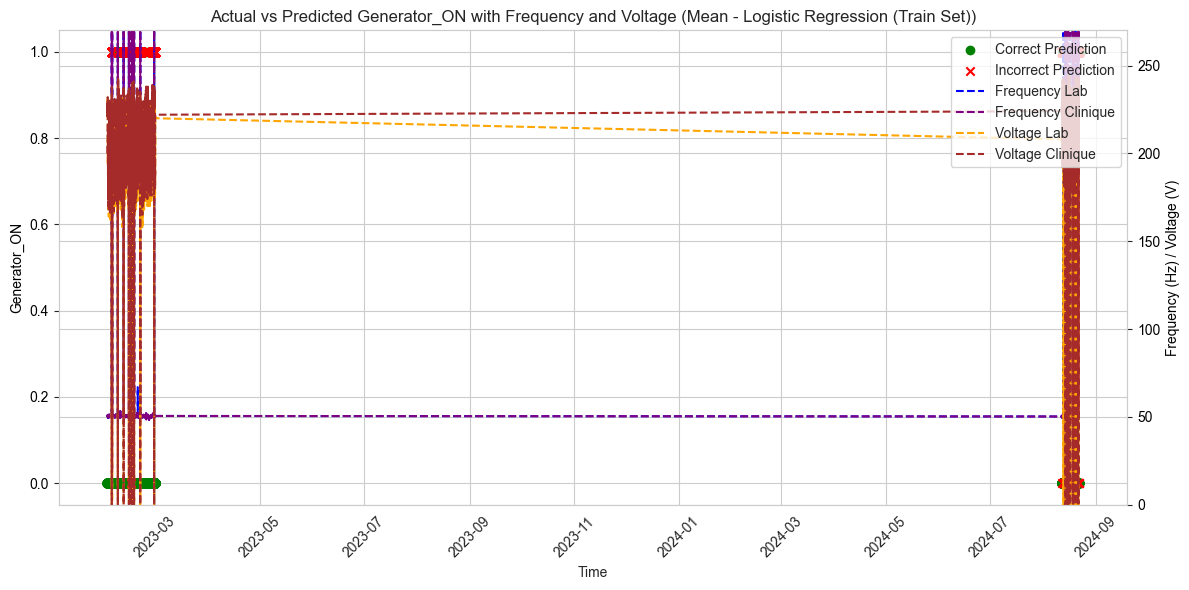

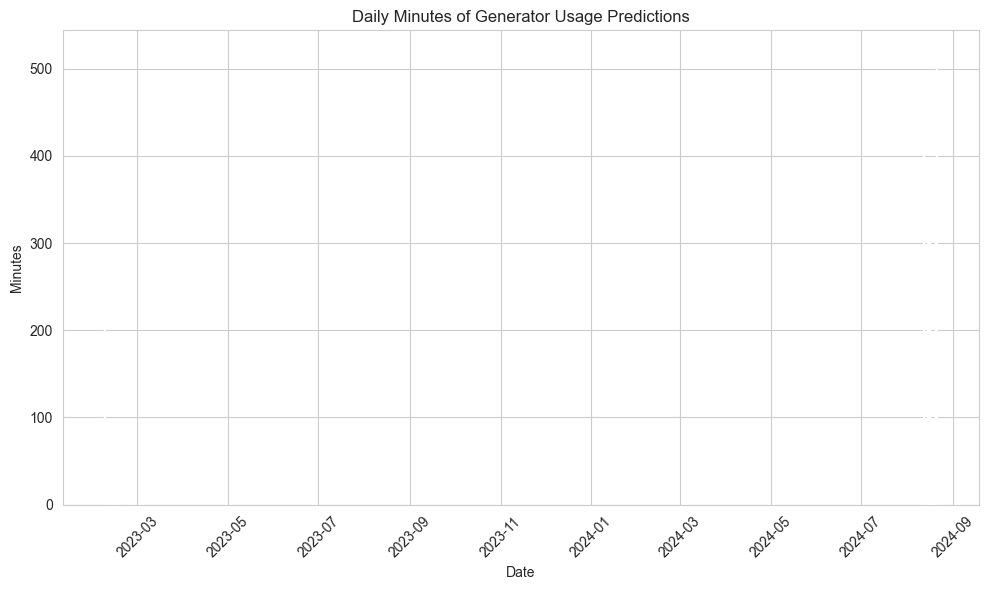

Date  Count  Minutes     Hours
0   2023-02-07    108      216  3.600000
1   2023-02-14      1        2  0.033333
2   2023-02-15      6       12  0.200000
3   2023-02-16      4        8  0.133333
4   2023-02-23      1        2  0.033333
5   2023-02-27      1        2  0.033333
6   2024-08-12    206      412  6.866667
7   2024-08-13     34       68  1.133333
8   2024-08-14     16       32  0.533333
9   2024-08-15    182      364  6.066667
10  2024-08-16    164      328  5.466667
11  2024-08-17     26       52  0.866667
12  2024-08-18     11       22  0.366667
13  2024-08-19     21       42  0.700000
14  2024-08-20    153      306  5.100000
15  2024-08-21    259      518  8.633333

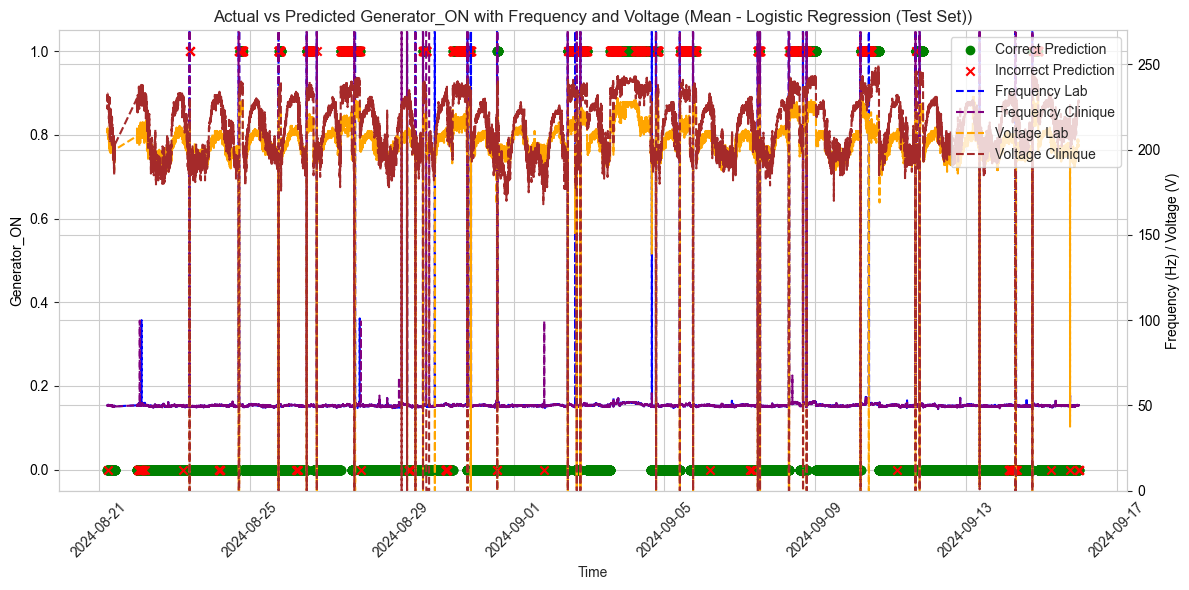

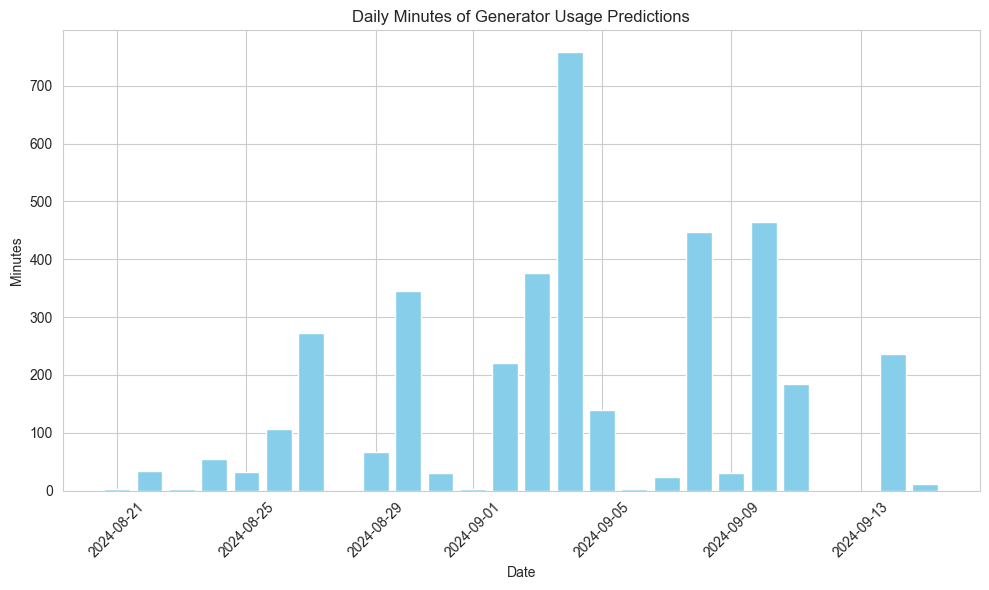

Date  Count  Minutes      Hours
0   2024-08-21      1        2   0.033333
1   2024-08-22     17       34   0.566667
2   2024-08-23      1        2   0.033333
3   2024-08-24     27       54   0.900000
4   2024-08-25     16       32   0.533333
5   2024-08-26     53      106   1.766667
6   2024-08-27    136      272   4.533333
7   2024-08-29     33       66   1.100000
8   2024-08-30    173      346   5.766667
9   2024-08-31     15       30   0.500000
10  2024-09-01      1        2   0.033333
11  2024-09-02    110      220   3.666667
12  2024-09-03    188      376   6.266667
13  2024-09-04    379      758  12.633333
14  2024-09-05     70      140   2.333333
15  2024-09-06      1        2   0.033333
16  2024-09-07     12       24   0.400000
17  2024-09-08    224      448   7.466667
18  2024-09-09     15       30   0.500000
19  2024-09-10    232      464   7.733333
20  2024-09-11     92      184   3.066667
21  2024-09-14    118      236   3.933333
22  2024-09-15      6       12   0.200000

In [38]:
# For Logistic Regression Model
# Train data with both voltage and frequency
plot_predictions_vs_actuals(train_data_mean_lg, model_name="Mean - Logistic Regression (Train Set)", include_voltage=True, include_frequency=True)
train_data_lg_daily_count = plot_true_predictions_histogram(train_data_mean_lg)
display(train_data_lg_daily_count)
# Test data with both voltage and frequency
plot_predictions_vs_actuals(test_data_mean_lg, model_name="Mean - Logistic Regression (Test Set)", include_voltage=True, include_frequency=True)
test_data_lg_daily_count = plot_true_predictions_histogram(test_data_mean_lg)
display(test_data_lg_daily_count)

#### 4.1.3. Using Mean as a Threshold - Random Forrest

In [39]:
# Step 1: Create copies of the original data
train_data_mean_rf = train_data.copy()
test_data_mean_rf = test_data.copy()

# Taking the mean of the dataframe
train_data_mean_rf, test_data_mean_rf = calculate_mean_flags(train_data_mean_rf, test_data_mean_rf, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
       'higher_volt_clinique'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_mean_rf[feature_columns]
y_train = train_data_mean_rf['Generator_ON']

X_test = test_data_mean_rf[feature_columns]
y_test = test_data_mean_rf['Generator_ON']

# Step 2: Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_mean_rf['prediction'] = clf.predict(X_train)
test_data_mean_rf['prediction'] = clf.predict(X_test)

Evaluating the train set (Random Forrest): 

In [40]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_mean_rf['prediction'])

print("Train data prediction distribution:")
print(train_data_mean_rf['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 0.9971340388007055
Confusion Matrix:
[[23189    22]
 [   56  3949]]
Precision: 0.9944598337950139
Recall: 0.9860174781523097
Train data prediction distribution:
prediction
False    23245
True      3971
Name: count, dtype: int64


Evaluating the test set (Random Forrest): 

In [41]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_mean_rf['prediction'])

print("Test data prediction distribution:")
print(test_data_mean_rf['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.9660493827160493
Confusion Matrix:
[[14687   131]
 [  485  2841]]
Precision: 0.9559219380888291
Recall: 0.8541791942273
Test data prediction distribution:
prediction
False    15172
True      2972
Name: count, dtype: int64


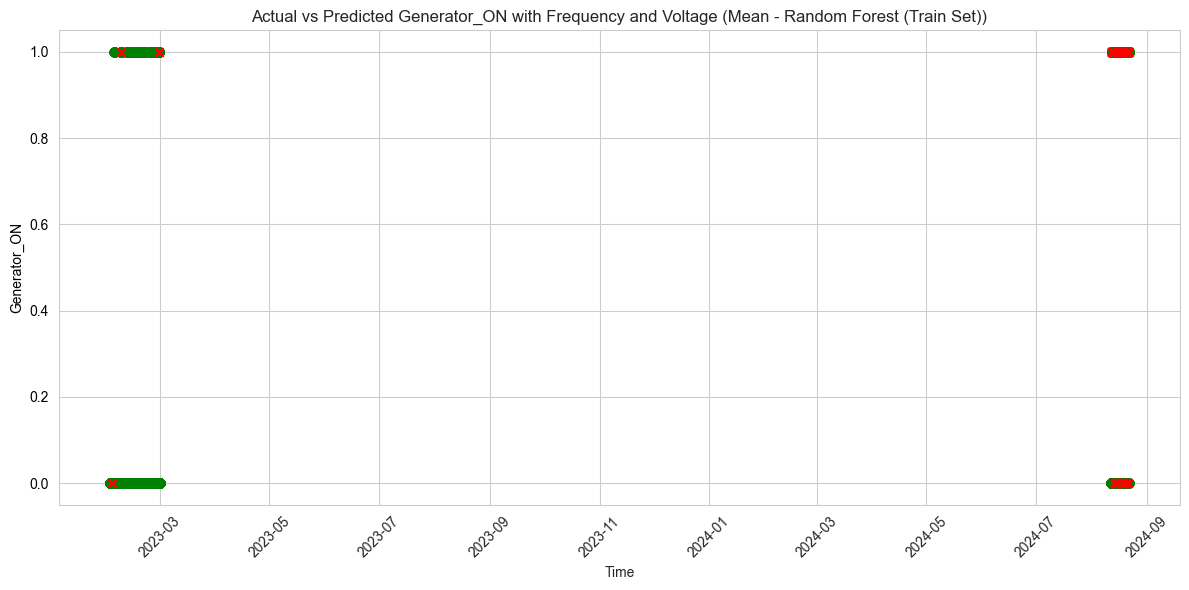

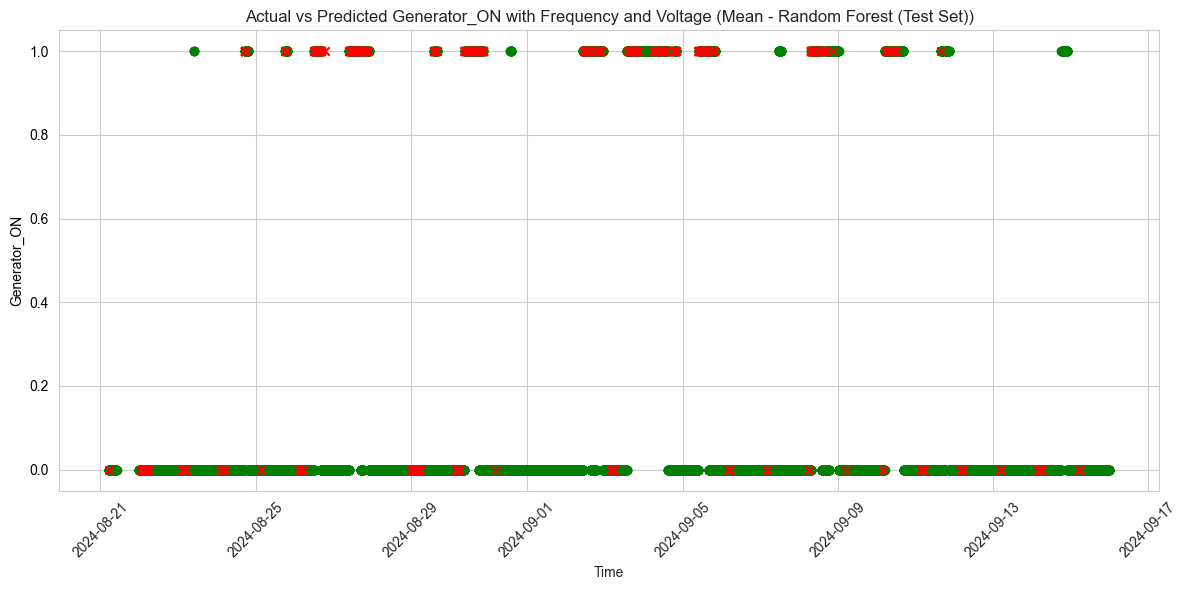

In [42]:
# For Random Forest Model with both voltage and frequency
plot_predictions_vs_actuals(train_data_mean_rf, model_name="Mean - Random Forest (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_mean_rf, model_name="Mean - Random Forest (Test Set)", include_voltage=False, include_frequency=False)

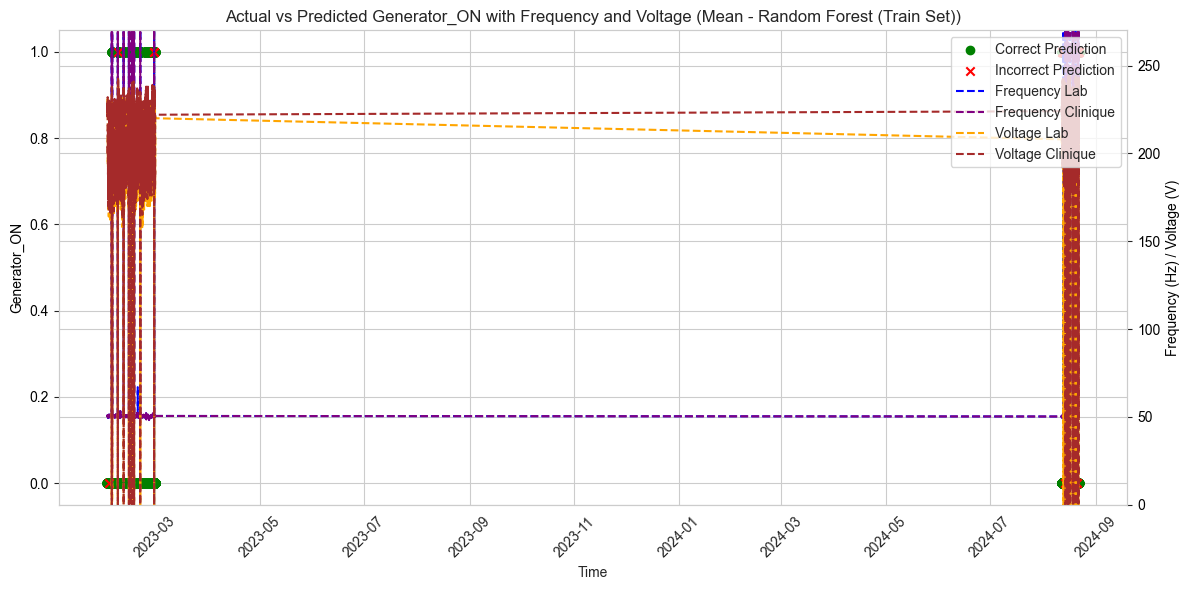

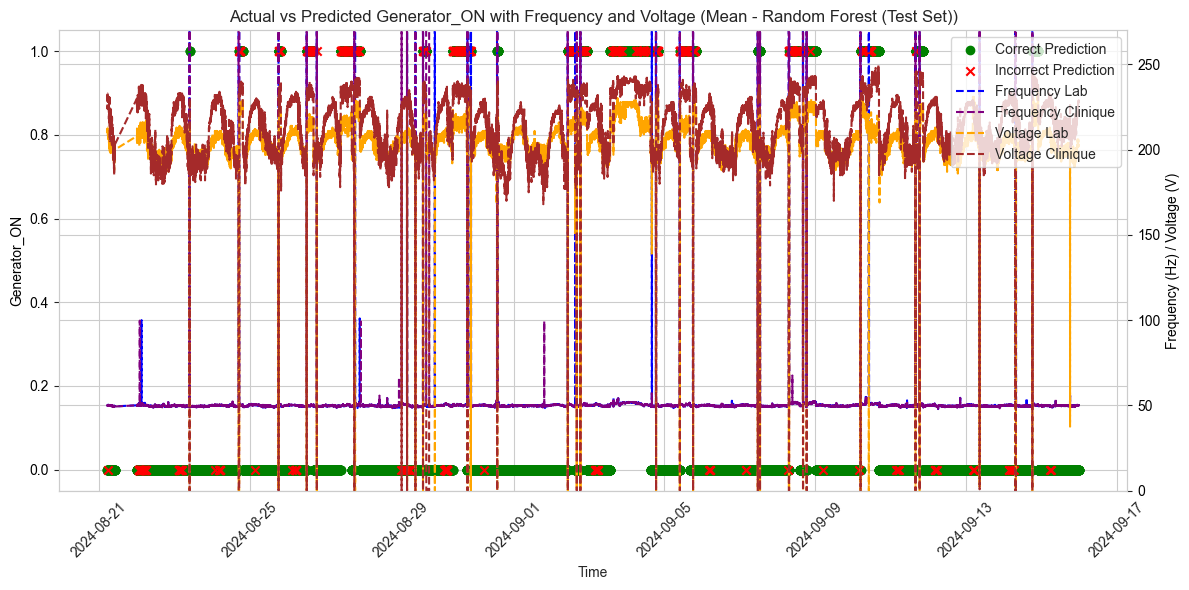

In [43]:
# For Random Forest Model
# Train data with both voltage and frequency
plot_predictions_vs_actuals(train_data_mean_rf, model_name="Mean - Random Forest (Train Set)", include_voltage=True, include_frequency=True)
# Test data with both voltage and frequency
plot_predictions_vs_actuals(test_data_mean_rf, model_name="Mean - Random Forest (Test Set)", include_voltage=True, include_frequency=True)

In [44]:
print(f'##### PREDICTION RESULT #####')
display_generator_statistics(train_data_mean_rf)
display_generator_statistics(test_data_mean_rf)

##### PREDICTION RESULT #####
Actual Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Predicted Minutes: 3971 minutes, or 66.18 hours within 453.60 hours
Actual Minutes: 3326 minutes, or 55.43 hours within 302.40 hours
Predicted Minutes: 2972 minutes, or 49.53 hours within 302.40 hours


#### 4.1.4. Using Mean as a Threshold - XGBoost

/Users/danielsitompul/Documents/GitHub/Generator_ML_Emission_Modeling/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Top 20 features sorted by importance (XGBoost):


Feature  Importance
3  Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - cl...    0.800289
0  Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - ...    0.103421
2  Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - la...    0.057544
1  Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - ...    0.038746
4                                    higher_freq_lab    0.000000
5                               higher_freq_clinique    0.000000
6                                    higher_volt_lab    0.000000
7                               higher_volt_clinique    0.000000

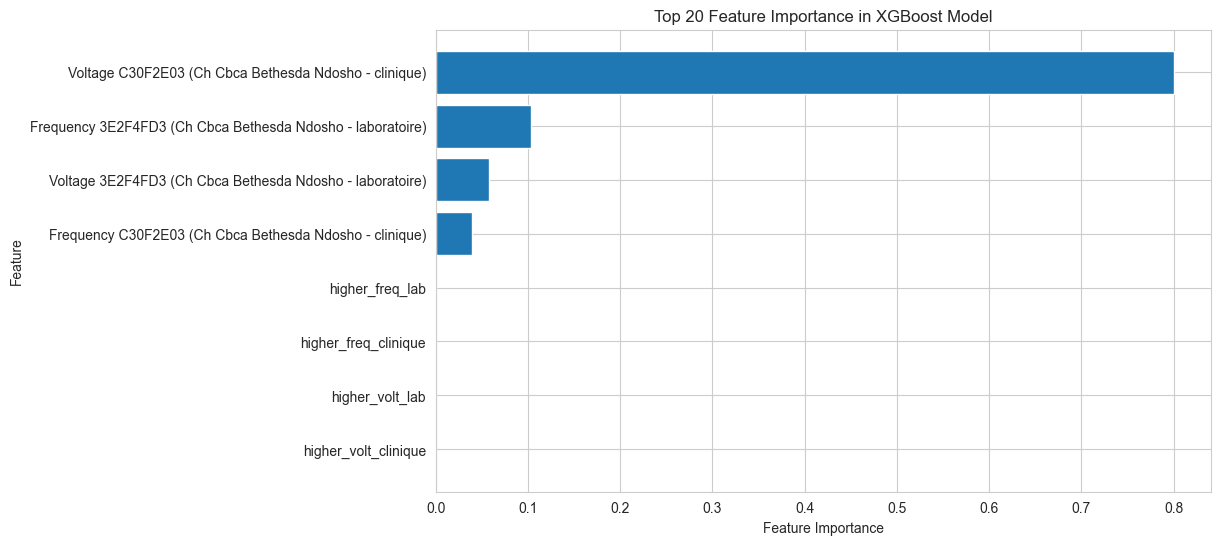

In [45]:
# Step 0: Copy rf data
train_data_mean_boost = train_data.copy()
test_data_mean_boost = test_data.copy()

# Taking the mean of the dataframe (using the previous function)
train_data_mean_boost, test_data_mean_boost = calculate_mean_flags(train_data_mean_boost, test_data_mean_boost, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique'
]


# Step 1: Use the same data and feature columns
X_train = train_data_mean_boost[feature_columns]
y_train = train_data_mean_boost['Generator_ON']

X_test = test_data_mean_boost[feature_columns]
y_test = test_data_mean_boost['Generator_ON']


# Step 2: Train an XGBoost Classifier
xgb_clf = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # Evaluation metric for binary classification
    use_label_encoder=False  # Avoid unnecessary warnings
)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_mean_boost['prediction'] = xgb_clf.predict(X_train)
test_data_mean_boost['prediction'] = xgb_clf.predict(X_test)

# Step 4: Evaluate Feature Importances
importances = xgb_clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the features by importance and keep only the top 20
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top 20 most important features
print("Top 20 features sorted by importance (XGBoost):")
display(top_20_features)

# Visualize the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()

In [46]:
# Step 5: Evaluate Model Performance
# Evaluate on the train set
print("Train Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_train, train_data_mean_boost['prediction'])

print("Train data prediction distribution (XGBoost):")
print(train_data_mean_boost['prediction'].value_counts())

Train Set Evaluation (XGBoost):
Accuracy: 0.9930922986478542
Confusion Matrix:
[[23142    69]
 [  119  3886]]
Precision: 0.9825537294563843
Recall: 0.9702871410736579
Train data prediction distribution (XGBoost):
prediction
0    23261
1     3955
Name: count, dtype: int64


In [47]:
# Step 5: Evaluate Model Performance
# Evaluate on the train set
print("Test Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_test, test_data_mean_boost['prediction'])

print("Test data prediction distribution (XGBoost):")
print(train_data_mean_boost['prediction'].value_counts())

Test Set Evaluation (XGBoost):
Accuracy: 0.9653880070546738
Confusion Matrix:
[[14680   138]
 [  490  2836]]
Precision: 0.9535978480161399
Recall: 0.8526758869512928
Test data prediction distribution (XGBoost):
prediction
0    23261
1     3955
Name: count, dtype: int64


In [48]:
print(f'##### PREDICTION RESULT #####')
display_generator_statistics(train_data_mean_boost)
display_generator_statistics(test_data_mean_boost)

##### PREDICTION RESULT #####
Actual Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Predicted Minutes: 3955 minutes, or 65.92 hours within 453.60 hours
Actual Minutes: 3326 minutes, or 55.43 hours within 302.40 hours
Predicted Minutes: 2974 minutes, or 49.57 hours within 302.40 hours


### 4.2. Generating Time Series Feature

In [49]:
## INITIALIZATION OF CONSTANTS
# Range of reasonable frequency and voltage
high_freq_threshold = 60
low_freq_threshold = 40

high_volt_threshold = 250
low_volt_threshold = 2

voltage_delta = 10

In [50]:
train_data_ts = train_data.copy()
test_data_ts = test_data.copy()

In [51]:
## FEATURE GENERATION
# Using mean to compare
train_data_ts, test_data_ts = calculate_mean_flags(train_data_ts, test_data_ts, train_data_base, columns_to_compare)

# Assuming train_data_ts and test_data_ts are your DataFrames
train_data_ts, test_data_ts = process_time_series_data(train_data_ts, test_data_ts, high_freq_threshold, low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display the processed data
display(train_data_ts)
display(test_data_ts)

Time  \
0     2023-02-01 00:00:00   
1     2023-02-01 00:02:00   
2     2023-02-01 00:04:00   
3     2023-02-01 00:06:00   
4     2023-02-01 00:08:00   
...                   ...   
27211 2024-08-21 05:02:00   
27212 2024-08-21 05:04:00   
27213 2024-08-21 05:06:00   
27214 2024-08-21 05:08:00   
27215 2024-08-21 05:10:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.5            
1                                                   50.6            
2                                                   50.6            
3                                                   50.6            
4                                                   50.5            
...                                                  ...            
27211                                               49.8            
27212                                               49.9            
27213                                               49.8            
27214                                               49.7            
27215                                               49.7            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.4         
1                                                   50.5         
2                                                   50.6         
3                                                   50.5         
4                                                   50.6         
...                                                  ...         
27211                                               49.9         
27212                                               50.0         
27213                                               49.8         
27214                                               49.7         
27215                                               49.8         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  223.0          
1                                                  223.0          
2                                                  223.0          
3                                                  224.0          
4                                                  222.0          
...                                                  ...          
27211                                              213.0          
27212                                              211.0          
27213                                              214.0          
27214                                              211.0          
27215                                              210.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  \
0                                                  223.0             False   
1                                                  224.0             False   
2                                                  224.0             False   
3                                                  225.0             False   
4                                                  224.0             False   
...                                                  ...               ...   
27211                                              233.0             False   
27212                                              233.0             False   
27213                                              233.0             False   
27214                                              232.0             False   
27215                                              232.0             False   

       higher_freq_lab  higher_freq_clinique  higher_volt_lab  \
0                False                 False             True   
1                False                 False             True   
2                False                 False             True   
3                False                 False    

Time  \
27216 2024-08-21 05:12:00   
27217 2024-08-21 05:14:00   
27218 2024-08-21 05:16:00   
27219 2024-08-21 05:18:00   
27220 2024-08-21 05:20:00   
...                   ...   
45355 2024-09-09 09:50:00   
45356 2024-09-09 09:52:00   
45357 2024-09-09 09:54:00   
45358 2024-09-09 09:56:00   
45359 2024-09-09 09:58:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                               50.3            
27217                                               50.1            
27218                                               50.1            
27219                                               50.0            
27220                                               49.6            
...                                                  ...            
45355                                               49.6            
45356                                               49.5            
45357                                               49.7            
45358                                               49.3            
45359                                               49.5            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
27216                                               50.2         
27217                                               50.0         
27218                                               50.0         
27219                                               50.1         
27220                                               49.6         
...                                                  ...         
45355                                               49.5         
45356                                               49.5         
45357                                               49.6         
45358                                               49.3         
45359                                               49.5         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
27216                                              213.0          
27217                                              213.0          
27218                                              210.0          
27219                                              213.0          
27220                                              212.0          
...                                                  ...          
45355                                              194.0          
45356                                              197.0          
45357                                              196.0          
45358                                              196.0          
45359                                              199.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  Generator_ON  \
27216                                              233.0             False   
27217                                              233.0             False   
27218                                              224.0             False   
27219                                              225.0             False   
27220                                              231.0             False   
...                                                  ...               ...   
45355                                              196.0             False   
45356                                              197.0             False   
45357                                              195.0             False   
45358                                              193.0             False   
45359                                              199.0             False   

       higher_freq_lab  higher_freq_clinique  higher_volt_lab  \
27216            False                 False             True   
27217            False                 False             True   
27218            False                 False             True   
27219            False                 False    

In [52]:
train_data_ts.columns

Index(['Time', 'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
       'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
       'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
       'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 'Generator_ON',
       'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
       'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
       'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
       'freq_delta_negative_clinique', 'volt_delta_positive_lab',
       'volt_delta_positive_clinique', 'freq_in_range_lab',
       'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
       'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
       'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
      

#### 4.2.1. Using Mean of Voltage and Frequency as a Threshold and Time Series - Logistic Regression

Train Accuracy: 0.98
Test Accuracy: 0.97
Top 20 features sorted by absolute coefficient value:


/Users/danielsitompul/Documents/GitHub/Generator_ML_Emission_Modeling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature  Coefficient
21                  Hour_1    -5.748383
22                  Hour_2    -5.675688
6          higher_volt_lab     5.537495
20                  Hour_0    -5.068832
18  freq_in_range_clinique    -4.888625
19  volt_in_range_clinique    -4.821619
17       volt_in_range_lab    -4.775569
16       freq_in_range_lab    -4.775330
43                 Hour_23    -4.402210
7     higher_volt_clinique     4.151784
35                 Hour_15     3.549222
36                 Hour_16     3.019287
42                 Hour_22    -2.944759
23                  Hour_3    -2.920893
34                 Hour_14     2.914200
24                  Hour_4    -2.789149
33                 Hour_13     2.456029
32                 Hour_12     2.350382
25                  Hour_5    -2.343044
39                 Hour_19     2.203300

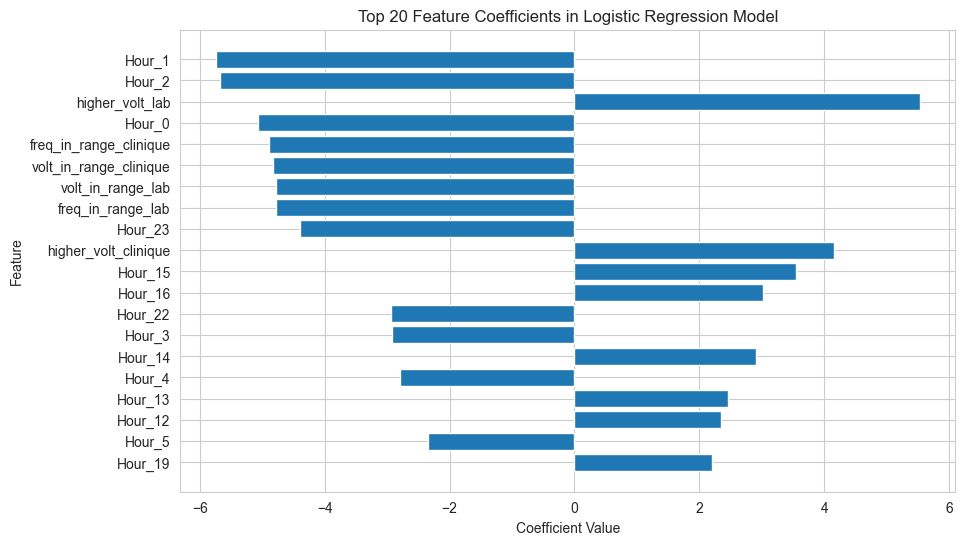

In [53]:

# Step 1: Create copies of the original data
train_data_ts_lg = train_data_ts.copy()
test_data_ts_lg = test_data_ts.copy()

# Calculate the mean flags (assuming the function 'calculate_mean_flags' is defined)
train_data_ts_lg, test_data_ts_lg = calculate_mean_flags(train_data_ts_lg, test_data_ts_lg, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_ts_lg[feature_columns]
y_train = train_data_ts_lg['Generator_ON']

X_test = test_data_ts_lg[feature_columns]
y_test = test_data_ts_lg['Generator_ON']

# Fill NaN values in training and testing data with the mean of each column
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use training mean to avoid data leakage

# Step 2: Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_ts_lg['prediction'] = clf.predict(X_train)
test_data_ts_lg['prediction'] = clf.predict(X_test)

# Print accuracy for classification interpretation
train_accuracy = accuracy_score(y_train, train_data_ts_lg['prediction'])
test_accuracy = accuracy_score(y_test, test_data_ts_lg['prediction'])

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 4: Get the feature coefficients (importance in logistic regression)
coefficients = clf.coef_[0]  # Extract coefficients from the trained model

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coefficients
})

# Sort the features by absolute value of the coefficient and keep the top 20
top_20_features = feature_importance_df.reindex(
    feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index
).head(20)

# Display the top 20 most significant features
print("Top 20 features sorted by absolute coefficient value:")
display(top_20_features)

# Visualize the top 20 feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Feature Coefficients in Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most significant features on top
plt.show()

In [54]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_ts_lg['prediction'])

print("Train data prediction distribution:")
print(train_data_ts_lg['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 0.9761169900058789
Confusion Matrix:
[[22965   246]
 [  404  3601]]
Precision: 0.9360540681050169
Recall: 0.8991260923845193
Train data prediction distribution:
prediction
False    23369
True      3847
Name: count, dtype: int64


In [55]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_ts_lg['prediction'])

print("Test data prediction distribution:")
print(test_data_ts_lg['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.9693562610229277
Confusion Matrix:
[[14783    35]
 [  521  2805]]
Precision: 0.9876760563380281
Recall: 0.8433553818400481
Test data prediction distribution:
prediction
False    15304
True      2840
Name: count, dtype: int64


In [56]:
print(f'##### PREDICTION RESULT #####')
display_generator_statistics(train_data_ts_lg)
display_generator_statistics(test_data_ts_lg)

##### PREDICTION RESULT #####
Actual Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Predicted Minutes: 3847 minutes, or 64.12 hours within 453.60 hours
Actual Minutes: 3326 minutes, or 55.43 hours within 302.40 hours
Predicted Minutes: 2840 minutes, or 47.33 hours within 302.40 hours


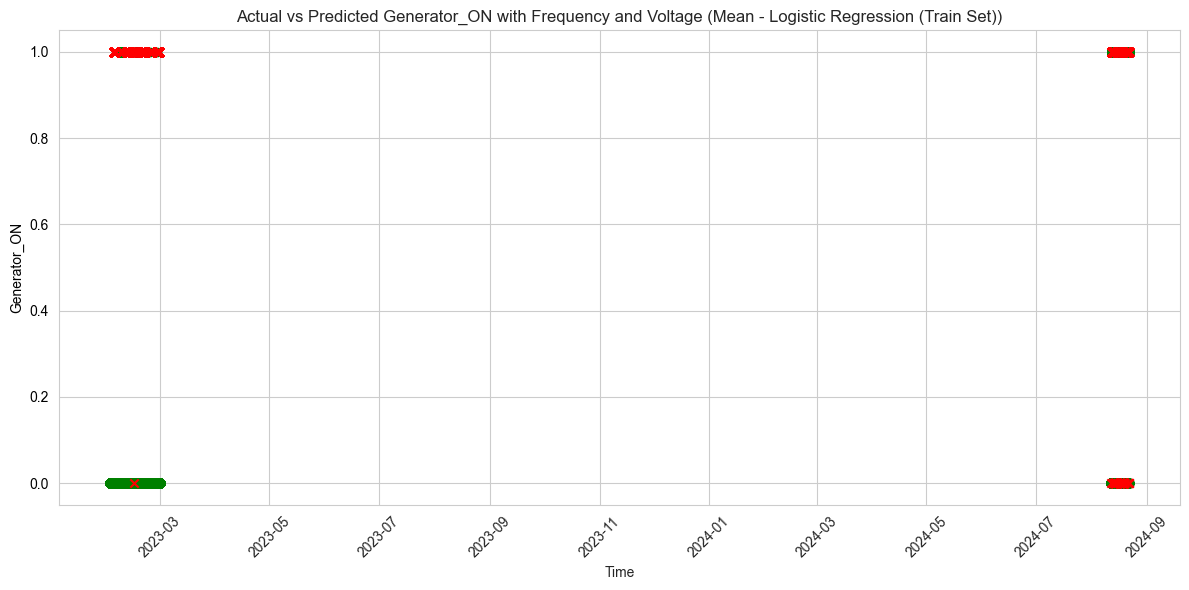

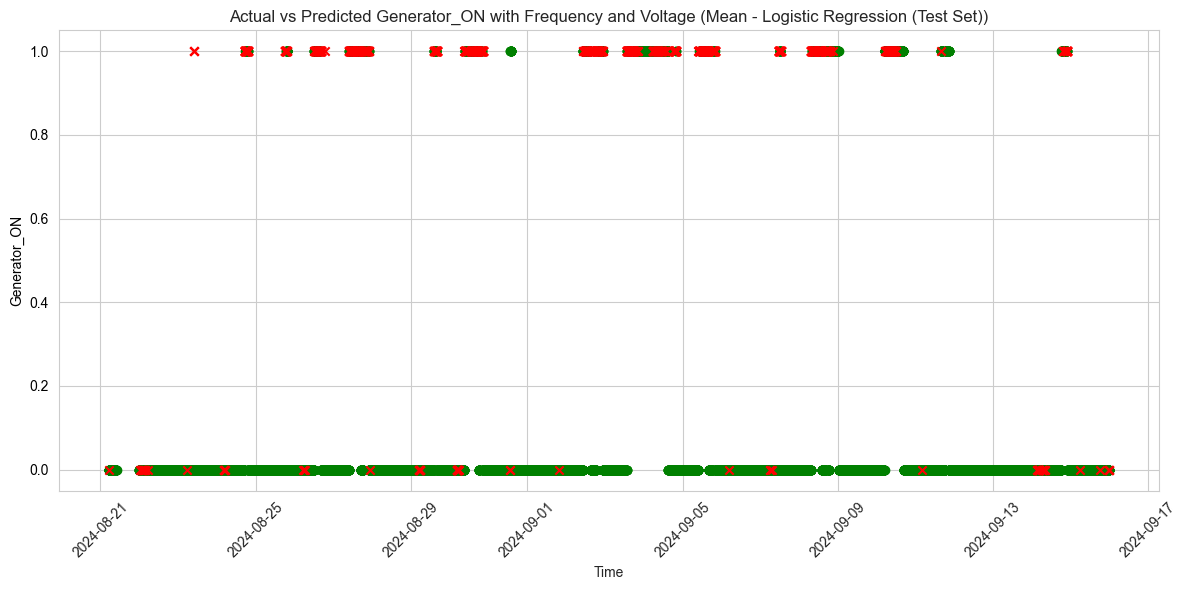

In [57]:
# For Logistic Regression Model with both voltage and frequency
plot_predictions_vs_actuals(train_data_mean_lg, model_name="Mean - Logistic Regression (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_mean_lg, model_name="Mean - Logistic Regression (Test Set)", include_voltage=False, include_frequency=False)

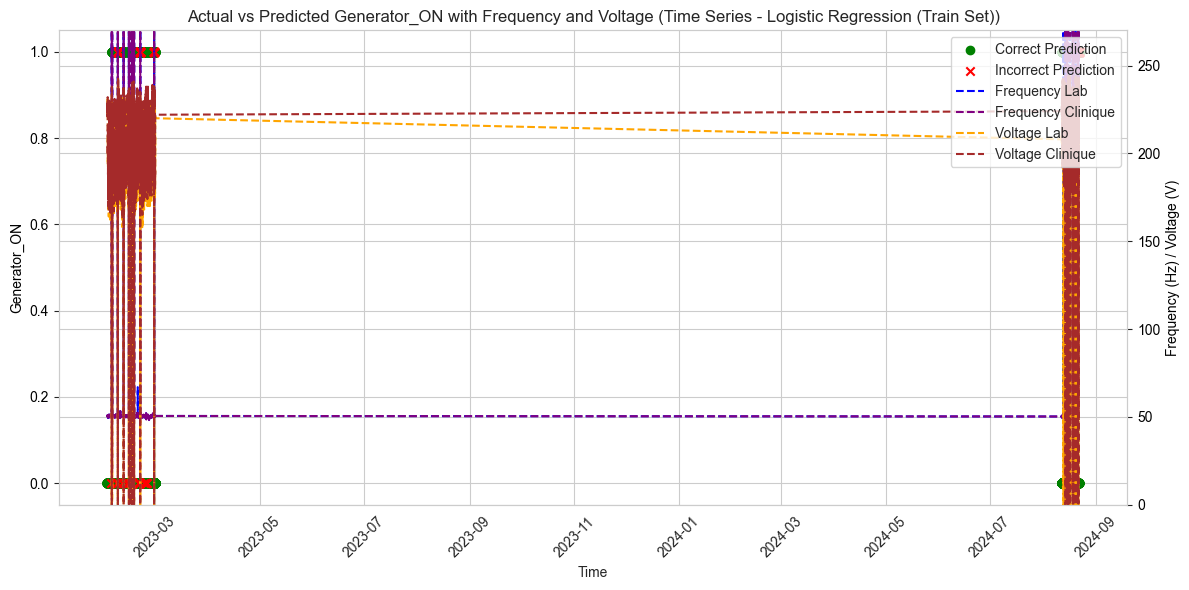

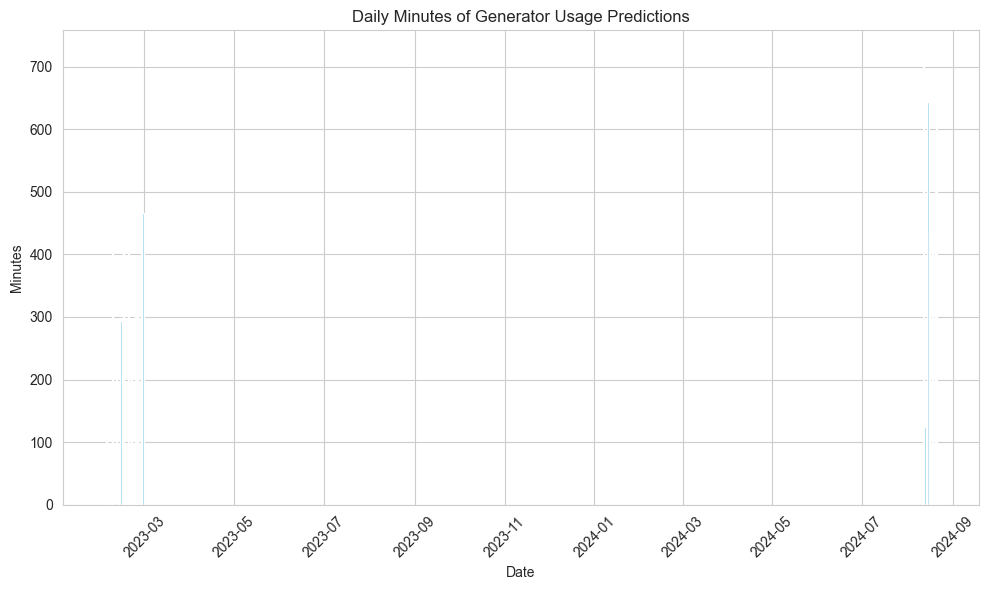

Date  Count  Minutes      Hours
0   2023-02-02      1        2   0.033333
1   2023-02-03     75      150   2.500000
2   2023-02-06      5       10   0.166667
3   2023-02-07    215      430   7.166667
4   2023-02-09      1        2   0.033333
5   2023-02-10    129      258   4.300000
6   2023-02-12      4        8   0.133333
7   2023-02-13    147      294   4.900000
8   2023-02-14      1        2   0.033333
9   2023-02-15    210      420   7.000000
10  2023-02-16     35       70   1.166667
11  2023-02-18    221      442   7.366667
12  2023-02-19     17       34   0.566667
13  2023-02-20    117      234   3.900000
14  2023-02-22      1        2   0.033333
15  2023-02-23    198      396   6.600000
16  2023-02-24    197      394   6.566667
17  2023-02-27    216      432   7.200000
18  2023-02-28    233      466   7.766667
19  2024-08-12    361      722  12.033333
20  2024-08-13     62      124   2.066667
21  2024-08-14      2        4   0.066667
22  2024-08-15    322      644  10.733333
23  2024-08-16    218      436   7.266667
24  2024-08-18    244      488   8.133333
25  2024-08-20    286      572   9.533333
26  2024-08-21    329      658  10.966667

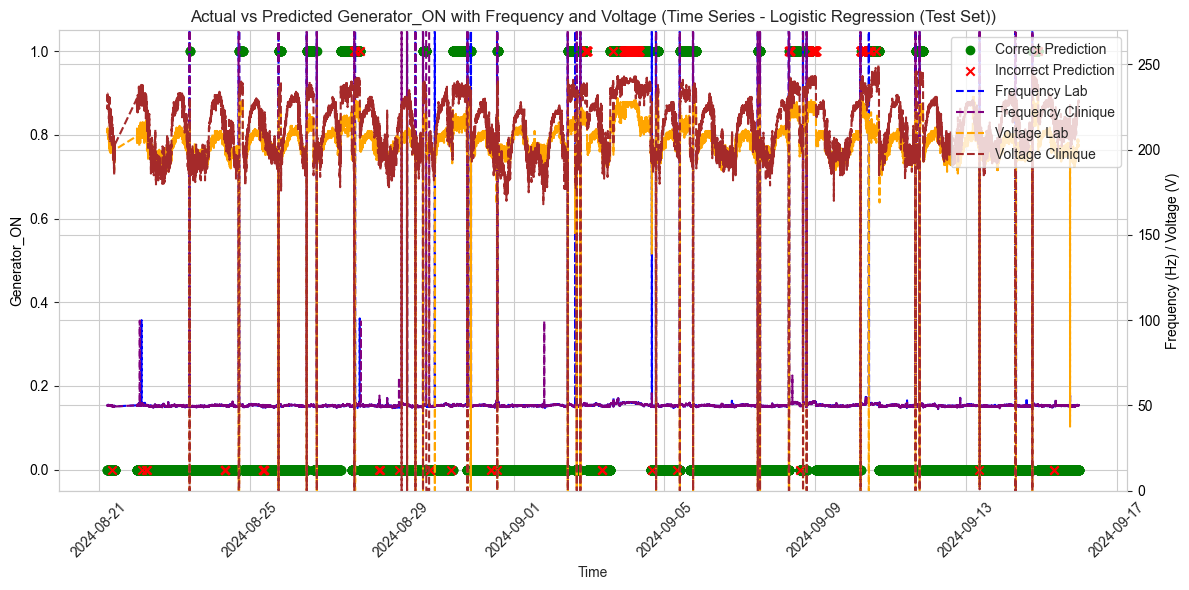

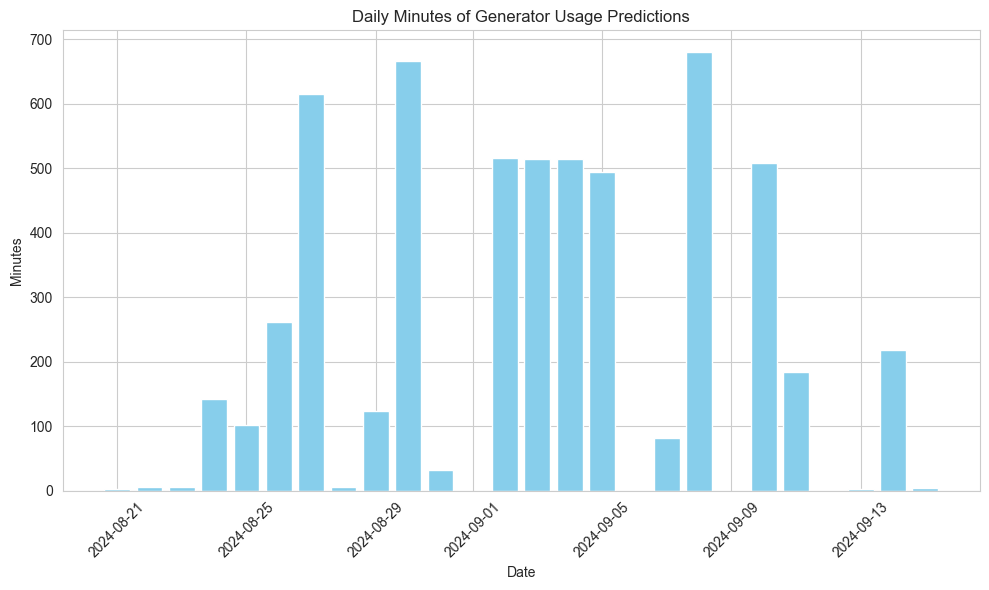

Date  Count  Minutes      Hours
0   2024-08-21      1        2   0.033333
1   2024-08-22      3        6   0.100000
2   2024-08-23      3        6   0.100000
3   2024-08-24     71      142   2.366667
4   2024-08-25     51      102   1.700000
5   2024-08-26    131      262   4.366667
6   2024-08-27    308      616  10.266667
7   2024-08-28      3        6   0.100000
8   2024-08-29     62      124   2.066667
9   2024-08-30    333      666  11.100000
10  2024-08-31     16       32   0.533333
11  2024-09-02    258      516   8.600000
12  2024-09-03    257      514   8.566667
13  2024-09-04    257      514   8.566667
14  2024-09-05    247      494   8.233333
15  2024-09-07     41       82   1.366667
16  2024-09-08    340      680  11.333333
17  2024-09-10    254      508   8.466667
18  2024-09-11     92      184   3.066667
19  2024-09-13      1        2   0.033333
20  2024-09-14    109      218   3.633333
21  2024-09-15      2        4   0.066667

In [58]:
# For Logistic Regression Model
# Train data with both voltage and frequency
plot_predictions_vs_actuals(train_data_ts_lg, model_name="Time Series - Logistic Regression (Train Set)", include_voltage=True, include_frequency=True)
train_data_ts_lg_daily_count = plot_true_predictions_histogram(train_data_ts_lg)
display(train_data_ts_lg_daily_count)
# Test data with both voltage and frequency
plot_predictions_vs_actuals(test_data_ts_lg, model_name="Time Series - Logistic Regression (Test Set)", include_voltage=True, include_frequency=True)
test_data_ts_lg_daily_count = plot_true_predictions_histogram(test_data_ts_lg)
display(test_data_ts_lg_daily_count)

#### 4.2.2. Using Mean of Voltage and Frequency as a Threshold and Time Series - Random Forrest

Top 15 features sorted by importance:


Feature  Importance
3   Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - cl...    0.419528
2   Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - la...    0.148025
0   Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - ...    0.071939
1   Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - ...    0.070741
6                                     higher_volt_lab    0.046275
7                                higher_volt_clinique    0.031487
31                                            Hour_11    0.018083
33                                            Hour_13    0.014285
34                                            Hour_14    0.013974
24                                             Hour_4    0.013622
30                                            Hour_10    0.012227
32                                            Hour_12    0.012071
23                                             Hour_3    0.011392
35                                            Hour_15    0.011162
29                                             Hour_9    0.009964
11                                Volt_delta_clinique    0.008363
10                                     Volt_delta_lab    0.007166
25                                             Hour_5    0.006806
22                                             Hour_2    0.006708
43                                            Hour_23    0.006598
9                                 Freq_delta_clinique    0.005773
8                                      Freq_delta_lab    0.005696
20                                             Hour_0    0.005622
39                                            Hour_19    0.005210
21                                             Hour_1    0.005018
37                                            Hour_17    0.004193
36                                            Hour_16    0.003790
38                                            Hour_18    0.003386
40                                            Hour_20    0.003181
28                                             Hour_8    0.002696
14                            volt_delta_positive_lab    0.001679
15                       volt_delta_positive_clinique    0.001604
12                            freq_delta_negative_lab    0.001380
13                       freq_delta_negative_clinique    0.001279
19                             volt_in_range_clinique    0.001146
5                                higher_freq_clinique    0.001125
49                      Prev_High_delta_freq_clinique    0.001019
41                                            Hour_21    0.000985
42                                            Hour_22    0.000901
26                                             Hour_6    0.000830
4                                     higher_freq_lab    0.000451
18                             freq_in_range_clinique    0.000411
45                           High_delta_freq_clinique    0.000317
27                                             Hour_7    0.000283
48                           Prev_High_delta_freq_lab    0.000235
46                                High_delta_volt_lab    0.000234
17                                  volt_in_range_lab    0.000229
47                           High_delta_volt_clinique    0.000210
16                                  freq_in_range_lab    0.000199
51                      Prev_High_delta_volt_clinique    0.000194

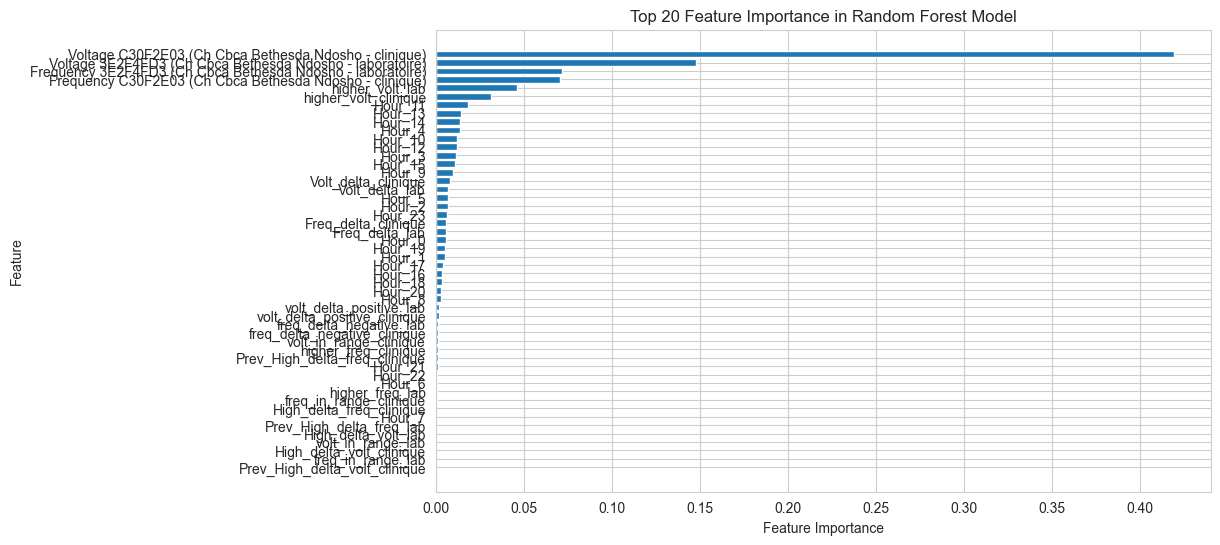

In [59]:
# Step 1: Create copies of the original data
train_data_ts_rf = train_data_ts.copy()
test_data_ts_rf = test_data_ts.copy()

# Taking the mean of the dataframe (using the previous function)
train_data_ts_rf, test_data_ts_rf = calculate_mean_flags(train_data_ts_rf, test_data_ts_rf, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

# Use the selected feature columns to predict 'Generator_ON'
X_train = train_data_ts_rf[feature_columns]
y_train = train_data_ts_rf['Generator_ON']

X_test = test_data_ts_rf[feature_columns]
y_test = test_data_ts_rf['Generator_ON']

# Step 2: Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 3: Make Predictions on the train and test sets
train_data_ts_rf['prediction'] = clf.predict(X_train)
test_data_ts_rf['prediction'] = clf.predict(X_test)

# Step 4: Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the features by importance and keep only the top 10
top_15_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(50)

# Display the top 15 most important features
print("Top 15 features sorted by importance:")
display(top_15_features)

# Visualize the top 15 feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()

Evaluating the train and test set

In [60]:
# Evaluate on the train set
print("Train Set Evaluation:")
evaluate_model_performance_rf(y_train, train_data_ts_rf['prediction'])

print("Train data prediction distribution:")
print(train_data_ts_rf['prediction'].value_counts())

Train Set Evaluation:
Accuracy: 1.0
Confusion Matrix:
[[23211     0]
 [    0  4005]]
Precision: 1.0
Recall: 1.0
Train data prediction distribution:
prediction
False    23211
True      4005
Name: count, dtype: int64


In [61]:
# Evaluate on the test set
print("Test Set Evaluation:")
evaluate_model_performance_rf(y_test, test_data_ts_rf['prediction'])

print("Test data prediction distribution:")
print(test_data_ts_rf['prediction'].value_counts())

Test Set Evaluation:
Accuracy: 0.9933862433862434
Confusion Matrix:
[[14808    10]
 [  110  3216]]
Precision: 0.9969001859888407
Recall: 0.9669272399278412
Test data prediction distribution:
prediction
False    14918
True      3226
Name: count, dtype: int64


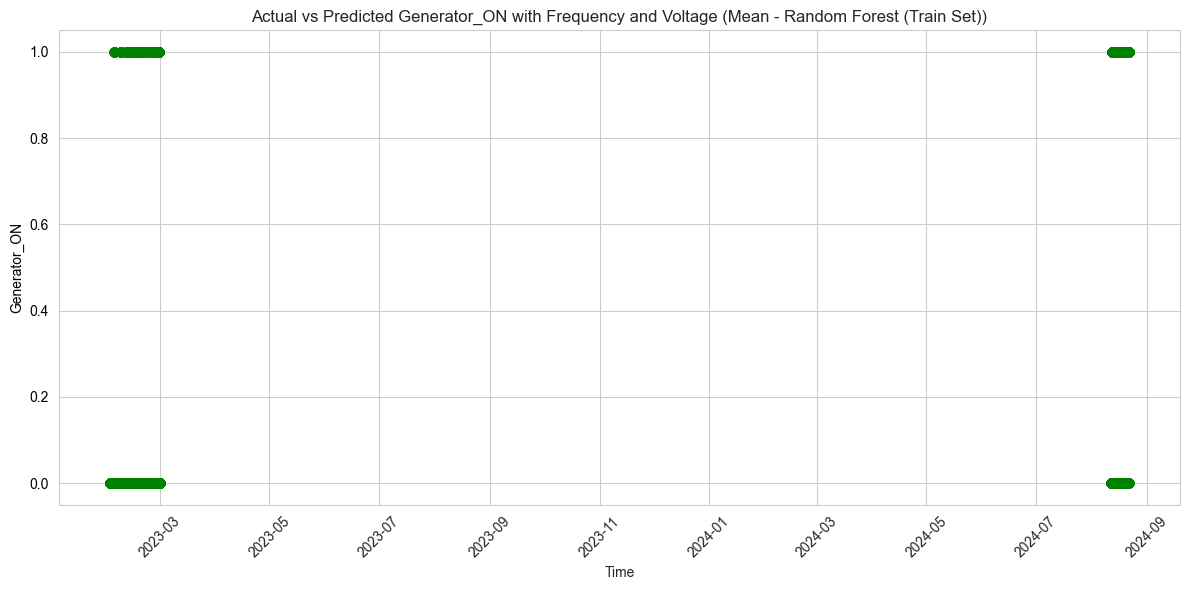

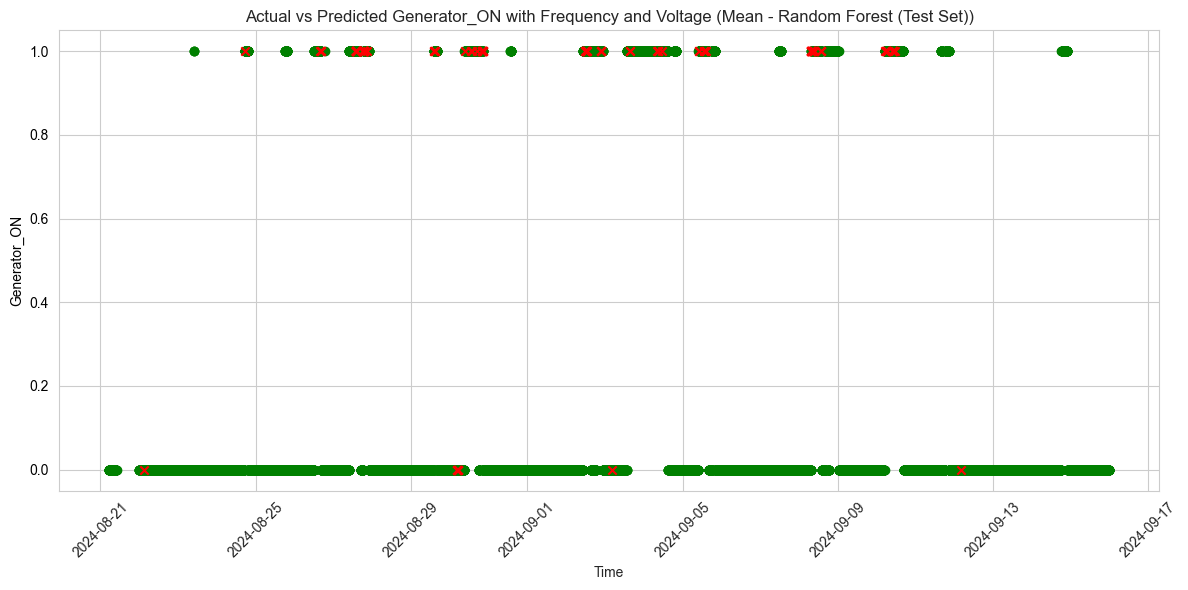

In [62]:
# For Random Forest Model with both voltage and frequency
plot_predictions_vs_actuals(train_data_ts_rf, model_name="Mean - Random Forest (Train Set)", include_voltage=False, include_frequency=False)
plot_predictions_vs_actuals(test_data_ts_rf, model_name="Mean - Random Forest (Test Set)", include_voltage=False, include_frequency=False)

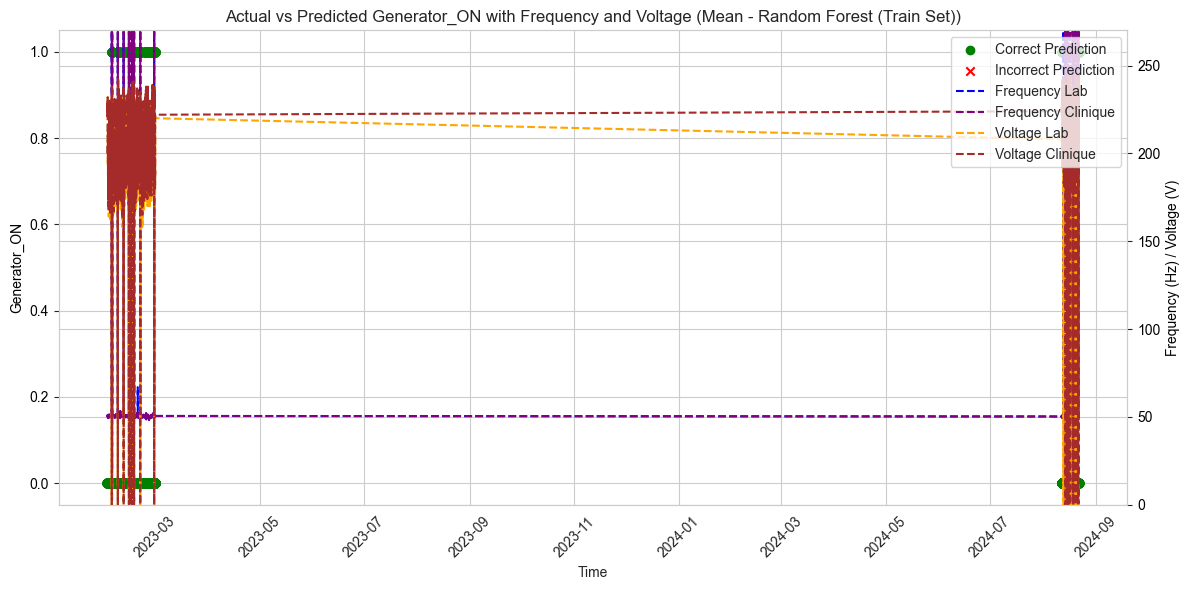

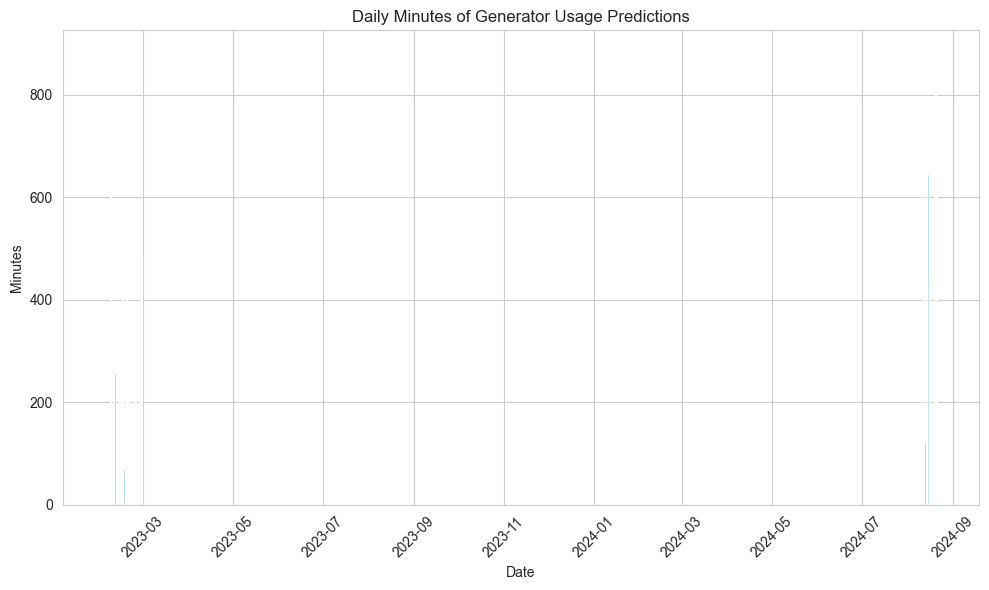

Date  Count  Minutes      Hours
0   2023-02-03     75      150   2.500000
1   2023-02-07    352      704  11.733333
2   2023-02-10    129      258   4.300000
3   2023-02-13    145      290   4.833333
4   2023-02-15    210      420   7.000000
5   2023-02-16     35       70   1.166667
6   2023-02-18    221      442   7.366667
7   2023-02-20    194      388   6.466667
8   2023-02-23    191      382   6.366667
9   2023-02-24    197      394   6.566667
10  2023-02-27    216      432   7.200000
11  2023-02-28    246      492   8.200000
12  2024-08-12    361      722  12.033333
13  2024-08-13     62      124   2.066667
14  2024-08-15    323      646  10.766667
15  2024-08-16    217      434   7.233333
16  2024-08-18     40       80   1.333333
17  2024-08-20    441      882  14.700000
18  2024-08-21    350      700  11.666667

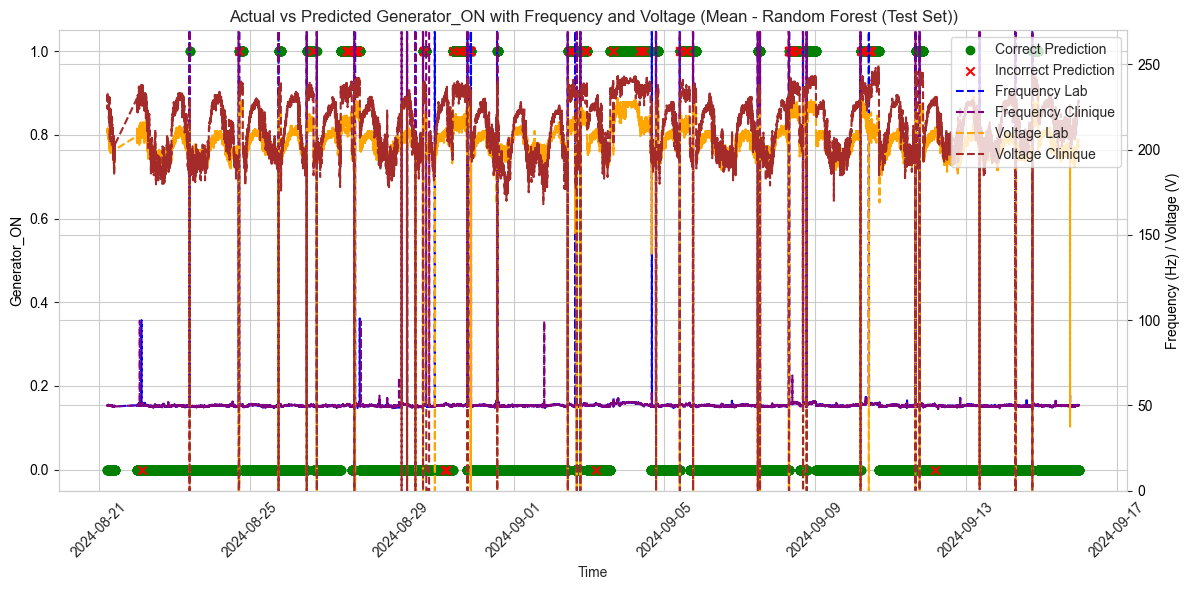

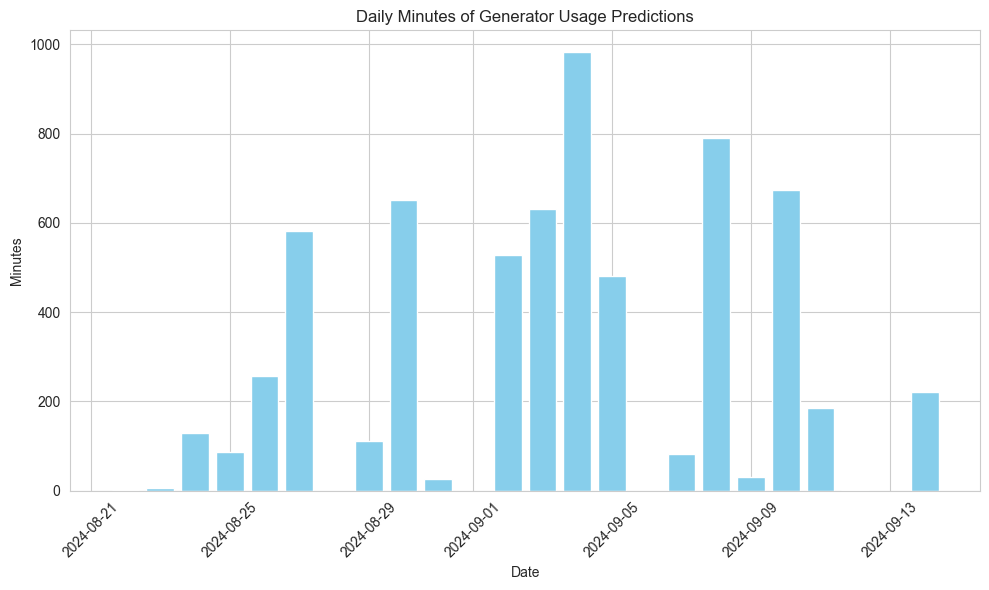

Date  Count  Minutes      Hours
0   2024-08-22      1        2   0.033333
1   2024-08-23      3        6   0.100000
2   2024-08-24     65      130   2.166667
3   2024-08-25     43       86   1.433333
4   2024-08-26    128      256   4.266667
5   2024-08-27    291      582   9.700000
6   2024-08-29     56      112   1.866667
7   2024-08-30    325      650  10.833333
8   2024-08-31     13       26   0.433333
9   2024-09-02    264      528   8.800000
10  2024-09-03    315      630  10.500000
11  2024-09-04    491      982  16.366667
12  2024-09-05    240      480   8.000000
13  2024-09-07     41       82   1.366667
14  2024-09-08    395      790  13.166667
15  2024-09-09     15       30   0.500000
16  2024-09-10    337      674  11.233333
17  2024-09-11     92      184   3.066667
18  2024-09-12      1        2   0.033333
19  2024-09-14    110      220   3.666667

In [63]:
# For Random Forest Model
# Train data with both voltage and frequency
plot_predictions_vs_actuals(train_data_ts_rf, model_name="Mean - Random Forest (Train Set)", include_voltage=True, include_frequency=True)
train_data_ts_rf_daily_count = plot_true_predictions_histogram(train_data_ts_rf)
display(train_data_ts_rf_daily_count)
# Test data with both voltage and frequency
plot_predictions_vs_actuals(test_data_ts_rf, model_name="Mean - Random Forest (Test Set)", include_voltage=True, include_frequency=True)
test_data_ts_rf_daily_count = plot_true_predictions_histogram(test_data_ts_rf)
display(test_data_ts_rf_daily_count)

In [64]:
train_data_ts_rf['Generator_ON'].dtype

dtype('bool')

In [65]:
print(f'##### PREDICTION RESULT #####')
display_generator_statistics(train_data_ts_rf)
display_generator_statistics(test_data_ts_rf)

##### PREDICTION RESULT #####
Actual Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Predicted Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Actual Minutes: 3326 minutes, or 55.43 hours within 302.40 hours
Predicted Minutes: 3226 minutes, or 53.77 hours within 302.40 hours


#### 4.2.3. Using Mean of Voltage and Frequency as a Threshold and Time Series - XGBoost

In [66]:
# Step 0: Copy rf data
train_data_ts_boost = train_data_ts.copy()
test_data_ts_boost = test_data_ts.copy()

# Taking the mean of the dataframe (using the previous function)
train_data_ts_boost, test_data_ts_boost = calculate_mean_flags(train_data_ts_boost, test_data_ts_boost, train_data_base, columns_to_compare)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]


# Step 1: Use the same data and feature columns
X_train = train_data_ts_boost[feature_columns]
y_train = train_data_ts_boost['Generator_ON']

X_test = test_data_ts_boost[feature_columns]
y_test = test_data_ts_boost['Generator_ON']

X_train['Prev_High_delta_freq_lab'] = pd.to_numeric(X_train['Prev_High_delta_freq_lab'], errors='coerce')
X_train['Prev_High_delta_freq_clinique'] = pd.to_numeric(X_train['Prev_High_delta_freq_clinique'], errors='coerce')
X_train['Prev_High_delta_volt_lab'] = pd.to_numeric(X_train['Prev_High_delta_volt_lab'], errors='coerce')
X_train['Prev_High_delta_volt_clinique'] = pd.to_numeric(X_train['Prev_High_delta_volt_clinique'], errors='coerce')

X_test['Prev_High_delta_freq_lab'] = pd.to_numeric(X_test['Prev_High_delta_freq_lab'], errors='coerce')
X_test['Prev_High_delta_freq_clinique'] = pd.to_numeric(X_test['Prev_High_delta_freq_clinique'], errors='coerce')
X_test['Prev_High_delta_volt_lab'] = pd.to_numeric(X_test['Prev_High_delta_volt_lab'], errors='coerce')
X_test['Prev_High_delta_volt_clinique'] = pd.to_numeric(X_test['Prev_High_delta_volt_clinique'], errors='coerce')


# Step 2: Train an XGBoost Classifier
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Adjust based on your metric
    cv=3,               # Cross-validation splits
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_15518/4294022351.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Prev_High_delta_freq_lab'] = pd.to_numeric(X_train['Prev_High_delta_freq_lab'], errors='coerce')
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_15518/4294022351.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Prev_High_delta_freq_clinique'] = pd.to_numeric(X_train['Prev_High_delta_freq_clinique'], errors='coerce')
/var/folders/7q/629hmk5n2d38m2bb

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [68]:
# Step 3: Make Predictions on the train and test sets
train_data_ts_boost['prediction'] = xgb_clf.predict(X_train)
test_data_ts_boost['prediction'] = xgb_clf.predict(X_test)

# Step 4: Evaluate Feature Importances
importances = xgb_clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the features by importance and keep only the top 20
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top 20 most important features
print("Top 20 features sorted by importance (XGBoost):")
display(top_20_features)

# Visualize the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()

ValueError: Feature shape mismatch, expected: 8, got 52

In [59]:
# Use the best parameters from GridSearchCV
best_params = {
    'colsample_bytree': 0.6,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 1.0
}

# Initialize the model with the best parameters
final_model = XGBClassifier(
    random_state=42,
    **best_params
)

# Fit the model on the entire training data
final_model.fit(X_train, y_train)

# Make predictions on the test set
train_data_ts_boost['prediction'] = final_model.predict(X_train)
test_data_ts_boost['prediction'] = final_model.predict(X_test)

# Evaluate the model on the test set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Classification report
print("Classification Report:")
print(classification_report(y_test, test_data_ts_boost['prediction']))

# AUC-ROC score
print("AUC-ROC Score:")
y_test_proba = final_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_test_proba))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_data_ts_boost['prediction']))

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     14818
        True       1.00      0.97      0.98      3326

    accuracy                           0.99     18144
   macro avg       0.99      0.99      0.99     18144
weighted avg       0.99      0.99      0.99     18144

AUC-ROC Score:
0.9994967298957964
Confusion Matrix:
[[14802    16]
 [   93  3233]]


In [60]:
# Step 5: Evaluate Model Performance
# Evaluate on the train set
print("Train Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_train, train_data_ts_boost['prediction'])

print("Train data prediction distribution (XGBoost):")
print(train_data_ts_boost['prediction'].value_counts())

Train Set Evaluation (XGBoost):
Accuracy: 0.9963624338624338
Confusion Matrix:
[[23138    73]
 [   26  3979]]
Precision: 0.9819842053307009
Recall: 0.9935081148564294
Train data prediction distribution (XGBoost):
prediction
0    23164
1     4052
Name: count, dtype: int64


In [61]:
# Evaluate on the test set
print("\nTest Set Evaluation (XGBoost):")
evaluate_model_performance_rf(y_test, test_data_ts_boost['prediction'])

print("Test data prediction distribution (XGBoost):")
print(test_data_ts_boost['prediction'].value_counts())


Test Set Evaluation (XGBoost):
Accuracy: 0.9939925044091711
Confusion Matrix:
[[14802    16]
 [   93  3233]]
Precision: 0.9950754078177901
Recall: 0.9720384846662657
Test data prediction distribution (XGBoost):
prediction
0    14895
1     3249
Name: count, dtype: int64


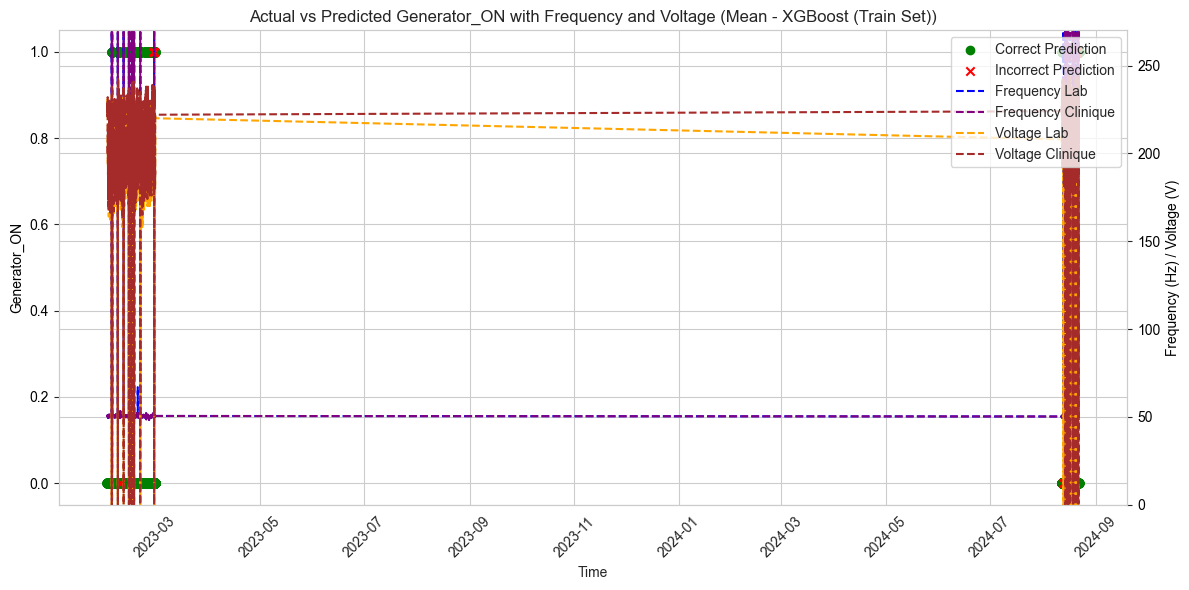

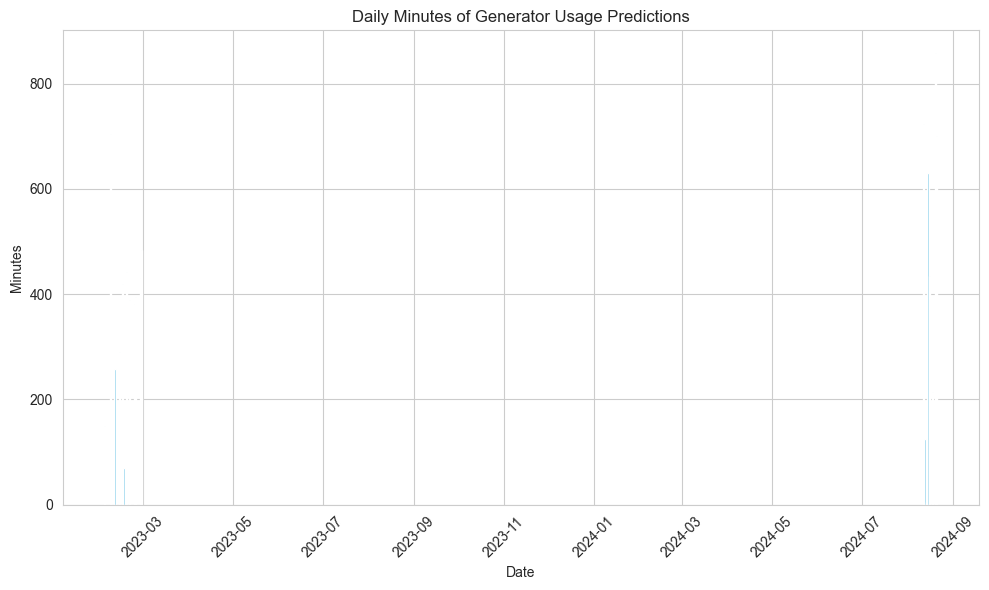

Date  Count  Minutes      Hours
0   2023-02-03     75      150   2.500000
1   2023-02-07    352      704  11.733333
2   2023-02-08      1        2   0.033333
3   2023-02-10    129      258   4.300000
4   2023-02-13    145      290   4.833333
5   2023-02-15    210      420   7.000000
6   2023-02-16     35       70   1.166667
7   2023-02-18    221      442   7.366667
8   2023-02-20    194      388   6.466667
9   2023-02-23    191      382   6.366667
10  2023-02-24    197      394   6.566667
11  2023-02-27    215      430   7.166667
12  2023-02-28    242      484   8.066667
13  2024-08-12    362      724  12.066667
14  2024-08-13     62      124   2.066667
15  2024-08-14      3        6   0.100000
16  2024-08-15    315      630  10.500000
17  2024-08-16    217      434   7.233333
18  2024-08-18    107      214   3.566667
19  2024-08-20    429      858  14.300000
20  2024-08-21    350      700  11.666667

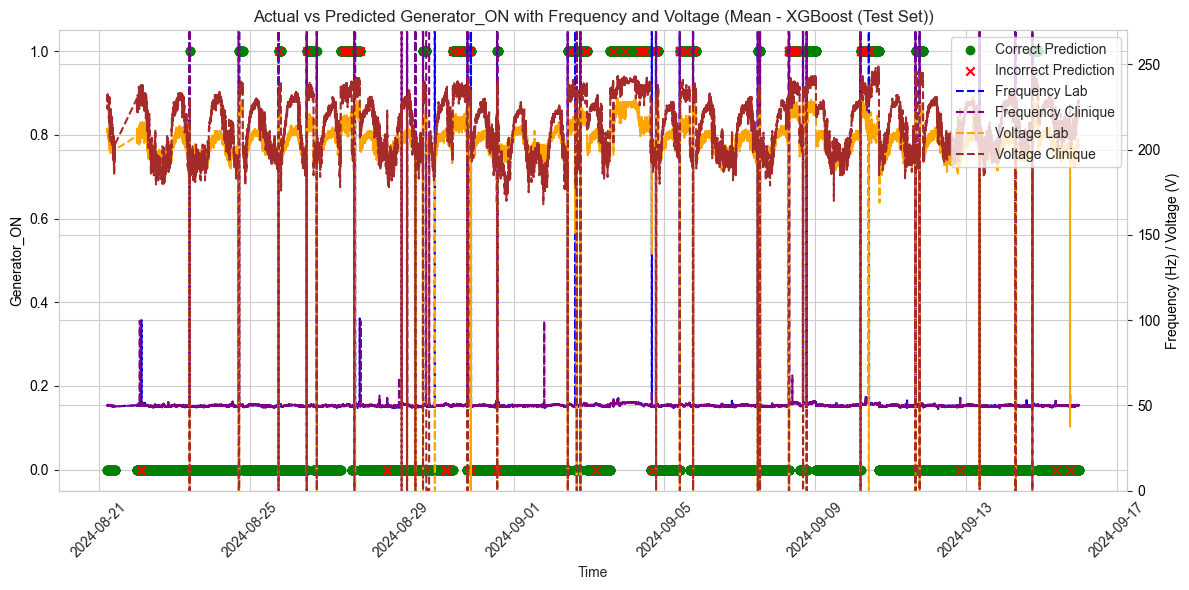

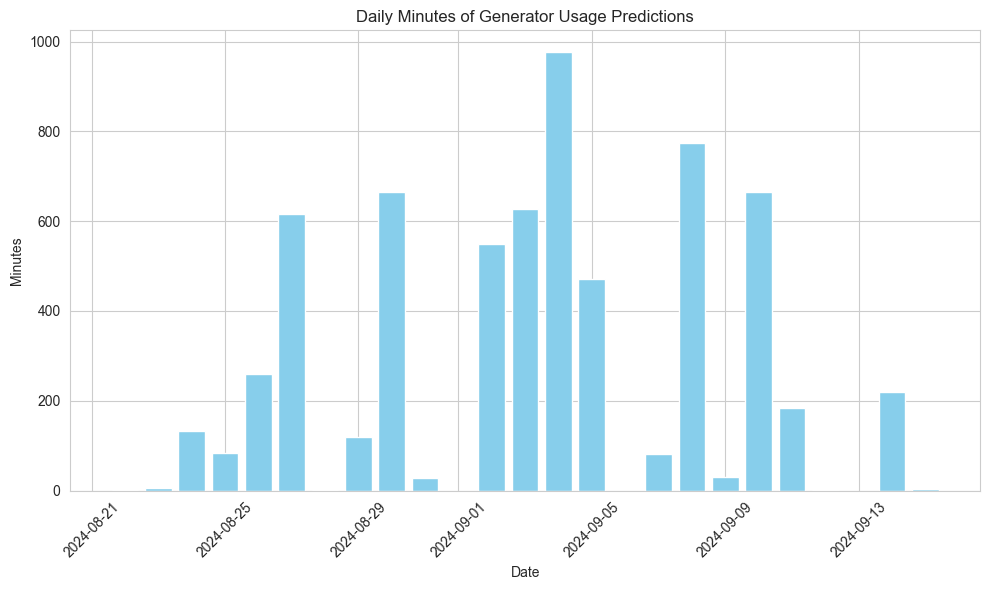

Date  Count  Minutes      Hours
0   2024-08-22      1        2   0.033333
1   2024-08-23      3        6   0.100000
2   2024-08-24     66      132   2.200000
3   2024-08-25     42       84   1.400000
4   2024-08-26    130      260   4.333333
5   2024-08-27    308      616  10.266667
6   2024-08-28      1        2   0.033333
7   2024-08-29     60      120   2.000000
8   2024-08-30    332      664  11.066667
9   2024-08-31     14       28   0.466667
10  2024-09-02    274      548   9.133333
11  2024-09-03    314      628  10.466667
12  2024-09-04    488      976  16.266667
13  2024-09-05    236      472   7.866667
14  2024-09-07     41       82   1.366667
15  2024-09-08    387      774  12.900000
16  2024-09-09     15       30   0.500000
17  2024-09-10    332      664  11.066667
18  2024-09-11     92      184   3.066667
19  2024-09-12      1        2   0.033333
20  2024-09-14    110      220   3.666667
21  2024-09-15      2        4   0.066667

In [62]:
# For Boosting Model
# Train data with both voltage and frequency
plot_predictions_vs_actuals(train_data_ts_boost, model_name="Mean - XGBoost (Train Set)", include_voltage=True, include_frequency=True)
train_data_ts_boost_daily_count = plot_true_predictions_histogram(train_data_ts_boost)
display(train_data_ts_boost_daily_count)
# Test data with both voltage and frequency
plot_predictions_vs_actuals(test_data_ts_boost, model_name="Mean - XGBoost (Test Set)", include_voltage=True, include_frequency=True)
test_data_ts_boost_daily_count = plot_true_predictions_histogram(test_data_ts_boost)
display(test_data_ts_boost_daily_count)

In [63]:
print(f'##### PREDICTION RESULT #####')
display_generator_statistics(train_data_ts_boost)
display_generator_statistics(test_data_ts_boost)

##### PREDICTION RESULT #####
Actual Minutes: 4005 minutes, or 66.75 hours within 453.60 hours
Predicted Minutes: 4052 minutes, or 67.53 hours within 453.60 hours
Actual Minutes: 3326 minutes, or 55.43 hours within 302.40 hours
Predicted Minutes: 3249 minutes, or 54.15 hours within 302.40 hours


## 5. Applying the Model with Other Data

#### 5.1. Using 1 Month Data and Check the Prediction Result

In [52]:
# Opening files
file_list = ['Voltage Time Series-data-2024-10-25 13_13_06.csv',  
             'Voltage Time Series-data-2024-10-25 13_13_40.csv', 
             'Voltage Time Series-data-2024-10-25 13_14_12.csv',
             'Voltage Time Series-data-2024-10-25 13_14_37.csv',
             'Voltage Time Series-data-2024-10-25 13_18_07.csv']

# Initialize an empty list to collect DataFrames
data_frames_2 = []

file_path_2 = '/Users/danielsitompul/Documents/0. Fall 2024/2. DEVENG 205 - Development Engineering Applications/2. ML Model/pythonProject/data/New 2/'

for file in file_list:
    # Read each file into a DataFrame and append to the list
    monthly_data = pd.read_csv(file_path_2 + file)
    data_frames_2.append(monthly_data)

# Concatenate all DataFrames in the list at once
data = pd.concat(data_frames_2, ignore_index=True)

# Display the final concatenated DataFrame
display(data)

Time  \
0      2024-09-10 00:00:00   
1      2024-09-10 00:02:00   
2      2024-09-10 00:04:00   
3      2024-09-10 00:06:00   
4      2024-09-10 00:08:00   
...                    ...   
25195  2024-10-14 23:50:00   
25196  2024-10-14 23:52:00   
25197  2024-10-14 23:54:00   
25198  2024-10-14 23:56:00   
25199  2024-10-14 23:58:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.1            
1                                                   49.8            
2                                                   49.7            
3                                                   49.8            
4                                                   49.9            
...                                                  ...            
25195                                               50.1            
25196                                               49.6            
25197                                               49.8            
25198                                               49.9            
25199                                               50.0            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.0         
1                                                   49.8         
2                                                   49.7         
3                                                   49.8         
4                                                   50.0         
...                                                  ...         
25195                                               50.0         
25196                                               49.6         
25197                                               49.8         
25198                                               49.9         
25199                                               49.9         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  207.0          
1                                                  203.0          
2                                                  202.0          
3                                                  204.0          
4                                                  204.0          
...                                                  ...          
25195                                              210.0          
25196                                              209.0          
25197                                              209.0          
25198                                              210.0          
25199                                              206.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  
0                                                  223.0      
1                                                  221.0      
2                                                  221.0      
3                                                  221.0      
4                                                  222.0      
...                                                  ...      
25195                                              206.0      
25196                                              205.0      
25197                                              207.0      
25198                                              208.0      
25199                                              210.0      

[25200 rows x 5 columns]

In [53]:
# Step 1: Generate Features

## FEATURE GENERATION
# Taking the mean of the dataframe (using the previous function)
test_data_2, test_data_2_dummy = calculate_mean_flags(data, data, train_data_base, columns_to_compare)

# Assuming train_data_ts and test_data_ts are your DataFrames
test_data_2, test_data_2_dummy = process_time_series_data(test_data_2, test_data_2, high_freq_threshold,
                                                       low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display Processed data:
print('Processed data after feature generation: ')
display(test_data_2)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

X_test = test_data_2[feature_columns]

# Step 2: Make Predictions on the train and test sets
test_data_2['prediction'] = clf.predict(X_test)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = test_data_2['prediction'].sum()

# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(test_data_2) / 30

# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

Processed data after feature generation: 


Time  \
0     2024-09-10 00:00:00   
1     2024-09-10 00:02:00   
2     2024-09-10 00:04:00   
3     2024-09-10 00:06:00   
4     2024-09-10 00:08:00   
...                   ...   
25195 2024-10-14 23:50:00   
25196 2024-10-14 23:52:00   
25197 2024-10-14 23:54:00   
25198 2024-10-14 23:56:00   
25199 2024-10-14 23:58:00   

       Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   50.1            
1                                                   49.8            
2                                                   49.7            
3                                                   49.8            
4                                                   49.9            
...                                                  ...            
25195                                               50.1            
25196                                               49.6            
25197                                               49.8            
25198                                               49.9            
25199                                               50.0            

       Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   50.0         
1                                                   49.8         
2                                                   49.7         
3                                                   49.8         
4                                                   50.0         
...                                                  ...         
25195                                               50.0         
25196                                               49.6         
25197                                               49.8         
25198                                               49.9         
25199                                               49.9         

       Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                  207.0          
1                                                  203.0          
2                                                  202.0          
3                                                  204.0          
4                                                  204.0          
...                                                  ...          
25195                                              210.0          
25196                                              209.0          
25197                                              209.0          
25198                                              210.0          
25199                                              206.0          

       Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  higher_freq_lab  \
0                                                  223.0                False   
1                                                  221.0                False   
2                                                  221.0                False   
3                                                  221.0                False   
4                                                  222.0                False   
...                                                  ...                  ...   
25195                                              206.0                False   
25196                                              205.0                False   
25197                                              207.0                False   
25198                                              208.0                False   
25199                                              210.0                False   

       higher_freq_clinique  higher_volt_lab  higher_volt_clinique  \
0                     False             True                  True   
1                     False            False                  True   
2                     False            False                  

##### PREDICTION RESULT #####
Predicted Minutes: 18686 minutes, or 311.43 hours within 840.00 hours


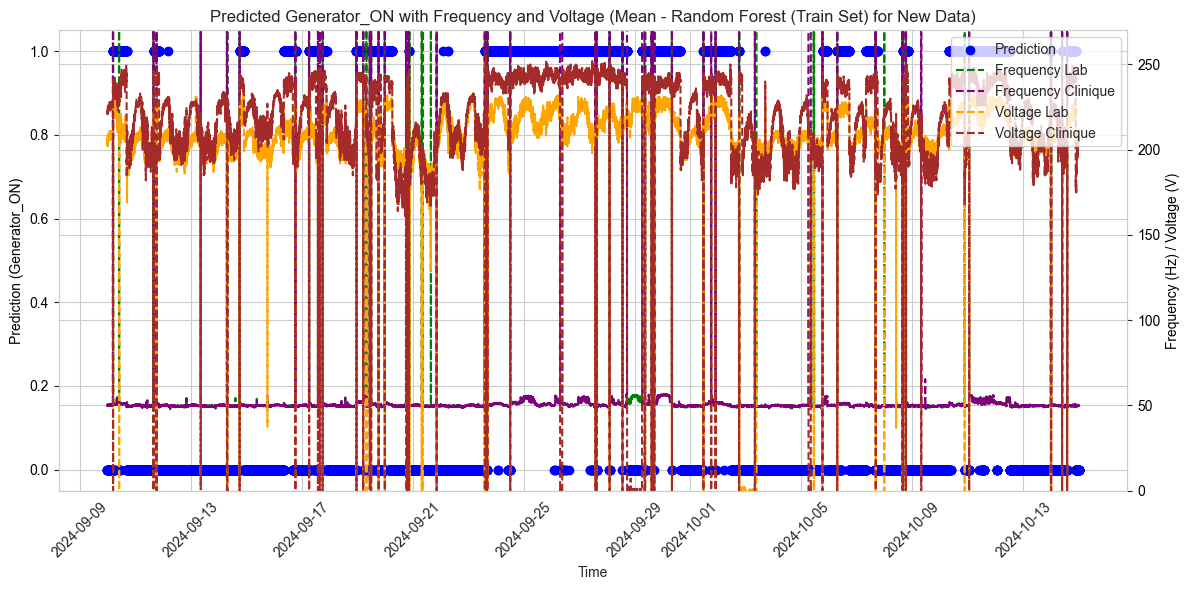

In [54]:
# For Random Forest Model
# Test data with both voltage and frequency
plot_predictions(test_data_2, model_name="Mean - Random Forest (Train Set) for New Data", include_voltage=True, include_frequency=True)

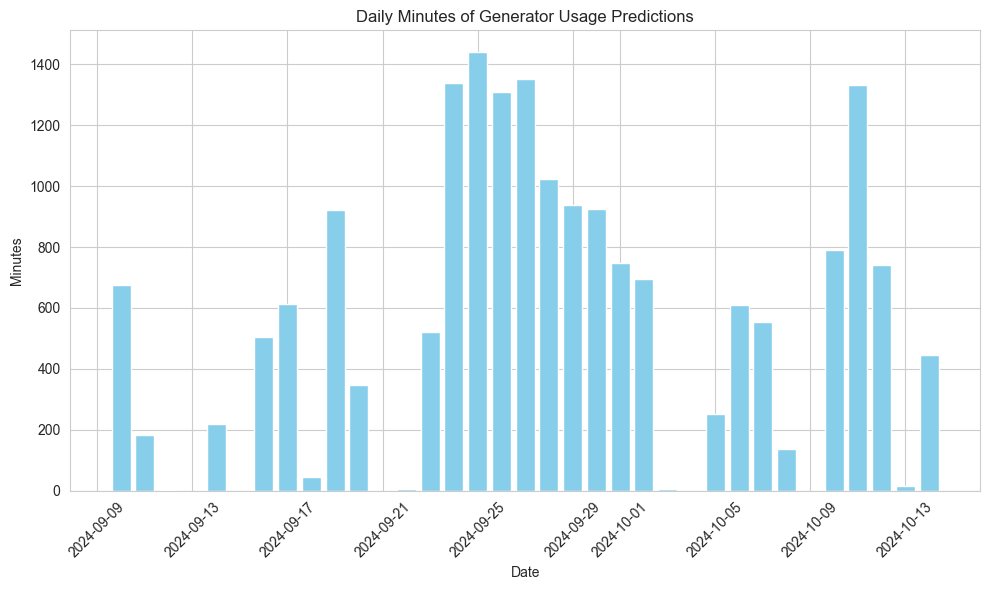

Date  Count  Minutes      Hours
0   2024-09-10    337      674  11.233333
1   2024-09-11     92      184   3.066667
2   2024-09-12      1        2   0.033333
3   2024-09-14    110      220   3.666667
4   2024-09-16    252      504   8.400000
5   2024-09-17    307      614  10.233333
6   2024-09-18     22       44   0.733333
7   2024-09-19    461      922  15.366667
8   2024-09-20    173      346   5.766667
9   2024-09-22      3        6   0.100000
10  2024-09-23    260      520   8.666667
11  2024-09-24    670     1340  22.333333
12  2024-09-25    720     1440  24.000000
13  2024-09-26    654     1308  21.800000
14  2024-09-27    676     1352  22.533333
15  2024-09-28    512     1024  17.066667
16  2024-09-29    469      938  15.633333
17  2024-09-30    463      926  15.433333
18  2024-10-01    374      748  12.466667
19  2024-10-02    348      696  11.600000
20  2024-10-03      2        4   0.066667
21  2024-10-05    126      252   4.200000
22  2024-10-06    305      610  10.166667
23  2024-10-07    277      554   9.233333
24  2024-10-08     69      138   2.300000
25  2024-10-10    395      790  13.166667
26  2024-10-11    666     1332  22.200000
27  2024-10-12    370      740  12.333333
28  2024-10-13      7       14   0.233333
29  2024-10-14    222      444   7.400000

In [55]:
test_data_2_daily_count = plot_true_predictions_histogram(test_data_2)
test_data_2_daily_count

#### 5.2. Using 1 Year Data of Year 2023

Loading 1 year data into 1 dataframe:

In [56]:
# Set the path to the folder containing CSV files
folder_path = '/Users/danielsitompul/Documents/0. Fall 2024/2. DEVENG 205 - Development Engineering Applications/2. ML Model/pythonProject/data/2023 Data/'

# Use glob to get all CSV file paths in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store each DataFrame
dfs = []

# Loop through the file paths and read each CSV into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
data_2023 = pd.concat(dfs, ignore_index=True)

# Ensure the 'time' column is in datetime format
data_2023['time'] = pd.to_datetime(data_2023['Time'], format='%Y-%m-%d %H:%M:%S')

# Sort the DataFrame by the 'time' column
data_2023 = data_2023.sort_values(by='time').reset_index(drop=True)

# Display the first few rows to verify
data_2023

Time  \
0       2023-01-01 00:00:00   
1       2023-01-01 00:02:00   
2       2023-01-01 00:04:00   
3       2023-01-01 00:06:00   
4       2023-01-01 00:08:00   
...                     ...   
267835  2023-12-31 23:50:00   
267836  2023-12-31 23:52:00   
267837  2023-12-31 23:54:00   
267838  2023-12-31 23:56:00   
267839  2023-12-31 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.3            
1                                                    50.2            
2                                                    50.0            
3                                                    50.3            
4                                                    50.1            
...                                                   ...            
267835                                               49.9            
267836                                               49.9            
267837                                               50.0            
267838                                               50.1            
267839                                               50.2            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.3         
1                                                    50.2         
2                                                    50.0         
3                                                    50.3         
4                                                    50.1         
...                                                   ...         
267835                                               49.9         
267836                                               49.8         
267837                                               50.0         
267838                                               50.1         
267839                                               50.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   198.0          
1                                                   200.0          
2                                                   202.0          
3                                                   203.0          
4                                                   202.0          
...                                                   ...          
267835                                              202.0          
267836                                              202.0          
267837                                              202.0          
267838                                              202.0          
267839                                              202.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   199.0       
1                                                   202.0       
2                                                   204.0       
3                                                   204.0       
4                                                   204.0       
...                                                   ...       
267835                                              209.0       
267836                                              209.0       
267837                                              210.0       
267838                                              210.0       
267839                                              211.0       

                      time  
0      2023-01-01 00:00:00  
1      2023-01-01 00:02:00  
2      2023-01-01 00:04:00  
3      2023-01-01 00:06:00  
4      2023-01-01 00:08:00  
...                    ...  
267835 2023-12-31 23:50:00  
267836 2023-12-31 23:52:00  
267837 2023-12-31 23:54:00  
267838 2023-12-31 23:56:00  
267839 2023-12-31 23:58:00  

[267840 rows x 6 columns]

In [57]:
# Step 1: Generate Features

## FEATURE GENERATION
# Taking the mean of the dataframe (using the previous function)
test_data_2023, test_data_2023_dummy = calculate_mean_flags(data_2023, data_2023, train_data_base, columns_to_compare)

# Assuming train_data_ts and test_data_ts are your DataFrames
test_data_2023, test_data_2023_dummy = process_time_series_data(test_data_2023, test_data_2023, high_freq_threshold,
                                                       low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display Processed data:
print('Processed data after feature generation: ')
display(test_data_2023)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

X_test = test_data_2023[feature_columns]

# Step 2: Make Predictions on the train and test sets
test_data_2023['prediction'] = clf.predict(X_test)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = test_data_2023['prediction'].sum()

# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(test_data_2023) / 30

# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

Processed data after feature generation: 


Time  \
0      2023-01-01 00:00:00   
1      2023-01-01 00:02:00   
2      2023-01-01 00:04:00   
3      2023-01-01 00:06:00   
4      2023-01-01 00:08:00   
...                    ...   
267835 2023-12-31 23:50:00   
267836 2023-12-31 23:52:00   
267837 2023-12-31 23:54:00   
267838 2023-12-31 23:56:00   
267839 2023-12-31 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.3            
1                                                    50.2            
2                                                    50.0            
3                                                    50.3            
4                                                    50.1            
...                                                   ...            
267835                                               49.9            
267836                                               49.9            
267837                                               50.0            
267838                                               50.1            
267839                                               50.2            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.3         
1                                                    50.2         
2                                                    50.0         
3                                                    50.3         
4                                                    50.1         
...                                                   ...         
267835                                               49.9         
267836                                               49.8         
267837                                               50.0         
267838                                               50.1         
267839                                               50.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   198.0          
1                                                   200.0          
2                                                   202.0          
3                                                   203.0          
4                                                   202.0          
...                                                   ...          
267835                                              202.0          
267836                                              202.0          
267837                                              202.0          
267838                                              202.0          
267839                                              202.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   199.0       
1                                                   202.0       
2                                                   204.0       
3                                                   204.0       
4                                                   204.0       
...                                                   ...       
267835                                              209.0       
267836                                              209.0       
267837                                              210.0       
267838                                              210.0       
267839                                              211.0       

                      time  higher_freq_lab  higher_freq_clinique  \
0      2023-01-01 00:00:00            False                 False   
1      2023-01-01 00:02:00            False                 False   
2      2023-01-01 00:04:00            False                 False   
3      2023-01-01 00:06:00            False                 False   
4      2023-01-01 00:08:00            False                 False   
...

##### PREDICTION RESULT #####
Predicted Minutes: 113200 minutes, or 1886.67 hours within 8928.00 hours


##### 5.2.1. Plot Result During Lost Clinique Data (2023)

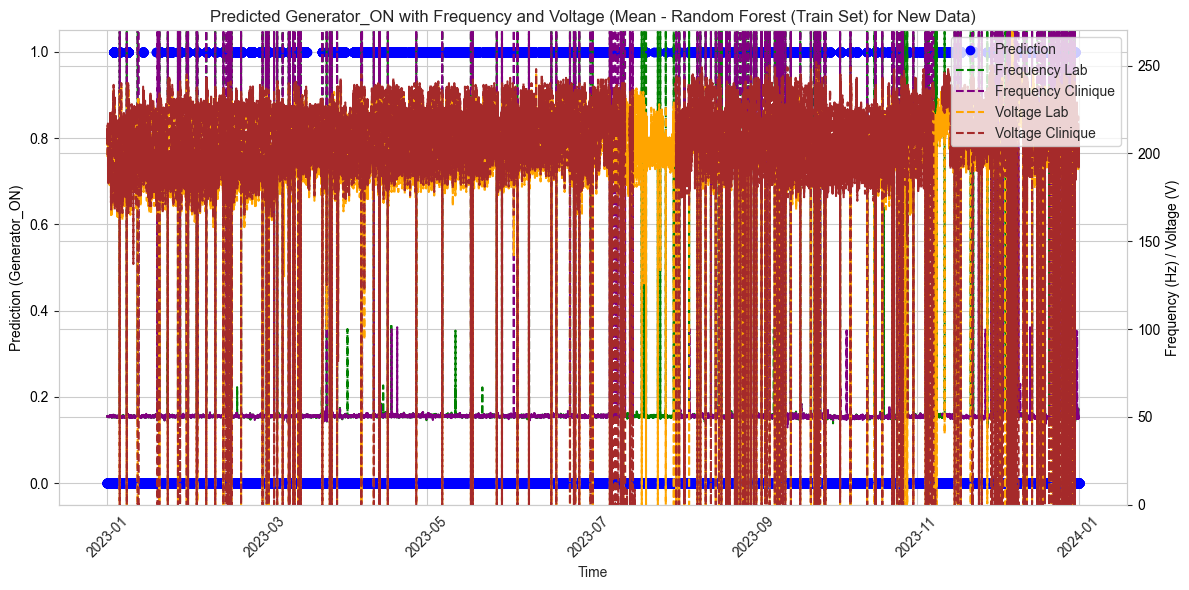

In [58]:
# For Random Forest Model
# Test data with both voltage and frequency
plot_predictions(test_data_2023, model_name="Mean - Random Forest (Train Set) for New Data", include_voltage=True, include_frequency=True)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


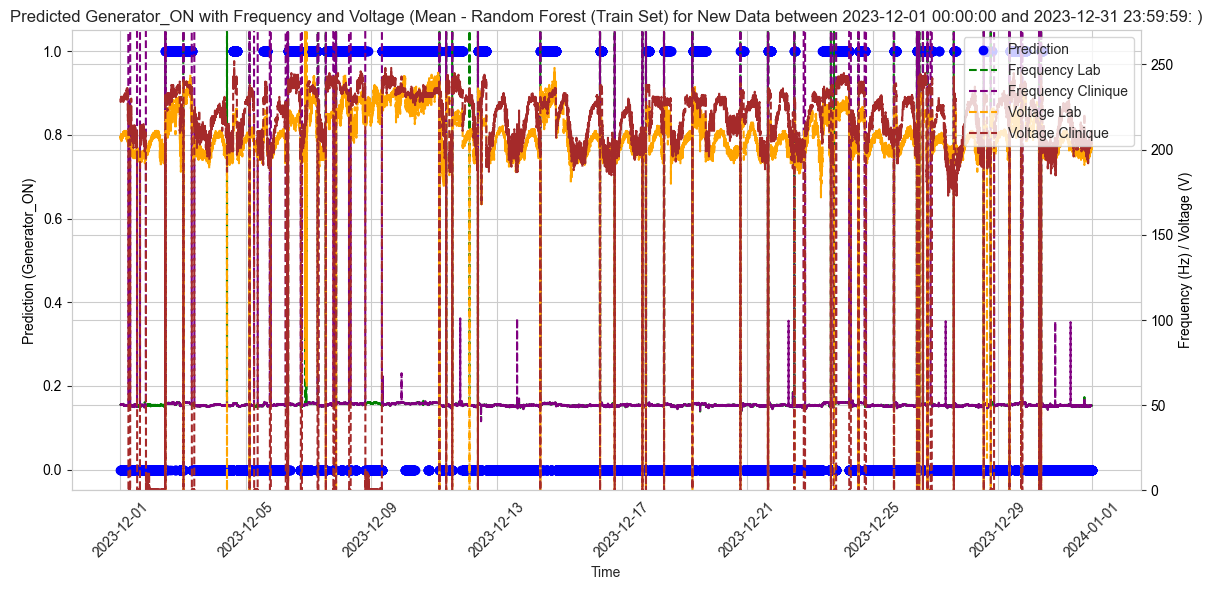

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


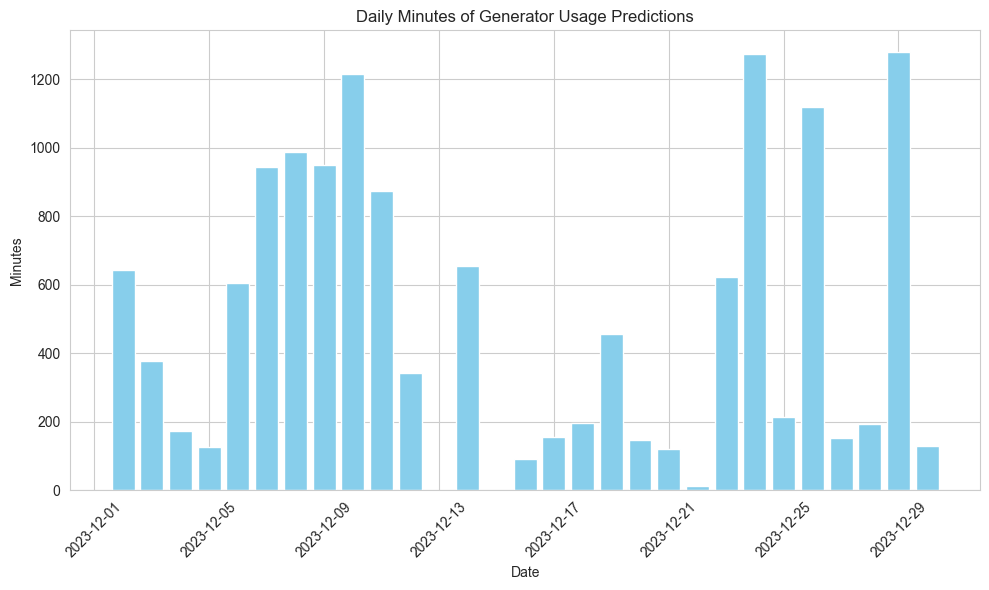

Date  Count  Minutes      Hours
0   2023-12-02    321      642  10.700000
1   2023-12-03    189      378   6.300000
2   2023-12-04     86      172   2.866667
3   2023-12-05     63      126   2.100000
4   2023-12-06    303      606  10.100000
5   2023-12-07    472      944  15.733333
6   2023-12-08    494      988  16.466667
7   2023-12-09    474      948  15.800000
8   2023-12-10    608     1216  20.266667
9   2023-12-11    437      874  14.566667
10  2023-12-12    172      344   5.733333
11  2023-12-14    328      656  10.933333
12  2023-12-16     46       92   1.533333
13  2023-12-17     78      156   2.600000
14  2023-12-18     98      196   3.266667
15  2023-12-19    228      456   7.600000
16  2023-12-20     73      146   2.433333
17  2023-12-21     60      120   2.000000
18  2023-12-22      7       14   0.233333
19  2023-12-23    312      624  10.400000
20  2023-12-24    636     1272  21.200000
21  2023-12-25    107      214   3.566667
22  2023-12-26    559     1118  18.633333
23  2023-12-27     76      152   2.533333
24  2023-12-28     97      194   3.233333
25  2023-12-29    639     1278  21.300000
26  2023-12-30     65      130   2.166667

##### PREDICTION RESULT #####
Predicted Minutes: 14056 minutes, or 234.27 hours within 912.00 hours
Average Daily Usage Minutes: 520.5925925925926 minutes, or 8.676543209876543 hours
Max minutes of usage 1278 minutes or 21.3 hours. Date: 2023-12-29


In [59]:
# Plot predictions based on certain timing choosen

start_date = '2023-12-01 00:00:00'
finished_date = '2023-12-31 23:59:59'
filtered_test_data_2023 = test_data_2023[(test_data_2023['Time'] >= start_date) & (test_data_2023['Time'] <= finished_date)]


# Plot based on the filtered time:
plot_predictions(
    filtered_test_data_2023,
    model_name=f"Mean - Random Forest (Train Set) for New Data between {start_date} and {finished_date}: ",
    include_voltage=True,
    include_frequency=True
)


# Plot histogram for each minutes generator usage daily
filtered_test_data_2_daily_count = plot_true_predictions_histogram(filtered_test_data_2023)
display(filtered_test_data_2_daily_count)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = filtered_test_data_2023['prediction'].sum()


# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(filtered_test_data_2023) / 30
average_daily = filtered_test_data_2_daily_count['Minutes'].sum() / filtered_test_data_2_daily_count.shape[0] 
max_daily = filtered_test_data_2_daily_count['Minutes'].max()
# Find the row with the maximum 'Minutes' value
max_daily_row = filtered_test_data_2_daily_count.loc[filtered_test_data_2_daily_count['Minutes'].idxmax()]
# Extract the 'Date' column from that row
max_date = max_daily_row['Date']


# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')
print(f'Average Daily Usage Minutes: {average_daily} minutes, or {average_daily / 60} hours')
print(f'Max minutes of usage {max_daily} minutes or {max_daily / 60} hours. Date: {max_date}')

##### 5.2.2. Plot Result First 10 days of July (2023)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


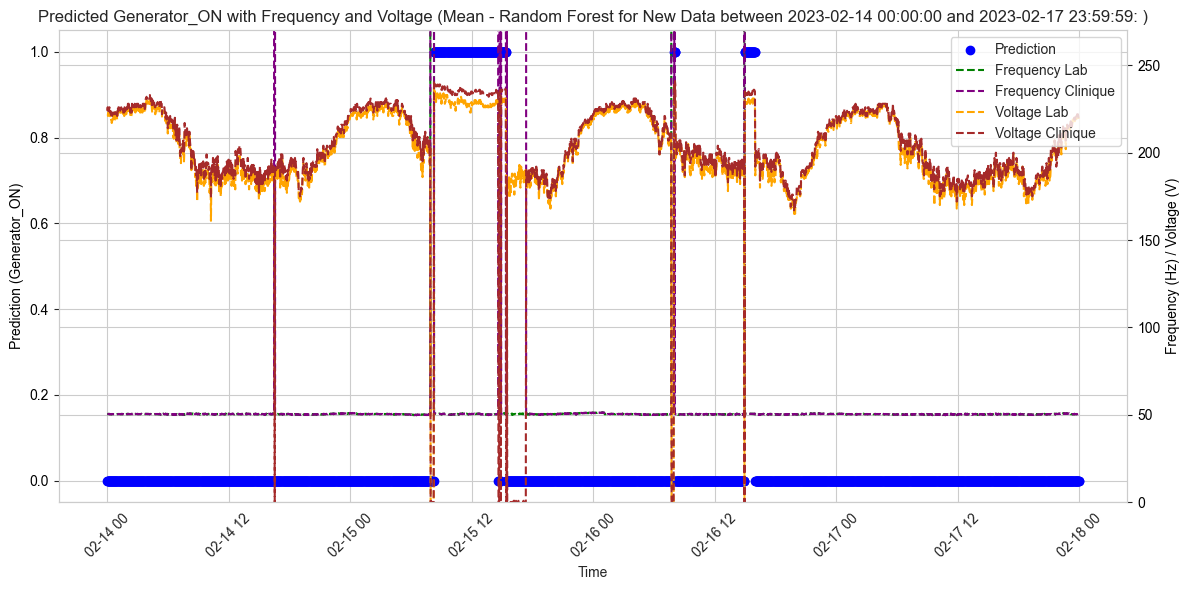

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


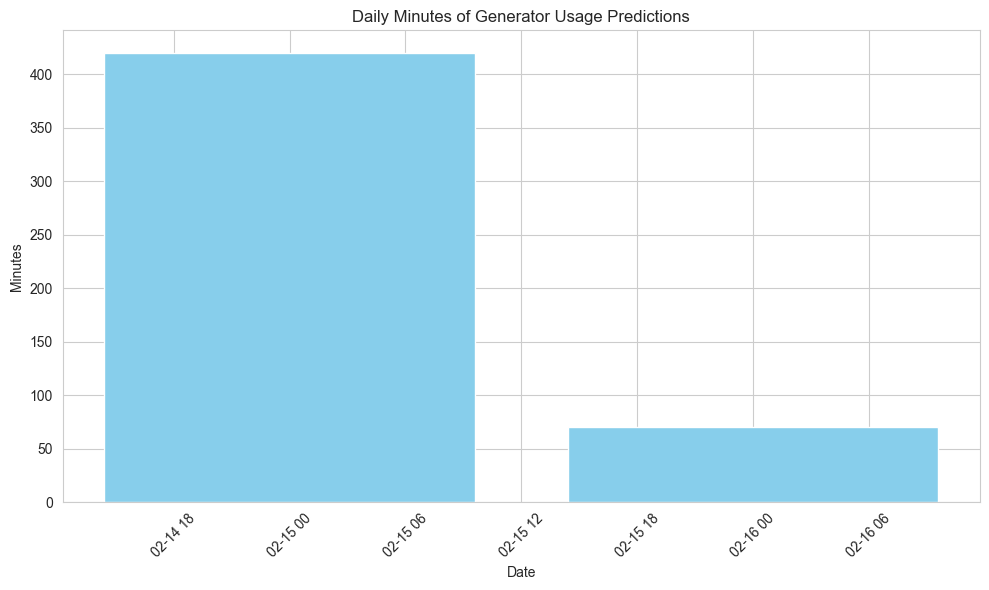

Date  Count  Minutes     Hours
0  2023-02-15    210      420  7.000000
1  2023-02-16     35       70  1.166667

##### PREDICTION RESULT #####
Predicted Minutes: 490 minutes, or 8.17 hours within 96.00 hours


In [60]:
# Plot predictions based on certain timing choosen
start_date = '2023-02-14 00:00:00'
finished_date = '2023-02-17 23:59:59'
filtered_test_data_2023 = test_data_2023[(test_data_2023['Time'] >= start_date) & (test_data_2023['Time'] <= finished_date)]


# Plot based on the filtered time:
plot_predictions(
    filtered_test_data_2023,
    model_name=f"Mean - Random Forest for New Data between {start_date} and {finished_date}: ",
    include_voltage=True,
    include_frequency=True
)

# Plot histogram for each minutes generator usage daily
filtered_test_data_2_daily_count = plot_true_predictions_histogram(filtered_test_data_2023)
display(filtered_test_data_2_daily_count)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = filtered_test_data_2023['prediction'].sum()

# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(filtered_test_data_2023) / 30

# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

#### 5.3. Using Data of Year 2022

Due to data limitations, only Data from 27th May 2022 - 31st December 2022 is available

In [61]:
# Loading the data

# Set the path to the folder containing CSV files
folder_path = '/Users/danielsitompul/Documents/0. Fall 2024/2. DEVENG 205 - Development Engineering Applications/2. ML Model/pythonProject/data/2022 Data/'

# Use glob to get all CSV file paths in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store each DataFrame
dfs = []

# Loop through the file paths and read each CSV into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
data_2022 = pd.concat(dfs, ignore_index=True)

# Ensure the 'time' column is in datetime format
data_2022['time'] = pd.to_datetime(data_2022['Time'], format='%Y-%m-%d %H:%M:%S')

# Sort the DataFrame by the 'time' column
data_2022 = data_2022.sort_values(by='time').reset_index(drop=True)

# Display the first few rows to verify
data_2022


Time  \
0       2022-05-28 00:00:00   
1       2022-05-28 00:02:00   
2       2022-05-28 00:04:00   
3       2022-05-28 00:06:00   
4       2022-05-28 00:08:00   
...                     ...   
156954  2022-12-31 23:50:00   
156955  2022-12-31 23:52:00   
156956  2022-12-31 23:54:00   
156957  2022-12-31 23:56:00   
156958  2022-12-31 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.6            
1                                                    50.6            
2                                                    50.3            
3                                                    50.1            
4                                                    50.1            
...                                                   ...            
156954                                               50.0            
156955                                               50.1            
156956                                               50.1            
156957                                               50.0            
156958                                               50.0            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.7         
1                                                    50.6         
2                                                    50.3         
3                                                    50.1         
4                                                    50.2         
...                                                   ...         
156954                                               50.0         
156955                                               50.1         
156956                                               50.1         
156957                                               50.0         
156958                                               50.1         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   226.0          
1                                                   226.0          
2                                                   226.0          
3                                                   228.0          
4                                                   226.0          
...                                                   ...          
156954                                              198.0          
156955                                              198.0          
156956                                              199.0          
156957                                              199.0          
156958                                              199.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   226.0       
1                                                   226.0       
2                                                   226.0       
3                                                   228.0       
4                                                   226.0       
...                                                   ...       
156954                                              199.0       
156955                                              199.0       
156956                                              200.0       
156957                                              201.0       
156958                                              200.0       

                      time  
0      2022-05-28 00:00:00  
1      2022-05-28 00:02:00  
2      2022-05-28 00:04:00  
3      2022-05-28 00:06:00  
4      2022-05-28 00:08:00  
...                    ...  
156954 2022-12-31 23:50:00  
156955 2022-12-31 23:52:00  
156956 2022-12-31 23:54:00  
156957 2022-12-31 23:56:00  
156958 2022-12-31 23:58:00  

[156959 rows x 6 columns]

In [62]:
# Step 1: Generate Features

## FEATURE GENERATION
# Taking the mean of the dataframe (using the previous function)
test_data_2022, test_data_2022_dummy = calculate_mean_flags(data_2022, data_2022, train_data_base, columns_to_compare)

# Assuming train_data_ts and test_data_ts are your DataFrames
test_data_2022, test_data_2022_dummy = process_time_series_data(test_data_2022, test_data_2022, high_freq_threshold,
                                                       low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display Processed data:
print('Processed data after feature generation: ')
display(test_data_2022)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)', 
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)', 
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

X_test = test_data_2022[feature_columns]

# Step 2: Make Predictions on the train and test sets
test_data_2022['prediction'] = clf.predict(X_test)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = test_data_2022['prediction'].sum()

# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(test_data_2022) / 30

# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

Processed data after feature generation: 


Time  \
0      2022-05-28 00:00:00   
1      2022-05-28 00:02:00   
2      2022-05-28 00:04:00   
3      2022-05-28 00:06:00   
4      2022-05-28 00:08:00   
...                    ...   
156954 2022-12-31 23:50:00   
156955 2022-12-31 23:52:00   
156956 2022-12-31 23:54:00   
156957 2022-12-31 23:56:00   
156958 2022-12-31 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.6            
1                                                    50.6            
2                                                    50.3            
3                                                    50.1            
4                                                    50.1            
...                                                   ...            
156954                                               50.0            
156955                                               50.1            
156956                                               50.1            
156957                                               50.0            
156958                                               50.0            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.7         
1                                                    50.6         
2                                                    50.3         
3                                                    50.1         
4                                                    50.2         
...                                                   ...         
156954                                               50.0         
156955                                               50.1         
156956                                               50.1         
156957                                               50.0         
156958                                               50.1         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   226.0          
1                                                   226.0          
2                                                   226.0          
3                                                   228.0          
4                                                   226.0          
...                                                   ...          
156954                                              198.0          
156955                                              198.0          
156956                                              199.0          
156957                                              199.0          
156958                                              199.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   226.0       
1                                                   226.0       
2                                                   226.0       
3                                                   228.0       
4                                                   226.0       
...                                                   ...       
156954                                              199.0       
156955                                              199.0       
156956                                              200.0       
156957                                              201.0       
156958                                              200.0       

                      time  higher_freq_lab  higher_freq_clinique  \
0      2022-05-28 00:00:00            False                 False   
1      2022-05-28 00:02:00            False                 False   
2      2022-05-28 00:04:00            False                 False   
3      2022-05-28 00:06:00            False                 False   
4      2022-05-28 00:08:00            False                 False   
...

##### PREDICTION RESULT #####
Predicted Minutes: 28878 minutes, or 481.30 hours within 5231.97 hours


##### 5.2.2. Plot Result During Lost Clinique Data (2022)

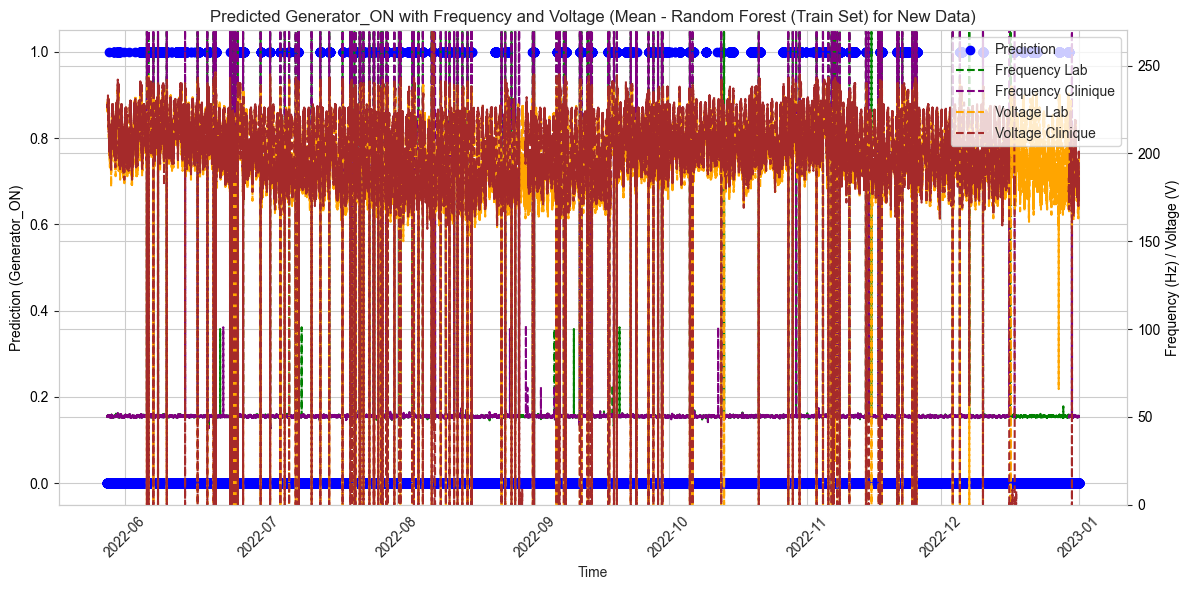

In [63]:
# For Random Forest Model
# Test data with both voltage and frequency
plot_predictions(test_data_2022, model_name="Mean - Random Forest (Train Set) for New Data", include_voltage=True, include_frequency=True)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


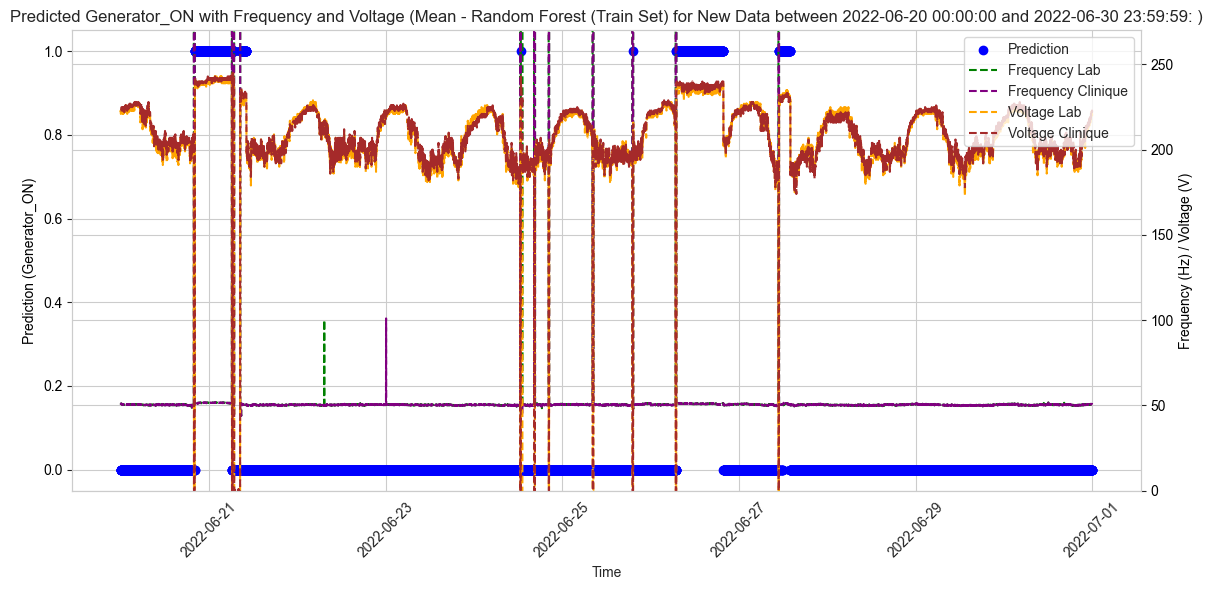

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


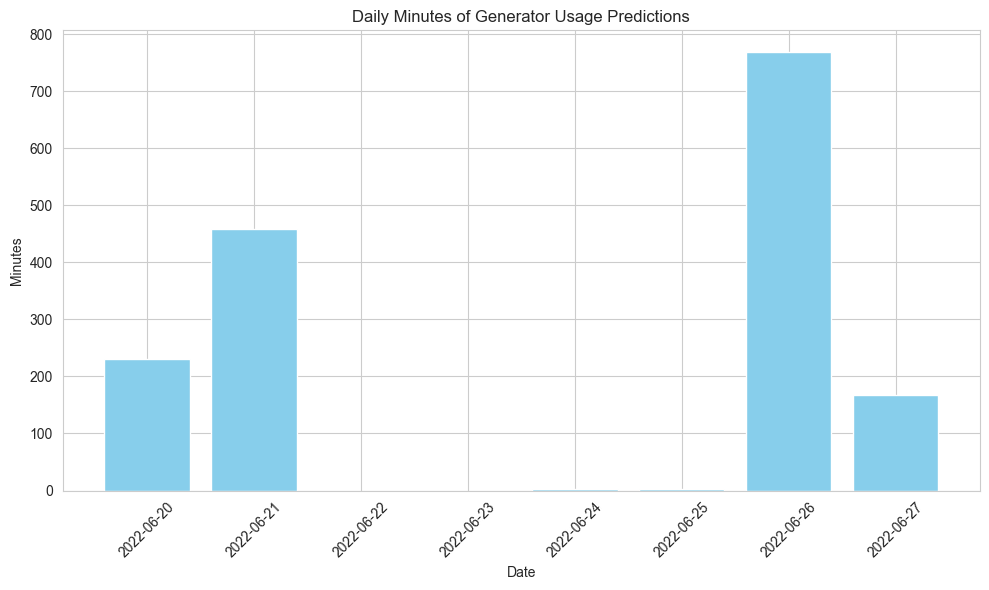

Date  Count  Minutes      Hours
0  2022-06-20    115      230   3.833333
1  2022-06-21    229      458   7.633333
2  2022-06-24      1        2   0.033333
3  2022-06-25      1        2   0.033333
4  2022-06-26    384      768  12.800000
5  2022-06-27     84      168   2.800000

##### PREDICTION RESULT #####
Predicted Minutes: 1628 minutes, or 27.13 hours within 264.00 hours


In [96]:
# Plot predictions based on certain timing choosen

start_date = '2022-06-20 00:00:00'
finished_date = '2022-06-30 23:59:59'
filtered_test_data_2022 = test_data_2022[(test_data_2022['Time'] >= start_date) & (test_data_2022['Time'] <= finished_date)]


# Plot based on the filtered time:
plot_predictions(
    filtered_test_data_2022,
    model_name=f"Mean - Random Forest (Train Set) for New Data between {start_date} and {finished_date}: ",
    include_voltage=True,
    include_frequency=True
)


# Plot histogram for each minutes generator usage daily
filtered_test_data_2_daily_count = plot_true_predictions_histogram(filtered_test_data_2022)
display(filtered_test_data_2_daily_count)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = filtered_test_data_2022['prediction'].sum()


# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(filtered_test_data_2022) / 30


# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

display()

#### 5.4. Using Data of Year 2024

In [65]:
# Loading the data

# Set the path to the folder containing CSV files
folder_path = '/Users/danielsitompul/Documents/0. Fall 2024/2. DEVENG 205 - Development Engineering Applications/2. ML Model/pythonProject/data/2024 Data/'

# Use glob to get all CSV file paths in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store each DataFrame
dfs = []

# Loop through the file paths and read each CSV into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
data_2024 = pd.concat(dfs, ignore_index=True)

# Ensure the 'time' column is in datetime format
data_2024['time'] = pd.to_datetime(data_2024['Time'], format='%Y-%m-%d %H:%M:%S')

# Sort the DataFrame by the 'time' column
data_2024 = data_2024.sort_values(by='time').reset_index(drop=True)

# Display the first few rows to verify
data_2024

Time  \
0       2024-01-01 00:00:00   
1       2024-01-01 00:02:00   
2       2024-01-01 00:04:00   
3       2024-01-01 00:06:00   
4       2024-01-01 00:08:00   
...                     ...   
226766  2024-11-10 23:50:00   
226767  2024-11-10 23:52:00   
226768  2024-11-10 23:54:00   
226769  2024-11-10 23:56:00   
226770  2024-11-10 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.1            
1                                                    49.7            
2                                                    49.8            
3                                                    49.9            
4                                                    50.0            
...                                                   ...            
226766                                               50.1            
226767                                               50.0            
226768                                               50.2            
226769                                               49.9            
226770                                               50.2            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.1         
1                                                    49.7         
2                                                    49.8         
3                                                    49.9         
4                                                    50.0         
...                                                   ...         
226766                                               50.1         
226767                                               50.2         
226768                                               50.1         
226769                                               50.2         
226770                                               50.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   201.0          
1                                                   202.0          
2                                                   202.0          
3                                                   201.0          
4                                                   204.0          
...                                                   ...          
226766                                              230.0          
226767                                              230.0          
226768                                              230.0          
226769                                              231.0          
226770                                              231.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   211.0       
1                                                   210.0       
2                                                   210.0       
3                                                   213.0       
4                                                   209.0       
...                                                   ...       
226766                                              222.0       
226767                                              222.0       
226768                                              222.0       
226769                                              223.0       
226770                                              224.0       

                      time  
0      2024-01-01 00:00:00  
1      2024-01-01 00:02:00  
2      2024-01-01 00:04:00  
3      2024-01-01 00:06:00  
4      2024-01-01 00:08:00  
...                    ...  
226766 2024-11-10 23:50:00  
226767 2024-11-10 23:52:00  
226768 2024-11-10 23:54:00  
226769 2024-11-10 23:56:00  
226770 2024-11-10 23:58:00  

[226771 rows x 6 columns]

In [66]:
# Step 1: Generate Features

## FEATURE GENERATION
# Taking the mean of the dataframe (using the previous function)
test_data_2024, test_data_2024_dummy = calculate_mean_flags(data_2024, data_2024, train_data_base, columns_to_compare)

# Assuming train_data_ts and test_data_ts are your DataFrames
test_data_2024, test_data_2024_dummy = process_time_series_data(test_data_2024, test_data_2024, high_freq_threshold,
                                                       low_freq_threshold, high_volt_threshold, low_volt_threshold)

# Display Processed data:
print('Processed data after feature generation: ')
display(test_data_2024)

# Define the feature columns
feature_columns = [
    'Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
    'Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)',
    'Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)',
    'higher_freq_lab', 'higher_freq_clinique', 'higher_volt_lab',
    'higher_volt_clinique', 'Freq_delta_lab', 'Freq_delta_clinique',
    'Volt_delta_lab', 'Volt_delta_clinique', 'freq_delta_negative_lab',
    'freq_delta_negative_clinique', 'volt_delta_positive_lab',
    'volt_delta_positive_clinique', 'freq_in_range_lab',
    'volt_in_range_lab', 'freq_in_range_clinique', 'volt_in_range_clinique',
    'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
    'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
    'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
    'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
    'High_delta_freq_lab', 'High_delta_freq_clinique',
    'High_delta_volt_lab', 'High_delta_volt_clinique',
    'Prev_High_delta_freq_lab', 'Prev_High_delta_freq_clinique',
    'Prev_High_delta_volt_lab', 'Prev_High_delta_volt_clinique'
]

X_test = test_data_2024[feature_columns]

# Step 2: Make Predictions on the train and test sets
test_data_2024['prediction'] = clf.predict(X_test)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = test_data_2024['prediction'].sum()

# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(test_data_2024) / 30

# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

Processed data after feature generation: 


Time  \
0      2024-01-01 00:00:00   
1      2024-01-01 00:02:00   
2      2024-01-01 00:04:00   
3      2024-01-01 00:06:00   
4      2024-01-01 00:08:00   
...                    ...   
226766 2024-11-10 23:50:00   
226767 2024-11-10 23:52:00   
226768 2024-11-10 23:54:00   
226769 2024-11-10 23:56:00   
226770 2024-11-10 23:58:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                    50.1            
1                                                    49.7            
2                                                    49.8            
3                                                    49.9            
4                                                    50.0            
...                                                   ...            
226766                                               50.1            
226767                                               50.0            
226768                                               50.2            
226769                                               49.9            
226770                                               50.2            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                    50.1         
1                                                    49.7         
2                                                    49.8         
3                                                    49.9         
4                                                    50.0         
...                                                   ...         
226766                                               50.1         
226767                                               50.2         
226768                                               50.1         
226769                                               50.2         
226770                                               50.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
0                                                   201.0          
1                                                   202.0          
2                                                   202.0          
3                                                   201.0          
4                                                   204.0          
...                                                   ...          
226766                                              230.0          
226767                                              230.0          
226768                                              230.0          
226769                                              231.0          
226770                                              231.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
0                                                   211.0       
1                                                   210.0       
2                                                   210.0       
3                                                   213.0       
4                                                   209.0       
...                                                   ...       
226766                                              222.0       
226767                                              222.0       
226768                                              222.0       
226769                                              223.0       
226770                                              224.0       

                      time  higher_freq_lab  higher_freq_clinique  \
0      2024-01-01 00:00:00            False                 False   
1      2024-01-01 00:02:00            False                 False   
2      2024-01-01 00:04:00            False                 False   
3      2024-01-01 00:06:00            False                 False   
4      2024-01-01 00:08:00            False                 False   
...

##### PREDICTION RESULT #####
Predicted Minutes: 82944 minutes, or 1382.40 hours within 7559.03 hours


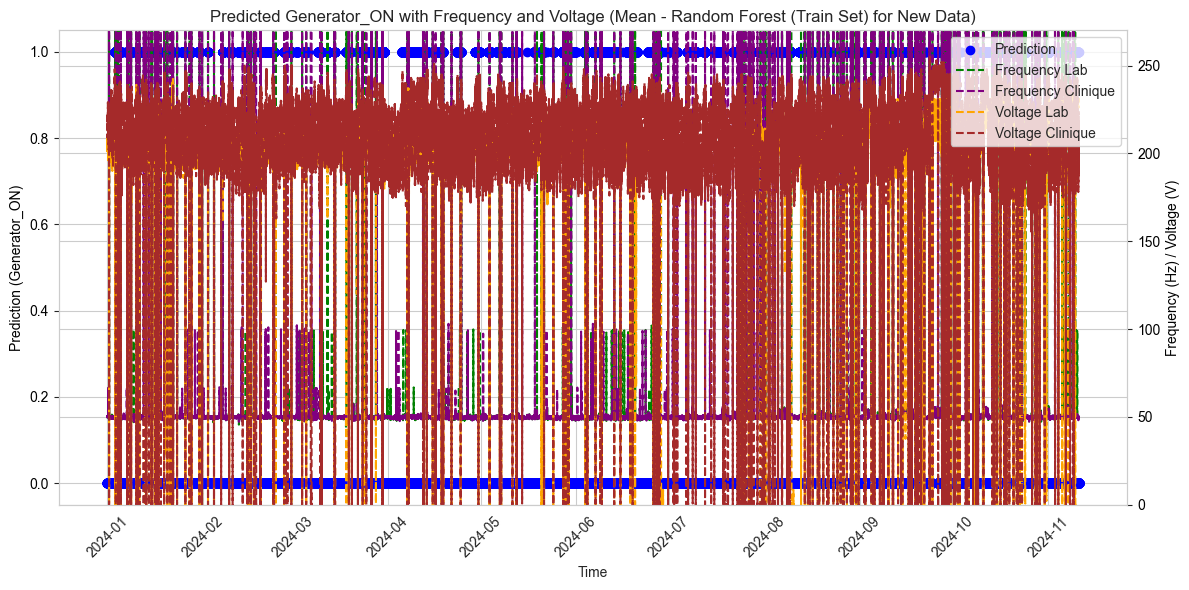

In [67]:
# For Random Forest Model
# Test data with both voltage and frequency
plot_predictions(test_data_2024, model_name="Mean - Random Forest (Train Set) for New Data", include_voltage=True, include_frequency=True)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


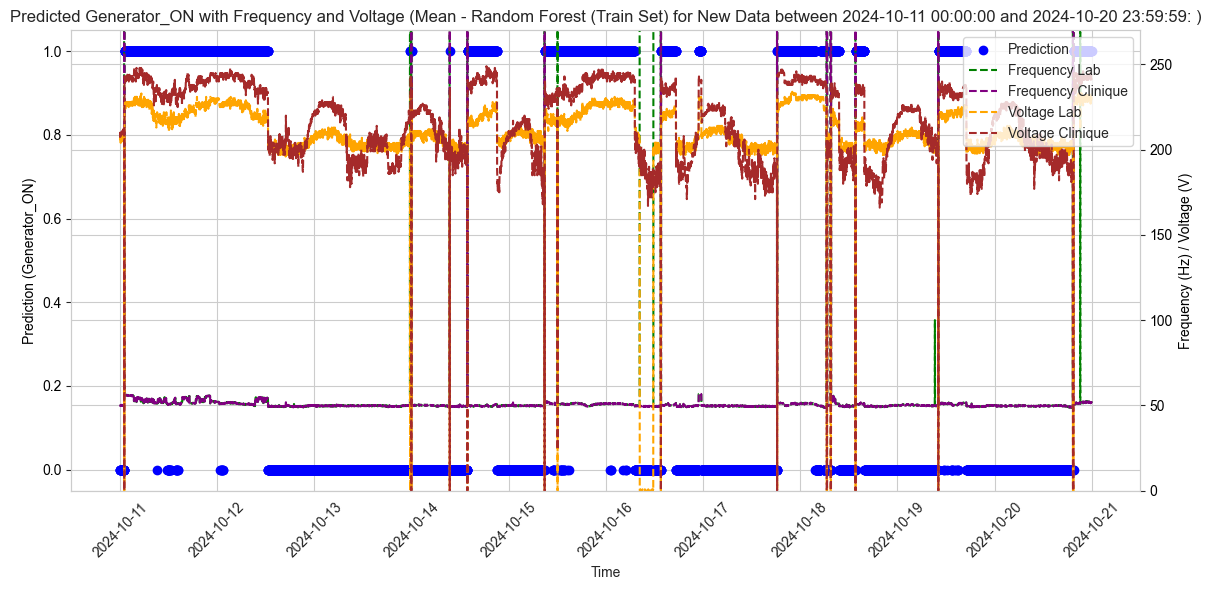

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m-%d %H:%M:%S')


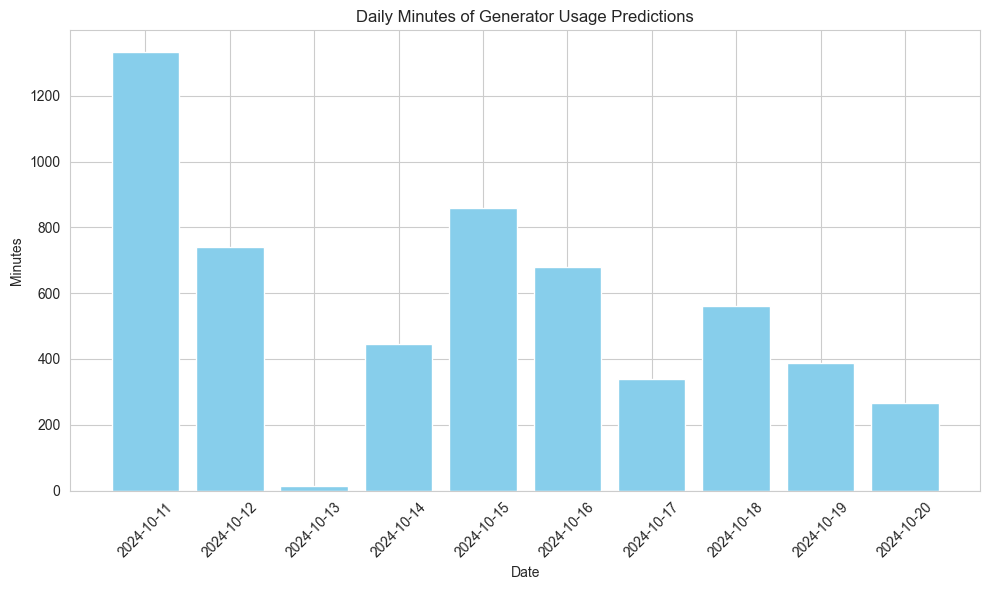

Date  Count  Minutes      Hours
0  2024-10-11    666     1332  22.200000
1  2024-10-12    370      740  12.333333
2  2024-10-13      7       14   0.233333
3  2024-10-14    222      444   7.400000
4  2024-10-15    430      860  14.333333
5  2024-10-16    340      680  11.333333
6  2024-10-17    170      340   5.666667
7  2024-10-18    280      560   9.333333
8  2024-10-19    194      388   6.466667
9  2024-10-20    133      266   4.433333

##### PREDICTION RESULT #####
Predicted Minutes: 5624 minutes, or 93.73 hours within 240.00 hours


In [68]:
# Plot predictions based on certain timing choosen

start_date = '2024-10-11 00:00:00'
finished_date = '2024-10-20 23:59:59'
filtered_test_data_2024 = test_data_2024[(test_data_2024['Time'] >= start_date) & (test_data_2024['Time'] <= finished_date)]


# Plot based on the filtered time:
plot_predictions(
    filtered_test_data_2024,
    model_name=f"Mean - Random Forest (Train Set) for New Data between {start_date} and {finished_date}: ",
    include_voltage=True,
    include_frequency=True
)


# Plot histogram for each minutes generator usage daily
filtered_test_data_2_daily_count = plot_true_predictions_histogram(filtered_test_data_2024)
display(filtered_test_data_2_daily_count)

print(f'##### PREDICTION RESULT #####')
predicted_minutes = filtered_test_data_2024['prediction'].sum()


# Total duration in hours (assuming each row represents 1 minute)
total_hours = len(filtered_test_data_2024) / 30


# Display actual and predicted minutes with equivalent hours
print(f'Predicted Minutes: {predicted_minutes*2} minutes, or {predicted_minutes / 30:.2f} hours within {total_hours:.2f} hours')

display()

In [69]:
## CHECK : 4-11 November

## 6. Summary of Data

#### 6.1. Generator 2022 Data

In [70]:
year_summary, monthly_summary = generator_usage_summary(test_data_2022)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:641: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['prediction'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:642: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                 Value
0   Total Minutes Used (min)                 28878
1  Average Daily Usage (min)             132.46789
2   Median Daily Usage (min)                   6.0
3      Highest Month (Total)  Month 11 (6228 mins)
4       Lowest Month (Total)    Month 5 (270 mins)

'Monthly Summary:'

Month  Total Usage (min)  Average Daily Usage (min)  Max Daily Usage (min)  \
0      5                270                  33.750000                    127   
1      6               5530                  92.166667                    549   
2      7               3128                  50.451613                    194   
3      8               3170                  51.129032                    352   
4      9               4828                  80.466667                    277   
5     10               3676                  59.290323                    243   
6     11               6228                 103.800000                    405   
7     12               2048                  33.032258                    276   

  Max Daily Usage (Date)  
0             2022-05-30  
1             2022-06-06  
2             2022-07-28  
3             2022-08-25  
4             2022-09-21  
5             2022-10-30  
6             2022-11-07  
7             2022-12-05

#### 6.2. Generator 2023 Data

In [71]:
year_summary, monthly_summary = generator_usage_summary(test_data_2023)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:641: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['prediction'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:642: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                  Value
0   Total Minutes Used (min)                 113200
1  Average Daily Usage (min)             310.136986
2   Median Daily Usage (min)                  302.0
3      Highest Month (Total)  Month 12 (14056 mins)
4       Lowest Month (Total)    Month 1 (2976 mins)

'Monthly Summary:'

Month  Total Usage (min)  Average Daily Usage (min)  \
0       1               2976                  48.000000   
1       2               4422                  78.964286   
2       3               5000                  80.645161   
3       4              12872                 214.533333   
4       5              13516                 218.000000   
5       6              13428                 223.800000   
6       7               8388                 135.290323   
7       8              12276                 198.000000   
8       9              11912                 198.533333   
9      10               4918                  79.322581   
10     11               9436                 157.266667   
11     12              14056                 226.709677   

    Max Daily Usage (min) Max Daily Usage (Date)  
0                     383             2023-01-08  
1                     352             2023-02-07  
2                     390             2023-03-12  
3                     488             2023-04-11  
4                     318             2023-05-29  
5                     363             2023-06-22  
6                     428             2023-07-05  
7                     434             2023-08-08  
8                     533             2023-09-05  
9                     397             2023-10-27  
10                    683             2023-11-12  
11                    639             2023-12-29

#### 6.3. Generator 2024 Data

In [72]:
year_summary, monthly_summary = generator_usage_summary(test_data_2024)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:641: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['prediction'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:642: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                 Value
0   Total Minutes Used (min)                 82944
1  Average Daily Usage (min)            263.314286
2   Median Daily Usage (min)                 174.0
3      Highest Month (Total)  Month 9 (15886 mins)
4       Lowest Month (Total)  Month 11 (3540 mins)

'Monthly Summary:'

Month  Total Usage (min)  Average Daily Usage (min)  \
0       1               7308                 117.870968   
1       2               5284                  91.103448   
2       3               5262                  84.870968   
3       4               8110                 135.166667   
4       5               5372                  86.645161   
5       6               6442                 107.366667   
6       7               5308                  85.612903   
7       8               8102                 130.677419   
8       9              15886                 264.766667   
9      10              12330                 198.870968   
10     11               3540                 177.000000   

    Max Daily Usage (min) Max Daily Usage (Date)  
0                     340             2024-01-19  
1                     295             2024-02-27  
2                     332             2024-03-30  
3                     467             2024-04-15  
4                     389             2024-05-10  
5                     300             2024-06-04  
6                     320             2024-07-07  
7                     441             2024-08-20  
8                     720             2024-09-25  
9                     666             2024-10-11  
10                    307             2024-11-06

## 7. Generator Power Calculation

In [73]:
# Constant Declaration of Hourly kwh average
kwh_hour = [
    6.747835296, 7.057838155, 8.16854183, 11.30196556, 11.21547191, 9.88189269, 11.22740354, 12.85224141, 14.05086424, 13.96076821,
    13.70200973, 13.46483643, 13.25040271, 12.23739568, 9.853452467, 11.13546578, 11.58039839, 9.594331892, 9.649361468,
    8.320364238, 6.779637969, 6.241952539, 6.125157442, 6.18646468
]

#### 7.1. Generator 2022 Power

In [74]:
# Calculate the total kWh for each row based on hour-specific multipliers
test_data_2022['power (kW)'] = test_data_2022.apply(
    lambda row: sum(row[f'Hour_{i}'] * kwh_hour[i] for i in range(24)) / 30 if row['prediction'] else 0,
    axis=1
)

test_data_2022[test_data_2022['prediction']]

Time  \
277    2022-05-28 09:14:00   
990    2022-05-29 09:00:00   
991    2022-05-29 09:02:00   
992    2022-05-29 09:04:00   
996    2022-05-29 09:12:00   
...                    ...   
155290 2022-12-29 16:22:00   
155291 2022-12-29 16:24:00   
155292 2022-12-29 16:26:00   
155293 2022-12-29 16:28:00   
155294 2022-12-29 16:30:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
277                                                  50.0            
990                                                  50.1            
991                                                  50.3            
992                                                  50.3            
996                                                  50.3            
...                                                   ...            
155290                                               51.1            
155291                                               51.2            
155292                                               51.0            
155293                                               51.1            
155294                                               51.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
277                                                  50.0         
990                                                  50.1         
991                                                  50.3         
992                                                  50.3         
996                                                  50.3         
...                                                   ...         
155290                                                NaN         
155291                                                NaN         
155292                                                NaN         
155293                                                NaN         
155294                                                NaN         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
277                                                 213.0          
990                                                 216.0          
991                                                 213.0          
992                                                 216.0          
996                                                 214.0          
...                                                   ...          
155290                                              231.0          
155291                                              233.0          
155292                                              234.0          
155293                                              232.0          
155294                                              233.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
277                                                 216.0       
990                                                 218.0       
991                                                 215.0       
992                                                 218.0       
996                                                 216.0       
...                                                   ...       
155290                                                NaN       
155291                                                NaN       
155292                                                NaN       
155293                                                NaN       
155294                                                NaN       

                      time  higher_freq_lab  higher_freq_clinique  \
277    2022-05-28 09:14:00            False                 False   
990    2022-05-29 09:00:00            False                 False   
991    2022-05-29 09:02:00            False                 False   
992    2022-05-29 09:04:00            False                 False   
996    2022-05-29 09:12:00            False                 False   
...

In [75]:
# Year 2022 power from generator summary
year_summary, monthly_summary = power_usage_summary(test_data_2022)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:707: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['power (kW)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:708: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                  Value
0     Total Power Used (kW)                 5445.4
1  Average Daily Usage (kW)                  24.98
2   Median Daily Usage (kW)                   1.02
3     Highest Month (Total)  Month 11 (1195.95 kW)
4      Lowest Month (Total)     Month 5 (61.11 kW)

'Monthly Summary:'

Month  Total Usage (kW)  Average Daily Usage (kW)  Max Daily Usage (kW)  \
0      5             61.11                     15.28                 57.53   
1      6           1058.49                     35.28                203.53   
2      7            522.44                     16.85                 77.81   
3      8            514.09                     16.58                143.55   
4      9            935.54                     31.18                113.25   
5     10            723.84                     23.35                103.34   
6     11           1195.95                     39.86                155.18   
7     12            433.95                     14.00                116.33   

  Max Daily Usage (Date)  
0             2022-05-30  
1             2022-06-06  
2             2022-07-09  
3             2022-08-25  
4             2022-09-21  
5             2022-10-30  
6             2022-11-25  
7             2022-12-05

#### 7.2. Generator 2023 Power

In [76]:
# Calculate the total kWh for each row based on hour-specific multipliers
test_data_2023['power (kW)'] = test_data_2023.apply(
    lambda row: sum(row[f'Hour_{i}'] * kwh_hour[i] for i in range(24)) / 30 if row['prediction'] else 0,
    axis=1
)

test_data_2023[test_data_2023['prediction']]

Time  \
1690   2023-01-03 08:20:00   
1691   2023-01-03 08:22:00   
1692   2023-01-03 08:24:00   
1693   2023-01-03 08:26:00   
1694   2023-01-03 08:28:00   
...                    ...   
266281 2023-12-30 10:00:00   
266282 2023-12-30 10:02:00   
266283 2023-12-30 10:02:00   
266284 2023-12-30 10:04:00   
266285 2023-12-30 10:04:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1690                                                 51.2            
1691                                                 50.9            
1692                                                 50.9            
1693                                                 50.9            
1694                                                 50.7            
...                                                   ...            
266281                                               50.9            
266282                                               51.2            
266283                                               51.2            
266284                                               51.1            
266285                                               51.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1690                                                 51.2         
1691                                                 51.0         
1692                                                 50.9         
1693                                                 50.8         
1694                                                 50.8         
...                                                   ...         
266281                                               50.9         
266282                                               51.3         
266283                                               51.3         
266284                                               51.2         
266285                                               51.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1690                                                237.0          
1691                                                235.0          
1692                                                234.0          
1693                                                233.0          
1694                                                233.0          
...                                                   ...          
266281                                              213.0          
266282                                              209.0          
266283                                              209.0          
266284                                              213.0          
266285                                              213.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1690                                                239.0       
1691                                                237.0       
1692                                                236.0       
1693                                                236.0       
1694                                                231.0       
...                                                   ...       
266281                                              230.0       
266282                                              230.0       
266283                                              230.0       
266284                                              231.0       
266285                                              231.0       

                      time  higher_freq_lab  higher_freq_clinique  \
1690   2023-01-03 08:20:00            False                 False   
1691   2023-01-03 08:22:00            False                 False   
1692   2023-01-03 08:24:00            False                 False   
1693   2023-01-03 08:26:00            False                 False   
1694   2023-01-03 08:28:00            False                 False   
...

In [77]:
# Year 2023 power from generator summary
year_summary, monthly_summary = power_usage_summary(test_data_2023)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:707: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['power (kW)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:708: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                 Value
0     Total Power Used (kW)              22294.77
1  Average Daily Usage (kW)                 61.08
2   Median Daily Usage (kW)                 60.68
3     Highest Month (Total)  Month 5 (2830.83 kW)
4      Lowest Month (Total)    Month 1 (571.2 kW)

'Monthly Summary:'

Month  Total Usage (kW)  Average Daily Usage (kW)  Max Daily Usage (kW)  \
0       1            571.20                     18.43                150.45   
1       2            911.07                     32.54                144.18   
2       3            969.49                     31.27                145.24   
3       4           2635.32                     87.84                190.79   
4       5           2830.83                     91.32                132.65   
5       6           2798.46                     93.28                142.69   
6       7           1732.21                     55.88                155.19   
7       8           2350.87                     75.83                152.06   
8       9           2374.75                     79.16                200.91   
9      10            969.79                     31.28                149.74   
10     11           1679.03                     55.97                232.71   
11     12           2471.75                     79.73                232.28   

   Max Daily Usage (Date)  
0              2023-01-08  
1              2023-02-07  
2              2023-03-12  
3              2023-04-11  
4              2023-05-29  
5              2023-06-22  
6              2023-07-05  
7              2023-08-18  
8              2023-09-05  
9              2023-10-27  
10             2023-11-12  
11             2023-12-29

#### 7.3. Generator 2024 Power

In [78]:
# Calculate the total kWh for each row based on hour-specific multipliers
test_data_2024['power (kW)'] = test_data_2024.apply(
    lambda row: sum(row[f'Hour_{i}'] * kwh_hour[i] for i in range(24)) / 30 if row['prediction'] else 0,
    axis=1
)

test_data_2024[test_data_2024['prediction']]

Time  \
1708   2024-01-03 08:56:00   
1709   2024-01-03 08:58:00   
1710   2024-01-03 09:00:00   
1711   2024-01-03 09:02:00   
1712   2024-01-03 09:04:00   
...                    ...   
226647 2024-11-10 19:52:00   
226648 2024-11-10 19:54:00   
226649 2024-11-10 19:56:00   
226650 2024-11-10 19:58:00   
226729 2024-11-10 22:36:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1708                                                 50.3            
1709                                                 51.0            
1710                                                 50.8            
1711                                                 50.6            
1712                                                 50.5            
...                                                   ...            
226647                                               50.0            
226648                                               50.0            
226649                                               50.2            
226650                                               50.0            
226729                                               50.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1708                                                 50.5         
1709                                                 50.8         
1710                                                 50.8         
1711                                                 50.6         
1712                                                 50.5         
...                                                   ...         
226647                                               49.9         
226648                                               50.0         
226649                                               49.3         
226650                                               49.3         
226729                                               50.1         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1708                                                216.0          
1709                                                219.0          
1710                                                222.0          
1711                                                216.0          
1712                                                216.0          
...                                                   ...          
226647                                              227.0          
226648                                              227.0          
226649                                              227.0          
226650                                              227.0          
226729                                              232.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1708                                                243.0       
1709                                                245.0       
1710                                                245.0       
1711                                                248.0       
1712                                                248.0       
...                                                   ...       
226647                                              206.0       
226648                                              212.0       
226649                                              202.0       
226650                                              193.0       
226729                                              216.0       

                      time  higher_freq_lab  higher_freq_clinique  \
1708   2024-01-03 08:56:00            False                 False   
1709   2024-01-03 08:58:00            False                 False   
1710   2024-01-03 09:00:00            False                 False   
1711   2024-01-03 09:02:00            False                 False   
1712   2024-01-03 09:04:00            False                 False   
...

In [79]:
# Year 2024 power from generator summary
year_summary, monthly_summary = power_usage_summary(test_data_2024)
display("Yearly Summary:")
display(year_summary)
display("Monthly Summary:")
display(monthly_summary)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:707: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')['power (kW)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:708: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_usage_per_month = data.groupby('Month'

'Yearly Summary:'

Metric                 Value
0     Total Power Used (kW)              15322.59
1  Average Daily Usage (kW)                 48.64
2   Median Daily Usage (kW)                 28.94
3     Highest Month (Total)  Month 9 (2745.76 kW)
4      Lowest Month (Total)  Month 11 (693.58 kW)

'Monthly Summary:'

Month  Total Usage (kW)  Average Daily Usage (kW)  Max Daily Usage (kW)  \
0       1           1335.60                     43.08                123.74   
1       2            972.23                     33.53                122.42   
2       3           1082.42                     34.92                132.66   
3       4           1596.87                     53.23                160.08   
4       5           1055.84                     34.06                130.77   
5       6           1273.37                     42.45                122.28   
6       7            976.47                     31.50                131.35   
7       8           1444.78                     46.61                176.15   
8       9           2745.76                     91.53                244.59   
9      10           2145.67                     69.22                228.35   
10     11            693.58                     69.36                119.78   

   Max Daily Usage (Date)  
0              2024-01-19  
1              2024-02-27  
2              2024-03-22  
3              2024-04-15  
4              2024-05-10  
5              2024-06-04  
6              2024-07-07  
7              2024-08-20  
8              2024-09-25  
9              2024-10-11  
10             2024-11-04

## 8. Generator Emission Calculation

In [80]:
# Constant Declaration of Emission index

#Assuming Un-Controlled NOx
NOx_lb_hp_hr = 0.024
CO_lb_hp_hr = 0.0055
SOx_lb_hp_hr = 0.00809
CO2_lb_hp_hr = 1.16
PM_lb_hp_hr = 0.0007

kwh_to_hp_hr = 1.341
lb_to_gr = 453.592

#### 8.1. Generator 2022 Emission

In [81]:
test_data_2022 = calculate_emissions(test_data_2022)

test_data_2022[test_data_2022['prediction']]

Time  \
277    2022-05-28 09:14:00   
990    2022-05-29 09:00:00   
991    2022-05-29 09:02:00   
992    2022-05-29 09:04:00   
996    2022-05-29 09:12:00   
...                    ...   
155290 2022-12-29 16:22:00   
155291 2022-12-29 16:24:00   
155292 2022-12-29 16:26:00   
155293 2022-12-29 16:28:00   
155294 2022-12-29 16:30:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
277                                                  50.0            
990                                                  50.1            
991                                                  50.3            
992                                                  50.3            
996                                                  50.3            
...                                                   ...            
155290                                               51.1            
155291                                               51.2            
155292                                               51.0            
155293                                               51.1            
155294                                               51.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
277                                                  50.0         
990                                                  50.1         
991                                                  50.3         
992                                                  50.3         
996                                                  50.3         
...                                                   ...         
155290                                                NaN         
155291                                                NaN         
155292                                                NaN         
155293                                                NaN         
155294                                                NaN         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
277                                                 213.0          
990                                                 216.0          
991                                                 213.0          
992                                                 216.0          
996                                                 214.0          
...                                                   ...          
155290                                              231.0          
155291                                              233.0          
155292                                              234.0          
155293                                              232.0          
155294                                              233.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
277                                                 216.0       
990                                                 218.0       
991                                                 215.0       
992                                                 218.0       
996                                                 216.0       
...                                                   ...       
155290                                                NaN       
155291                                                NaN       
155292                                                NaN       
155293                                                NaN       
155294                                                NaN       

                      time  higher_freq_lab  higher_freq_clinique  \
277    2022-05-28 09:14:00            False                 False   
990    2022-05-29 09:00:00            False                 False   
991    2022-05-29 09:02:00            False                 False   
992    2022-05-29 09:04:00            False                 False   
996    2022-05-29 09:12:00            False                 False   
...

In [82]:
generator_emission_summary(test_data_2022)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary NOx emission:'

Metric                  Value
0         Total year NOx Emission (g)               79494.19
1      Average Daily NOx Emission (g)                 364.65
2       Median Daily NOx Emission (g)                  14.89
3  Highest Month NOx Emission (Total)  Month 11 (17458.94 g)
4   Lowest Month NOx Emission (Total)     Month 5 (892.11 g)

'Monthly Summary  NOx emission:'

Month  Total NOx Emission (g)  Average Daily NOx Emission (g)  \
0      5                  892.11                          223.03   
1      6                15452.27                          515.08   
2      7                 7626.76                          246.02   
3      8                 7504.85                          242.09   
4      9                13657.40                          455.25   
5     10                10566.94                          340.87   
6     11                17458.94                          581.96   
7     12                 6334.93                          204.35   

   Max Daily NOx Emission (g) Max Daily NOx Emission (Date)  
0                      839.86                    2022-05-30  
1                     2971.21                    2022-06-06  
2                     1135.86                    2022-07-09  
3                     2095.56                    2022-08-25  
4                     1653.21                    2022-09-21  
5                     1508.61                    2022-10-30  
6                     2265.38                    2022-11-25  
7                     1698.28                    2022-12-05

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO emission:'

Metric                 Value
0         Total year CO Emission (g)              18217.42
1      Average Daily CO Emission (g)                 83.57
2       Median Daily CO Emission (g)                  3.41
3  Highest Month CO Emission (Total)  Month 11 (4001.01 g)
4   Lowest Month CO Emission (Total)    Month 5 (204.44 g)

'Monthly Summary  CO emission:'

Month  Total CO Emission (g)  Average Daily CO Emission (g)  \
0      5                 204.44                          51.11   
1      6                3541.14                         118.04   
2      7                1747.80                          56.38   
3      8                1719.86                          55.48   
4      9                3129.82                         104.33   
5     10                2421.59                          78.12   
6     11                4001.01                         133.37   
7     12                1451.75                          46.83   

   Max Daily CO Emission (g) Max Daily CO Emission (Date)  
0                     192.47                   2022-05-30  
1                     680.90                   2022-06-06  
2                     260.30                   2022-07-09  
3                     480.23                   2022-08-25  
4                     378.86                   2022-09-21  
5                     345.72                   2022-10-30  
6                     519.15                   2022-11-25  
7                     389.19                   2022-12-05

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary SOx emission:'

Metric                 Value
0         Total year SOx Emission (g)              26796.17
1      Average Daily SOx Emission (g)                122.92
2       Median Daily SOx Emission (g)                  5.02
3  Highest Month SOx Emission (Total)  Month 11 (5885.12 g)
4   Lowest Month SOx Emission (Total)    Month 5 (300.72 g)

'Monthly Summary  SOx emission:'

Month  Total SOx Emission (g)  Average Daily SOx Emission (g)  \
0      5                  300.72                           75.18   
1      6                 5208.70                          173.62   
2      7                 2570.85                           82.93   
3      8                 2529.76                           81.61   
4      9                 4603.68                          153.46   
5     10                 3561.94                          114.90   
6     11                 5885.12                          196.17   
7     12                 2135.40                           68.88   

   Max Daily SOx Emission (g) Max Daily SOx Emission (Date)  
0                      283.10                    2022-05-30  
1                     1001.55                    2022-06-06  
2                      382.88                    2022-07-09  
3                      706.38                    2022-08-25  
4                      557.27                    2022-09-21  
5                      508.53                    2022-10-30  
6                      763.62                    2022-11-25  
7                      572.46                    2022-12-05

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO2 emission:'

Metric                   Value
0         Total year CO2 Emission (g)              3842219.14
1      Average Daily CO2 Emission (g)                17624.86
2       Median Daily CO2 Emission (g)                  719.74
3  Highest Month CO2 Emission (Total)  Month 11 (843848.53 g)
4   Lowest Month CO2 Emission (Total)    Month 5 (43118.71 g)

'Monthly Summary  CO2 emission:'

Month  Total CO2 Emission (g)  Average Daily CO2 Emission (g)  \
0      5                43118.71                        10779.68   
1      6               746859.59                        24895.32   
2      7               368626.72                        11891.18   
3      8               362734.48                        11701.11   
4      9               660107.43                        22003.58   
5     10               510735.62                        16475.34   
6     11               843848.53                        28128.28   
7     12               306188.06                         9877.03   

   Max Daily CO2 Emission (g) Max Daily CO2 Emission (Date)  
0                    40593.30                    2022-05-30  
1                   143608.71                    2022-06-06  
2                    54899.83                    2022-07-09  
3                   101285.54                    2022-08-25  
4                    79905.20                    2022-09-21  
5                    72916.33                    2022-10-30  
6                   109493.22                    2022-11-25  
7                    82083.50                    2022-12-05

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary PM emission:'

Metric                Value
0         Total year PM Emission (g)              2318.58
1      Average Daily PM Emission (g)                10.64
2       Median Daily PM Emission (g)                 0.43
3  Highest Month PM Emission (Total)  Month 11 (509.22 g)
4   Lowest Month PM Emission (Total)    Month 5 (26.02 g)

'Monthly Summary  PM emission:'

Month  Total PM Emission (g)  Average Daily PM Emission (g)  \
0      5                  26.02                           6.50   
1      6                 450.69                          15.02   
2      7                 222.45                           7.18   
3      8                 218.89                           7.06   
4      9                 398.34                          13.28   
5     10                 308.20                           9.94   
6     11                 509.22                          16.97   
7     12                 184.77                           5.96   

   Max Daily PM Emission (g) Max Daily PM Emission (Date)  
0                      24.50                   2022-05-30  
1                      86.66                   2022-06-06  
2                      33.13                   2022-07-09  
3                      61.12                   2022-08-25  
4                      48.22                   2022-09-21  
5                      44.00                   2022-10-30  
6                      66.07                   2022-11-25  
7                      49.53                   2022-12-05

#### 8.2. Generator 2023 Emission

In [83]:
test_data_2023 = calculate_emissions(test_data_2023)

test_data_2023[test_data_2023['prediction']]

Time  \
1690   2023-01-03 08:20:00   
1691   2023-01-03 08:22:00   
1692   2023-01-03 08:24:00   
1693   2023-01-03 08:26:00   
1694   2023-01-03 08:28:00   
...                    ...   
266281 2023-12-30 10:00:00   
266282 2023-12-30 10:02:00   
266283 2023-12-30 10:02:00   
266284 2023-12-30 10:04:00   
266285 2023-12-30 10:04:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1690                                                 51.2            
1691                                                 50.9            
1692                                                 50.9            
1693                                                 50.9            
1694                                                 50.7            
...                                                   ...            
266281                                               50.9            
266282                                               51.2            
266283                                               51.2            
266284                                               51.1            
266285                                               51.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1690                                                 51.2         
1691                                                 51.0         
1692                                                 50.9         
1693                                                 50.8         
1694                                                 50.8         
...                                                   ...         
266281                                               50.9         
266282                                               51.3         
266283                                               51.3         
266284                                               51.2         
266285                                               51.2         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1690                                                237.0          
1691                                                235.0          
1692                                                234.0          
1693                                                233.0          
1694                                                233.0          
...                                                   ...          
266281                                              213.0          
266282                                              209.0          
266283                                              209.0          
266284                                              213.0          
266285                                              213.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1690                                                239.0       
1691                                                237.0       
1692                                                236.0       
1693                                                236.0       
1694                                                231.0       
...                                                   ...       
266281                                              230.0       
266282                                              230.0       
266283                                              230.0       
266284                                              231.0       
266285                                              231.0       

                      time  higher_freq_lab  higher_freq_clinique  \
1690   2023-01-03 08:20:00            False                 False   
1691   2023-01-03 08:22:00            False                 False   
1692   2023-01-03 08:24:00            False                 False   
1693   2023-01-03 08:26:00            False                 False   
1694   2023-01-03 08:28:00            False                 False   
...

In [84]:
generator_emission_summary(test_data_2023)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary NOx emission:'

Metric                 Value
0         Total year NOx Emission (g)             325468.15
1      Average Daily NOx Emission (g)                891.69
2       Median Daily NOx Emission (g)                885.83
3  Highest Month NOx Emission (Total)  Month 5 (41325.58 g)
4   Lowest Month NOx Emission (Total)   Month 1 (8338.68 g)

'Monthly Summary  NOx emission:'

Month  Total NOx Emission (g)  Average Daily NOx Emission (g)  \
0       1                 8338.68                          268.99   
1       2                13300.19                          475.01   
2       3                14153.06                          456.55   
3       4                38471.40                         1282.38   
4       5                41325.58                         1333.08   
5       6                40853.12                         1361.77   
6       7                25287.55                          815.73   
7       8                34318.94                         1107.06   
8       9                34667.56                         1155.59   
9      10                14157.35                          456.69   
10     11                24511.13                          817.04   
11     12                36083.59                         1163.99   

    Max Daily NOx Emission (g) Max Daily NOx Emission (Date)  
0                      2196.34                    2023-01-08  
1                      2104.77                    2023-02-07  
2                      2120.22                    2023-03-12  
3                      2785.24                    2023-04-11  
4                      1936.49                    2023-05-29  
5                      2083.03                    2023-06-22  
6                      2265.53                    2023-07-05  
7                      2219.80                    2023-08-18  
8                      2933.00                    2023-09-05  
9                      2185.93                    2023-10-27  
10                     3397.22                    2023-11-12  
11                     3390.92                    2023-12-29

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO emission:'

Metric                Value
0         Total year CO Emission (g)             74586.45
1      Average Daily CO Emission (g)               204.35
2       Median Daily CO Emission (g)                203.0
3  Highest Month CO Emission (Total)  Month 5 (9470.45 g)
4   Lowest Month CO Emission (Total)  Month 1 (1910.95 g)

'Monthly Summary  CO emission:'

Month  Total CO Emission (g)  Average Daily CO Emission (g)  \
0       1                1910.95                          61.64   
1       2                3047.96                         108.86   
2       3                3243.41                         104.63   
3       4                8816.36                         293.88   
4       5                9470.45                         305.50   
5       6                9362.17                         312.07   
6       7                5795.06                         186.94   
7       8                7864.76                         253.70   
8       9                7944.65                         264.82   
9      10                3244.39                         104.66   
10     11                5617.13                         187.24   
11     12                8269.16                         266.75   

    Max Daily CO Emission (g) Max Daily CO Emission (Date)  
0                      503.33                   2023-01-08  
1                      482.34                   2023-02-07  
2                      485.88                   2023-03-12  
3                      638.29                   2023-04-11  
4                      443.78                   2023-05-29  
5                      477.36                   2023-06-22  
6                      519.18                   2023-07-05  
7                      508.70                   2023-08-18  
8                      672.15                   2023-09-05  
9                      500.94                   2023-10-27  
10                     778.53                   2023-11-12  
11                     777.09                   2023-12-29

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary SOx emission:'

Metric                 Value
0         Total year SOx Emission (g)             109709.89
1      Average Daily SOx Emission (g)                300.58
2       Median Daily SOx Emission (g)                 298.6
3  Highest Month SOx Emission (Total)  Month 5 (13930.16 g)
4   Lowest Month SOx Emission (Total)   Month 1 (2810.83 g)

'Monthly Summary  SOx emission:'

Month  Total SOx Emission (g)  Average Daily SOx Emission (g)  \
0       1                 2810.83                           90.67   
1       2                 4483.27                          160.12   
2       3                 4770.76                          153.90   
3       4                12968.07                          432.27   
4       5                13930.16                          449.36   
5       6                13770.90                          459.03   
6       7                 8524.01                          274.97   
7       8                11568.34                          373.17   
8       9                11685.86                          389.53   
9      10                 4772.21                          153.94   
10     11                 8262.29                          275.41   
11     12                12163.18                          392.36   

    Max Daily SOx Emission (g) Max Daily SOx Emission (Date)  
0                       740.35                    2023-01-08  
1                       709.48                    2023-02-07  
2                       714.69                    2023-03-12  
3                       938.86                    2023-04-11  
4                       652.76                    2023-05-29  
5                       702.16                    2023-06-22  
6                       763.67                    2023-07-05  
7                       748.26                    2023-08-18  
8                       988.67                    2023-09-05  
9                       736.84                    2023-10-27  
10                     1145.15                    2023-11-12  
11                     1143.02                    2023-12-29

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO2 emission:'

Metric                   Value
0         Total year CO2 Emission (g)             15730960.61
1      Average Daily CO2 Emission (g)                43098.52
2       Median Daily CO2 Emission (g)                 42815.3
3  Highest Month CO2 Emission (Total)  Month 5 (1997403.08 g)
4   Lowest Month CO2 Emission (Total)   Month 1 (403036.17 g)

'Monthly Summary  CO2 emission:'

Month  Total CO2 Emission (g)  Average Daily CO2 Emission (g)  \
0       1               403036.17                        13001.17   
1       2               642842.57                        22958.66   
2       3               684064.69                        22066.60   
3       4              1859451.06                        61981.70   
4       5              1997403.08                        64432.36   
5       6              1974567.28                        65818.91   
6       7              1222231.48                        39426.82   
7       8              1658748.58                        53508.02   
8       9              1675598.90                        55853.30   
9      10               684271.85                        22073.29   
10     11              1184704.73                        39490.16   
11     12              1744040.24                        56259.36   

    Max Daily CO2 Emission (g) Max Daily CO2 Emission (Date)  
0                    106156.39                    2023-01-08  
1                    101730.48                    2023-02-07  
2                    102477.44                    2023-03-12  
3                    134620.15                    2023-04-11  
4                     93597.02                    2023-05-29  
5                    100679.96                    2023-06-22  
6                    109500.75                    2023-07-05  
7                    107290.34                    2023-08-18  
8                    141761.74                    2023-09-05  
9                    105653.19                    2023-10-27  
10                   164199.00                    2023-11-12  
11                   163894.31                    2023-12-29

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary PM emission:'

Metric                Value
0         Total year PM Emission (g)              9492.82
1      Average Daily PM Emission (g)                26.01
2       Median Daily PM Emission (g)                25.84
3  Highest Month PM Emission (Total)  Month 5 (1205.33 g)
4   Lowest Month PM Emission (Total)   Month 1 (243.21 g)

'Monthly Summary  PM emission:'

Month  Total PM Emission (g)  Average Daily PM Emission (g)  \
0       1                 243.21                           7.85   
1       2                 387.92                          13.85   
2       3                 412.80                          13.32   
3       4                1122.08                          37.40   
4       5                1205.33                          38.88   
5       6                1191.55                          39.72   
6       7                 737.55                          23.79   
7       8                1000.97                          32.29   
8       9                1011.14                          33.70   
9      10                 412.92                          13.32   
10     11                 714.91                          23.83   
11     12                1052.44                          33.95   

    Max Daily PM Emission (g) Max Daily PM Emission (Date)  
0                       64.06                   2023-01-08  
1                       61.39                   2023-02-07  
2                       61.84                   2023-03-12  
3                       81.24                   2023-04-11  
4                       56.48                   2023-05-29  
5                       60.76                   2023-06-22  
6                       66.08                   2023-07-05  
7                       64.74                   2023-08-18  
8                       85.55                   2023-09-05  
9                       63.76                   2023-10-27  
10                      99.09                   2023-11-12  
11                      98.90                   2023-12-29

#### 8.3. Generator 2024 Emission

In [85]:
test_data_2024 = calculate_emissions(test_data_2024)

test_data_2024[test_data_2024['prediction']]

Time  \
1708   2024-01-03 08:56:00   
1709   2024-01-03 08:58:00   
1710   2024-01-03 09:00:00   
1711   2024-01-03 09:02:00   
1712   2024-01-03 09:04:00   
...                    ...   
226647 2024-11-10 19:52:00   
226648 2024-11-10 19:54:00   
226649 2024-11-10 19:56:00   
226650 2024-11-10 19:58:00   
226729 2024-11-10 22:36:00   

        Frequency 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1708                                                 50.3            
1709                                                 51.0            
1710                                                 50.8            
1711                                                 50.6            
1712                                                 50.5            
...                                                   ...            
226647                                               50.0            
226648                                               50.0            
226649                                               50.2            
226650                                               50.0            
226729                                               50.1            

        Frequency C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1708                                                 50.5         
1709                                                 50.8         
1710                                                 50.8         
1711                                                 50.6         
1712                                                 50.5         
...                                                   ...         
226647                                               49.9         
226648                                               50.0         
226649                                               49.3         
226650                                               49.3         
226729                                               50.1         

        Voltage 3E2F4FD3 (Ch Cbca Bethesda Ndosho - laboratoire)  \
1708                                                216.0          
1709                                                219.0          
1710                                                222.0          
1711                                                216.0          
1712                                                216.0          
...                                                   ...          
226647                                              227.0          
226648                                              227.0          
226649                                              227.0          
226650                                              227.0          
226729                                              232.0          

        Voltage C30F2E03 (Ch Cbca Bethesda Ndosho - clinique)  \
1708                                                243.0       
1709                                                245.0       
1710                                                245.0       
1711                                                248.0       
1712                                                248.0       
...                                                   ...       
226647                                              206.0       
226648                                              212.0       
226649                                              202.0       
226650                                              193.0       
226729                                              216.0       

                      time  higher_freq_lab  higher_freq_clinique  \
1708   2024-01-03 08:56:00            False                 False   
1709   2024-01-03 08:58:00            False                 False   
1710   2024-01-03 09:00:00            False                 False   
1711   2024-01-03 09:02:00            False                 False   
1712   2024-01-03 09:04:00            False                 False   
...

In [86]:
generator_emission_summary(test_data_2024)

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary NOx emission:'

Metric                  Value
0         Total year NOx Emission (g)              223685.36
1      Average Daily NOx Emission (g)                 710.11
2       Median Daily NOx Emission (g)                 422.46
3  Highest Month NOx Emission (Total)   Month 9 (40083.66 g)
4   Lowest Month NOx Emission (Total)  Month 11 (10125.19 g)

'Monthly Summary  NOx emission:'

Month  Total NOx Emission (g)  Average Daily NOx Emission (g)  \
0       1                19497.59                          628.95   
1       2                14192.98                          489.41   
2       3                15801.67                          509.73   
3       4                23311.81                          777.06   
4       5                15413.53                          497.21   
5       6                18589.16                          619.64   
6       7                14254.90                          459.84   
7       8                21091.54                          680.37   
8       9                40083.66                         1336.12   
9      10                31323.36                         1010.43   
10     11                10125.19                         1012.52   

    Max Daily NOx Emission (g) Max Daily NOx Emission (Date)  
0                      1806.45                    2024-01-19  
1                      1787.14                    2024-02-27  
2                      1936.63                    2024-03-22  
3                      2336.96                    2024-04-15  
4                      1909.09                    2024-05-10  
5                      1785.06                    2024-06-04  
6                      1917.54                    2024-07-07  
7                      2571.44                    2024-08-20  
8                      3570.57                    2024-09-25  
9                      3333.57                    2024-10-11  
10                     1748.59                    2024-11-04

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO emission:'

Metric                 Value
0         Total year CO Emission (g)              51261.23
1      Average Daily CO Emission (g)                162.73
2       Median Daily CO Emission (g)                 96.81
3  Highest Month CO Emission (Total)   Month 9 (9185.84 g)
4   Lowest Month CO Emission (Total)  Month 11 (2320.36 g)

'Monthly Summary  CO emission:'

Month  Total CO Emission (g)  Average Daily CO Emission (g)  \
0       1                4468.20                         144.14   
1       2                3252.56                         112.16   
2       3                3621.22                         116.81   
3       4                5342.29                         178.08   
4       5                3532.27                         113.94   
5       6                4260.02                         142.00   
6       7                3266.75                         105.38   
7       8                4833.48                         155.92   
8       9                9185.84                         306.19   
9      10                7178.27                         231.56   
10     11                2320.36                         232.04   

    Max Daily CO Emission (g) Max Daily CO Emission (Date)  
0                      413.98                   2024-01-19  
1                      409.55                   2024-02-27  
2                      443.81                   2024-03-22  
3                      535.55                   2024-04-15  
4                      437.50                   2024-05-10  
5                      409.08                   2024-06-04  
6                      439.44                   2024-07-07  
7                      589.29                   2024-08-20  
8                      818.25                   2024-09-25  
9                      763.94                   2024-10-11  
10                     400.72                   2024-11-04

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary SOx emission:'

Metric                 Value
0         Total year SOx Emission (g)              75400.61
1      Average Daily SOx Emission (g)                239.37
2       Median Daily SOx Emission (g)                 142.4
3  Highest Month SOx Emission (Total)  Month 9 (13511.53 g)
4   Lowest Month SOx Emission (Total)  Month 11 (3413.03 g)

'Monthly Summary  SOx emission:'

Month  Total SOx Emission (g)  Average Daily SOx Emission (g)  \
0       1                 6572.31                          212.01   
1       2                 4784.22                          164.97   
2       3                 5326.48                          171.82   
3       4                 7858.02                          261.93   
4       5                 5195.64                          167.60   
5       6                 6266.10                          208.87   
6       7                 4805.09                          155.00   
7       8                 7109.61                          229.34   
8       9                13511.53                          450.38   
9      10                10558.58                          340.60   
10     11                 3413.03                          341.30   

    Max Daily SOx Emission (g) Max Daily SOx Emission (Date)  
0                       608.92                    2024-01-19  
1                       602.42                    2024-02-27  
2                       652.81                    2024-03-22  
3                       787.75                    2024-04-15  
4                       643.52                    2024-05-10  
5                       601.72                    2024-06-04  
6                       646.37                    2024-07-07  
7                       866.79                    2024-08-20  
8                      1203.58                    2024-09-25  
9                      1123.69                    2024-10-11  
10                      589.42                    2024-11-04

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary CO2 emission:'

Metric                   Value
0         Total year CO2 Emission (g)             10811459.22
1      Average Daily CO2 Emission (g)                34322.09
2       Median Daily CO2 Emission (g)                20418.85
3  Highest Month CO2 Emission (Total)  Month 9 (1937376.76 g)
4   Lowest Month CO2 Emission (Total)  Month 11 (489383.97 g)

'Monthly Summary  CO2 emission:'

Month  Total CO2 Emission (g)  Average Daily CO2 Emission (g)  \
0       1               942383.53                        30399.47   
1       2               685993.89                        23654.96   
2       3               763747.31                        24637.01   
3       4              1126737.31                        37557.91   
4       5               744987.23                        24031.85   
5       6               898476.07                        29949.20   
6       7               688986.64                        22225.38   
7       8              1019424.22                        32884.65   
8       9              1937376.76                        64579.23   
9      10              1513962.28                        48837.49   
10     11               489383.97                        48938.40   

    Max Daily CO2 Emission (g) Max Daily CO2 Emission (Date)  
0                     87311.65                    2024-01-19  
1                     86378.51                    2024-02-27  
2                     93603.99                    2024-03-22  
3                    112953.05                    2024-04-15  
4                     92272.56                    2024-05-10  
5                     86278.12                    2024-06-04  
6                     92681.22                    2024-07-07  
7                    124286.39                    2024-08-20  
8                    172577.37                    2024-09-25  
9                    161122.76                    2024-10-11  
10                    84515.04                    2024-11-04

/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:774: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_daily_avg = data.groupby('Month').apply(lambda x: x.groupby('Date')[f'{emission} Emission (g)'].sum().mean())
/var/folders/7q/629hmk5n2d38m2bbwtv3djvc0000gn/T/ipykernel_6034/4003922691.py:775: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_daily_emission_per_month = dat

'Yearly Summary PM emission:'

Metric                Value
0         Total year PM Emission (g)              6524.16
1      Average Daily PM Emission (g)                20.71
2       Median Daily PM Emission (g)                12.32
3  Highest Month PM Emission (Total)  Month 9 (1169.11 g)
4   Lowest Month PM Emission (Total)  Month 11 (295.32 g)

'Monthly Summary  PM emission:'

Month  Total PM Emission (g)  Average Daily PM Emission (g)  \
0       1                 568.68                          18.34   
1       2                 413.96                          14.27   
2       3                 460.88                          14.87   
3       4                 679.93                          22.66   
4       5                 449.56                          14.50   
5       6                 542.18                          18.07   
6       7                 415.77                          13.41   
7       8                 615.17                          19.84   
8       9                1169.11                          38.97   
9      10                 913.60                          29.47   
10     11                 295.32                          29.53   

    Max Daily PM Emission (g) Max Daily PM Emission (Date)  
0                       52.69                   2024-01-19  
1                       52.12                   2024-02-27  
2                       56.49                   2024-03-22  
3                       68.16                   2024-04-15  
4                       55.68                   2024-05-10  
5                       52.06                   2024-06-04  
6                       55.93                   2024-07-07  
7                       75.00                   2024-08-20  
8                      104.14                   2024-09-25  
9                       97.23                   2024-10-11  
10                      51.00                   2024-11-04

## 9. Generator Cost of Reliability

## 10. Solar Panel Cost of Reliability